In [1]:
import sys

sys.path.insert(0, '../')

from modules.spec_dataset import *
from modules.train_prep import *
from modules.plot_results import *

In [2]:
# Define a Convolutional Neural Network class using PyTorch's nn.Module as the base class.
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=4):
        # Initialize the parent class (nn.Module) and specify the current subclass name.
        super(SpectrogramCNN, self).__init__()

        # First convolutional layer: 
        # - Input channels = 1 (assuming grayscale or single-channel input),
        # - Output channels = 32,
        # - Kernel size = (3, 10) which determines the filter size,
        # - Padding = (1, 5) to keep the spatial dimensions constant after this layer.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 10), padding=(1, 5))
        
        # Batch normalization layer to stabilize learning by normalizing the input layer by re-centering and re-scaling.
        self.bn1 = nn.BatchNorm2d(32)
        
        # Max pooling layer to reduce the spatial dimensions of the output from the convolutional layer.
        # Pool size = (2, 4) reduces height by 2 and width by 4.
        self.pool = nn.MaxPool2d((2, 4))

        # Dropout layer to prevent overfitting by randomly zeroing some of the elements of the input tensor
        # with probability 0.25 at each update during training time.
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layer that maps the reshaped output to the number of classes.
        # Note: The input features (430080) need to be calculated based on the output size of the last pooling layer,
        # which depends on the input size of the network.
        self.fc1 = nn.Linear(430080, num_classes)

    def forward(self, x):
        # Forward pass definition:
        # - Add an extra channel dimension.
        x = x.unsqueeze(1)
        
        # Apply the first convolutional layer, followed by batch normalization, a Leaky ReLU activation function,
        # and then a max pooling layer.
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        # Apply dropout.
        x = self.dropout(x)
        
        # Flatten the output of the last layer to make it suitable for input to the fully connected layer.
        x = torch.flatten(x, 1)
        
        # Output layer where the final classification is computed.
        x = self.fc1(x)
        
        return x

In [3]:
# Check for CUDA GPU availability and set the device accordingly. If CUDA is not available, check for MPS availability and set the MPS device.
if torch.cuda.is_available():
    torch.cuda.set_device(cuda_device)
elif torch.backends.mps.is_available():
    mps_device = torch.device("mps")

# Define transformations for training and validation datasets. Here, images are converted to PyTorch tensors.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensor format
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensor format
    ]),
}

# Setup spectrogram datasets for training and validation using specified directories and behavior files.
# Apply the previously defined transformations to each dataset.
dsets = {
    'train': SpectroDataset(train_dir, train_behav_file, data_transforms['train']),
    'val': SpectroDataset(val_dir, val_behav_file, data_transforms['val'])
}

# Calculate dataset sizes for train and validation sets.
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}

# Initialize dictionary to store data loaders, configured with class balancing via weighted sampling.
dset_loaders = {}
for split in ['train', 'val']:
    # Get array of labels for each dataset.
    targets = np.array([dsets[split].get_label(i) for i in range(len(dsets[split]))])
    # Get class counts to determine imbalance.
    class_counts = dsets[split].get_class_counts()
    # Calculate weights inversely proportional to class frequencies to address class imbalance.
    class_weights = np.array([1.0 / class_counts[label] if class_counts[label] > 0 else 0 for label in targets])
    # Create a weighted sampler using these weights.
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
    # Create the DataLoader for each split using the sampler.
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=b_size, num_workers=0, sampler=sampler)
    print('done making loader:', split)

# Initialize the model, loss function, and optimizer.
model_ft = SpectrogramCNN(num_classes=4)  # Initialize the CNN model defined earlier.
criterion = nn.CrossEntropyLoss()  # Loss function for classification.
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-5)  # Adam optimizer with learning rate and weight decay settings.

# Set up the device (CUDA, MPS, or CPU) based on availability and move the model and loss function to that device.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model_ft.to(device)
criterion.to(device)
print(f"Training on {device}")

# Train the model using the provided datasets, loaders, and training configuration.
# This function is assumed to handle the training loop, including forward and backward passes, optimization, and learning rate scheduling.
model_ft, accuracies, losses, preds, labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dset_loaders, dset_sizes, num_epochs=n_epochs)



  0%|                                                                                                                                                                                     | 0/192 [00:00<?, ?it/s]


  2%|███▌                                                                                                                                                                         | 4/192 [00:00<00:05, 33.00it/s]


  5%|████████                                                                                                                                                                     | 9/192 [00:00<00:04, 38.71it/s]


  7%|███████████▋                                                                                                                                                                | 13/192 [00:00<00:04, 36.91it/s]


  9%|███████████████▏                                                                                                                                                            | 17/192 [00:00<00:04, 35.65it/s]


 11%|██████████████████▊                                                                                                                                                         | 21/192 [00:00<00:05, 33.68it/s]


 13%|██████████████████████▍                                                                                                                                                     | 25/192 [00:00<00:04, 33.66it/s]


 15%|█████████████████████████▉                                                                                                                                                  | 29/192 [00:00<00:04, 33.27it/s]


 18%|██████████████████████████████▍                                                                                                                                             | 34/192 [00:00<00:04, 35.61it/s]


 20%|██████████████████████████████████                                                                                                                                          | 38/192 [00:01<00:04, 33.40it/s]


 22%|█████████████████████████████████████▋                                                                                                                                      | 42/192 [00:01<00:04, 34.99it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                  | 46/192 [00:01<00:04, 35.51it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                              | 51/192 [00:01<00:03, 36.85it/s]


 29%|██████████████████████████████████████████████████▏                                                                                                                         | 56/192 [00:01<00:03, 37.39it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                     | 61/192 [00:01<00:03, 40.41it/s]


 34%|███████████████████████████████████████████████████████████▏                                                                                                                | 66/192 [00:01<00:03, 38.98it/s]


 36%|██████████████████████████████████████████████████████████████▋                                                                                                             | 70/192 [00:01<00:03, 39.04it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                         | 74/192 [00:02<00:03, 35.94it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                      | 78/192 [00:02<00:03, 36.50it/s]


 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                  | 82/192 [00:02<00:03, 35.37it/s]


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                               | 86/192 [00:02<00:03, 33.33it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 90/192 [00:02<00:03, 32.36it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 94/192 [00:02<00:02, 34.24it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 98/192 [00:02<00:02, 32.72it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 102/192 [00:02<00:02, 31.57it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 106/192 [00:03<00:02, 29.95it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 110/192 [00:03<00:02, 29.90it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 114/192 [00:03<00:02, 29.81it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 118/192 [00:03<00:02, 29.19it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 121/192 [00:03<00:02, 29.17it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 124/192 [00:03<00:02, 29.08it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 128/192 [00:03<00:02, 29.37it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 131/192 [00:03<00:02, 29.03it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 134/192 [00:04<00:01, 29.04it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 137/192 [00:04<00:01, 29.00it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 141/192 [00:04<00:01, 29.35it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 144/192 [00:04<00:01, 29.36it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/192 [00:04<00:01, 29.14it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 151/192 [00:04<00:01, 29.75it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 154/192 [00:04<00:01, 28.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 157/192 [00:04<00:01, 28.89it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 160/192 [00:04<00:01, 28.56it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 164/192 [00:05<00:00, 29.28it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 167/192 [00:05<00:00, 29.10it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 170/192 [00:05<00:00, 29.04it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 173/192 [00:05<00:00, 28.83it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 177/192 [00:05<00:00, 29.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 180/192 [00:05<00:00, 28.99it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 183/192 [00:05<00:00, 28.75it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 187/192 [00:05<00:00, 29.39it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 190/192 [00:05<00:00, 28.69it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:06<00:00, 31.84it/s]

Class counts:  {'HEHF': 2482, 'HELF': 238, 'LEHF': 1366, 'LELF': 874}



  0%|                                                                                                                                                                                      | 0/48 [00:00<?, ?it/s]


  6%|██████████▉                                                                                                                                                                   | 3/48 [00:00<00:01, 25.68it/s]


 12%|█████████████████████▊                                                                                                                                                        | 6/48 [00:00<00:01, 27.68it/s]


 19%|████████████████████████████████▋                                                                                                                                             | 9/48 [00:00<00:01, 26.91it/s]


 25%|███████████████████████████████████████████▎                                                                                                                                 | 12/48 [00:00<00:01, 27.42it/s]


 31%|██████████████████████████████████████████████████████                                                                                                                       | 15/48 [00:00<00:01, 27.39it/s]


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                        | 19/48 [00:00<00:01, 28.55it/s]


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                             | 22/48 [00:00<00:01, 23.60it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 25/48 [00:00<00:00, 24.91it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 28/48 [00:01<00:00, 26.04it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 31/48 [00:01<00:00, 27.09it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 34/48 [00:01<00:00, 27.23it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 37/48 [00:01<00:00, 27.64it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 40/48 [00:01<00:00, 27.98it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 44/48 [00:01<00:00, 28.83it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 47/48 [00:01<00:00, 28.64it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 27.32it/s]

Class counts:  {'HEHF': 507, 'HELF': 100, 'LEHF': 533, 'LELF': 100}
done making loader: train
done making loader: val
Training on mps



  0%|                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

----------
Epoch 0/4
----------
LR is set to 0.0001

In train phase:



  0%|                                                                                                                                                                                    | 0/2480 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2480 [00:04<36:10,  1.14it/s]


  0%|▋                                                                                                                                                                          | 10/2480 [00:06<26:24,  1.56it/s]


  1%|█                                                                                                                                                                          | 15/2480 [00:09<22:59,  1.79it/s]


  1%|█▍                                                                                                                                                                         | 20/2480 [00:11<21:34,  1.90it/s]


  1%|█▋                                                                                                                                                                         | 25/2480 [00:13<20:49,  1.96it/s]


  1%|██                                                                                                                                                                         | 30/2480 [00:16<20:41,  1.97it/s]


  1%|██▍                                                                                                                                                                        | 35/2480 [00:18<20:17,  2.01it/s]


  2%|██▊                                                                                                                                                                        | 40/2480 [00:21<19:57,  2.04it/s]


  2%|███                                                                                                                                                                        | 45/2480 [00:23<19:44,  2.06it/s]


  2%|███▍                                                                                                                                                                       | 50/2480 [00:25<19:22,  2.09it/s]


  2%|███▊                                                                                                                                                                       | 55/2480 [00:28<18:51,  2.14it/s]


  2%|████▏                                                                                                                                                                      | 60/2480 [00:30<18:57,  2.13it/s]


  3%|████▍                                                                                                                                                                      | 65/2480 [00:32<18:46,  2.14it/s]


  3%|████▊                                                                                                                                                                      | 70/2480 [00:34<18:31,  2.17it/s]


  3%|█████▏                                                                                                                                                                     | 75/2480 [00:37<18:43,  2.14it/s]


  3%|█████▌                                                                                                                                                                     | 80/2480 [00:39<18:57,  2.11it/s]


  3%|█████▊                                                                                                                                                                     | 85/2480 [00:42<18:45,  2.13it/s]


  4%|██████▏                                                                                                                                                                    | 90/2480 [00:44<18:49,  2.12it/s]


  4%|██████▌                                                                                                                                                                    | 95/2480 [00:46<18:40,  2.13it/s]


  4%|██████▊                                                                                                                                                                   | 100/2480 [00:49<18:45,  2.12it/s]


  4%|███████▏                                                                                                                                                                  | 105/2480 [00:51<18:53,  2.10it/s]


  4%|███████▌                                                                                                                                                                  | 110/2480 [00:54<18:53,  2.09it/s]


  5%|███████▉                                                                                                                                                                  | 115/2480 [00:56<18:41,  2.11it/s]


  5%|████████▏                                                                                                                                                                 | 120/2480 [00:58<18:54,  2.08it/s]


  5%|████████▌                                                                                                                                                                 | 125/2480 [01:01<18:50,  2.08it/s]


  5%|████████▉                                                                                                                                                                 | 130/2480 [01:03<18:32,  2.11it/s]


  5%|█████████▎                                                                                                                                                                | 135/2480 [01:05<18:04,  2.16it/s]


  6%|█████████▌                                                                                                                                                                | 140/2480 [01:07<17:41,  2.20it/s]


  6%|█████████▉                                                                                                                                                                | 145/2480 [01:10<18:27,  2.11it/s]


  6%|██████████▎                                                                                                                                                               | 150/2480 [01:12<18:37,  2.08it/s]


  6%|██████████▋                                                                                                                                                               | 155/2480 [01:15<18:32,  2.09it/s]


  6%|██████████▉                                                                                                                                                               | 160/2480 [01:17<18:18,  2.11it/s]


  7%|███████████▎                                                                                                                                                              | 165/2480 [01:20<18:26,  2.09it/s]


  7%|███████████▋                                                                                                                                                              | 170/2480 [01:22<18:28,  2.08it/s]


  7%|███████████▉                                                                                                                                                              | 175/2480 [01:24<18:24,  2.09it/s]


  7%|████████████▎                                                                                                                                                             | 180/2480 [01:27<18:03,  2.12it/s]


  7%|████████████▋                                                                                                                                                             | 185/2480 [01:29<17:35,  2.18it/s]


  8%|█████████████                                                                                                                                                             | 190/2480 [01:31<17:41,  2.16it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2480 [01:34<18:20,  2.08it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2480 [01:36<17:54,  2.12it/s]


  8%|██████████████                                                                                                                                                            | 205/2480 [01:38<18:02,  2.10it/s]


  8%|██████████████▍                                                                                                                                                           | 210/2480 [01:41<18:17,  2.07it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2480 [01:43<17:51,  2.11it/s]


  9%|███████████████                                                                                                                                                           | 220/2480 [01:45<17:26,  2.16it/s]


  9%|███████████████▍                                                                                                                                                          | 225/2480 [01:48<17:46,  2.11it/s]


  9%|███████████████▊                                                                                                                                                          | 230/2480 [01:51<18:15,  2.05it/s]


  9%|████████████████                                                                                                                                                          | 235/2480 [01:53<18:00,  2.08it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2480 [01:55<17:42,  2.11it/s]


 10%|████████████████▊                                                                                                                                                         | 245/2480 [01:58<17:47,  2.09it/s]


 10%|█████████████████▏                                                                                                                                                        | 250/2480 [02:00<17:44,  2.09it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2480 [02:03<18:04,  2.05it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2480 [02:05<18:06,  2.04it/s]


 11%|██████████████████▏                                                                                                                                                       | 265/2480 [02:07<18:00,  2.05it/s]


 11%|██████████████████▌                                                                                                                                                       | 270/2480 [02:10<17:45,  2.07it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2480 [02:12<17:31,  2.10it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2480 [02:14<17:19,  2.12it/s]


 11%|███████████████████▌                                                                                                                                                      | 285/2480 [02:17<18:21,  1.99it/s]


 12%|███████████████████▉                                                                                                                                                      | 290/2480 [02:20<18:04,  2.02it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2480 [02:22<18:02,  2.02it/s]


 12%|████████████████████▌                                                                                                                                                     | 300/2480 [02:24<17:46,  2.04it/s]


 12%|████████████████████▉                                                                                                                                                     | 305/2480 [02:27<17:38,  2.05it/s]


 12%|█████████████████████▎                                                                                                                                                    | 310/2480 [02:29<17:19,  2.09it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2480 [02:31<17:05,  2.11it/s]


 13%|█████████████████████▉                                                                                                                                                    | 320/2480 [02:34<17:18,  2.08it/s]


 13%|██████████████████████▎                                                                                                                                                   | 325/2480 [02:36<17:12,  2.09it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2480 [02:39<17:07,  2.09it/s]


 14%|██████████████████████▉                                                                                                                                                   | 335/2480 [02:41<17:18,  2.07it/s]


 14%|███████████████████████▎                                                                                                                                                  | 340/2480 [02:44<17:23,  2.05it/s]


 14%|███████████████████████▋                                                                                                                                                  | 345/2480 [02:46<17:05,  2.08it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2480 [02:48<16:44,  2.12it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2480 [02:51<16:59,  2.09it/s]


 15%|████████████████████████▋                                                                                                                                                 | 360/2480 [02:53<17:40,  2.00it/s]


 15%|█████████████████████████                                                                                                                                                 | 365/2480 [02:56<17:21,  2.03it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2480 [02:58<17:09,  2.05it/s]


 15%|█████████████████████████▋                                                                                                                                                | 375/2480 [03:01<17:10,  2.04it/s]


 15%|██████████████████████████                                                                                                                                                | 380/2480 [03:03<16:55,  2.07it/s]


 16%|██████████████████████████▍                                                                                                                                               | 385/2480 [03:05<16:51,  2.07it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2480 [03:08<16:48,  2.07it/s]


 16%|███████████████████████████                                                                                                                                               | 395/2480 [03:10<17:07,  2.03it/s]


 16%|███████████████████████████▍                                                                                                                                              | 400/2480 [03:13<16:40,  2.08it/s]


 16%|███████████████████████████▊                                                                                                                                              | 405/2480 [03:15<16:52,  2.05it/s]


 17%|████████████████████████████                                                                                                                                              | 410/2480 [03:18<16:54,  2.04it/s]


 17%|████████████████████████████▍                                                                                                                                             | 415/2480 [03:20<16:41,  2.06it/s]


 17%|████████████████████████████▊                                                                                                                                             | 420/2480 [03:22<16:35,  2.07it/s]


 17%|█████████████████████████████▏                                                                                                                                            | 425/2480 [03:25<16:41,  2.05it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2480 [03:27<16:46,  2.04it/s]


 18%|█████████████████████████████▊                                                                                                                                            | 435/2480 [03:30<16:48,  2.03it/s]


 18%|██████████████████████████████▏                                                                                                                                           | 440/2480 [03:32<16:41,  2.04it/s]


 18%|██████████████████████████████▌                                                                                                                                           | 445/2480 [03:35<16:09,  2.10it/s]


 18%|██████████████████████████████▊                                                                                                                                           | 450/2480 [03:37<16:12,  2.09it/s]


 18%|███████████████████████████████▏                                                                                                                                          | 455/2480 [03:39<16:10,  2.09it/s]


 19%|███████████████████████████████▌                                                                                                                                          | 460/2480 [03:42<16:05,  2.09it/s]


 19%|███████████████████████████████▉                                                                                                                                          | 465/2480 [03:44<16:14,  2.07it/s]


 19%|████████████████████████████████▏                                                                                                                                         | 470/2480 [03:47<16:27,  2.04it/s]


 19%|████████████████████████████████▌                                                                                                                                         | 475/2480 [03:49<16:29,  2.03it/s]


 19%|████████████████████████████████▉                                                                                                                                         | 480/2480 [03:52<16:31,  2.02it/s]


 20%|█████████████████████████████████▏                                                                                                                                        | 485/2480 [03:54<16:25,  2.02it/s]


 20%|█████████████████████████████████▌                                                                                                                                        | 490/2480 [03:57<16:10,  2.05it/s]


 20%|█████████████████████████████████▉                                                                                                                                        | 495/2480 [03:59<16:00,  2.07it/s]


 20%|██████████████████████████████████▎                                                                                                                                       | 500/2480 [04:01<15:45,  2.09it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2480 [04:04<15:54,  2.07it/s]


 21%|██████████████████████████████████▉                                                                                                                                       | 510/2480 [04:06<16:13,  2.02it/s]


 21%|███████████████████████████████████▎                                                                                                                                      | 515/2480 [04:09<16:44,  1.96it/s]


 21%|███████████████████████████████████▋                                                                                                                                      | 520/2480 [04:12<16:31,  1.98it/s]


 21%|███████████████████████████████████▉                                                                                                                                      | 525/2480 [04:14<16:11,  2.01it/s]


 21%|████████████████████████████████████▎                                                                                                                                     | 530/2480 [04:17<16:15,  2.00it/s]


 22%|████████████████████████████████████▋                                                                                                                                     | 535/2480 [04:19<15:35,  2.08it/s]


 22%|█████████████████████████████████████                                                                                                                                     | 540/2480 [04:21<15:45,  2.05it/s]


 22%|█████████████████████████████████████▎                                                                                                                                    | 545/2480 [04:24<15:34,  2.07it/s]


 22%|█████████████████████████████████████▋                                                                                                                                    | 550/2480 [04:26<15:05,  2.13it/s]


 22%|██████████████████████████████████████                                                                                                                                    | 555/2480 [04:28<15:08,  2.12it/s]


 23%|██████████████████████████████████████▍                                                                                                                                   | 560/2480 [04:30<14:58,  2.14it/s]


 23%|██████████████████████████████████████▋                                                                                                                                   | 565/2480 [04:33<14:47,  2.16it/s]


 23%|███████████████████████████████████████                                                                                                                                   | 570/2480 [04:35<14:55,  2.13it/s]


 23%|███████████████████████████████████████▍                                                                                                                                  | 575/2480 [04:38<15:13,  2.09it/s]


 23%|███████████████████████████████████████▊                                                                                                                                  | 580/2480 [04:40<15:06,  2.10it/s]


 24%|████████████████████████████████████████                                                                                                                                  | 585/2480 [04:42<14:52,  2.12it/s]


 24%|████████████████████████████████████████▍                                                                                                                                 | 590/2480 [04:45<14:40,  2.15it/s]


 24%|████████████████████████████████████████▊                                                                                                                                 | 595/2480 [04:47<14:39,  2.14it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                | 600/2480 [04:49<15:01,  2.09it/s]


 24%|█████████████████████████████████████████▍                                                                                                                                | 605/2480 [04:52<15:15,  2.05it/s]


 25%|█████████████████████████████████████████▊                                                                                                                                | 610/2480 [04:54<14:51,  2.10it/s]


 25%|██████████████████████████████████████████▏                                                                                                                               | 615/2480 [04:57<14:50,  2.09it/s]


 25%|██████████████████████████████████████████▌                                                                                                                               | 620/2480 [04:59<15:03,  2.06it/s]


 25%|██████████████████████████████████████████▊                                                                                                                               | 625/2480 [05:02<14:56,  2.07it/s]


 25%|███████████████████████████████████████████▏                                                                                                                              | 630/2480 [05:04<14:39,  2.10it/s]


 26%|███████████████████████████████████████████▌                                                                                                                              | 635/2480 [05:06<14:55,  2.06it/s]


 26%|███████████████████████████████████████████▊                                                                                                                              | 640/2480 [05:09<14:50,  2.07it/s]


 26%|████████████████████████████████████████████▏                                                                                                                             | 645/2480 [05:11<14:54,  2.05it/s]


 26%|████████████████████████████████████████████▌                                                                                                                             | 650/2480 [05:14<15:25,  1.98it/s]


 26%|████████████████████████████████████████████▉                                                                                                                             | 655/2480 [05:17<15:39,  1.94it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                            | 660/2480 [05:19<15:30,  1.96it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                            | 665/2480 [05:22<15:02,  2.01it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                            | 670/2480 [05:24<14:41,  2.05it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                           | 675/2480 [05:26<14:49,  2.03it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                           | 680/2480 [05:29<14:41,  2.04it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                           | 685/2480 [05:31<14:35,  2.05it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                          | 690/2480 [05:34<14:31,  2.05it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                          | 695/2480 [05:36<14:25,  2.06it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                          | 700/2480 [05:38<14:22,  2.06it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                         | 705/2480 [05:41<14:30,  2.04it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                         | 710/2480 [05:43<14:25,  2.04it/s]


 29%|█████████████████████████████████████████████████                                                                                                                         | 715/2480 [05:46<14:34,  2.02it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 720/2480 [05:48<14:28,  2.03it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 725/2480 [05:51<14:09,  2.06it/s]


 29%|██████████████████████████████████████████████████                                                                                                                        | 730/2480 [05:53<14:10,  2.06it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 735/2480 [05:56<14:09,  2.05it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 740/2480 [05:58<14:13,  2.04it/s]


 30%|███████████████████████████████████████████████████                                                                                                                       | 745/2480 [06:00<14:03,  2.06it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                      | 750/2480 [06:03<14:01,  2.05it/s]


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 755/2480 [06:05<14:03,  2.04it/s]


 31%|████████████████████████████████████████████████████                                                                                                                      | 760/2480 [06:08<13:47,  2.08it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                     | 765/2480 [06:10<13:57,  2.05it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                     | 770/2480 [06:12<13:35,  2.10it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 775/2480 [06:15<13:47,  2.06it/s]


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 780/2480 [06:18<13:57,  2.03it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 785/2480 [06:20<13:58,  2.02it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                   | 790/2480 [06:23<13:59,  2.01it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 795/2480 [06:25<14:01,  2.00it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                   | 800/2480 [06:27<13:44,  2.04it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 805/2480 [06:30<13:23,  2.09it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 810/2480 [06:32<13:02,  2.13it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 815/2480 [06:34<13:16,  2.09it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                                 | 820/2480 [06:37<13:25,  2.06it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                 | 825/2480 [06:39<13:17,  2.07it/s]


 33%|████████████████████████████████████████████████████████▉                                                                                                                 | 830/2480 [06:42<13:14,  2.08it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 835/2480 [06:44<13:16,  2.06it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 840/2480 [06:47<13:09,  2.08it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                | 845/2480 [06:49<12:56,  2.11it/s]


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 850/2480 [06:51<12:57,  2.10it/s]


 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 855/2480 [06:54<13:21,  2.03it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 860/2480 [06:57<13:32,  1.99it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 865/2480 [06:59<13:28,  2.00it/s]


 35%|███████████████████████████████████████████████████████████▋                                                                                                              | 870/2480 [07:01<13:09,  2.04it/s]


 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 875/2480 [07:04<12:44,  2.10it/s]


 35%|████████████████████████████████████████████████████████████▎                                                                                                             | 880/2480 [07:06<13:04,  2.04it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 885/2480 [07:09<13:19,  1.99it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                             | 890/2480 [07:11<13:20,  1.99it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                            | 895/2480 [07:14<13:21,  1.98it/s]


 36%|█████████████████████████████████████████████████████████████▋                                                                                                            | 900/2480 [07:16<13:15,  1.99it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                            | 905/2480 [07:19<13:00,  2.02it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 910/2480 [07:21<13:02,  2.01it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 915/2480 [07:24<13:07,  1.99it/s]


 37%|███████████████████████████████████████████████████████████████                                                                                                           | 920/2480 [07:26<12:48,  2.03it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 925/2480 [07:29<13:01,  1.99it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 930/2480 [07:31<12:40,  2.04it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 935/2480 [07:34<12:35,  2.04it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                         | 940/2480 [07:36<12:27,  2.06it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 945/2480 [07:39<12:37,  2.03it/s]


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 950/2480 [07:41<12:21,  2.06it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 955/2480 [07:43<12:24,  2.05it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 960/2480 [07:46<12:22,  2.05it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 965/2480 [07:48<12:01,  2.10it/s]


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 970/2480 [07:50<12:04,  2.09it/s]


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 975/2480 [07:53<11:58,  2.10it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 980/2480 [07:55<11:53,  2.10it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                      | 985/2480 [07:58<12:02,  2.07it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 990/2480 [08:00<12:15,  2.03it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 995/2480 [08:03<12:13,  2.02it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                    | 1000/2480 [08:05<12:19,  2.00it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 1005/2480 [08:08<11:53,  2.07it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 1010/2480 [08:10<11:49,  2.07it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 1015/2480 [08:13<12:11,  2.00it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1020/2480 [08:15<12:06,  2.01it/s]


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 1025/2480 [08:18<12:03,  2.01it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 1030/2480 [08:20<11:54,  2.03it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2480 [08:23<12:18,  1.96it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 1040/2480 [08:25<12:24,  1.93it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 1045/2480 [08:28<12:08,  1.97it/s]


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                 | 1050/2480 [08:30<11:51,  2.01it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 1055/2480 [08:33<12:35,  1.89it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 1060/2480 [08:36<12:24,  1.91it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 1065/2480 [08:38<12:17,  1.92it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                | 1070/2480 [08:41<12:03,  1.95it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1075/2480 [08:43<11:48,  1.98it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 1080/2480 [08:46<11:50,  1.97it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                               | 1085/2480 [08:48<11:35,  2.01it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 1090/2480 [08:51<11:19,  2.04it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 1095/2480 [08:53<11:23,  2.03it/s]


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 1100/2480 [08:56<11:26,  2.01it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 1105/2480 [08:58<11:23,  2.01it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1110/2480 [09:01<11:32,  1.98it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 1115/2480 [09:03<11:26,  1.99it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1120/2480 [09:06<11:11,  2.02it/s]


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1125/2480 [09:08<11:34,  1.95it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1130/2480 [09:11<11:38,  1.93it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1135/2480 [09:14<11:35,  1.93it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1140/2480 [09:16<11:37,  1.92it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1145/2480 [09:19<11:22,  1.96it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1150/2480 [09:21<11:00,  2.02it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1155/2480 [09:24<11:05,  1.99it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 1160/2480 [09:26<11:06,  1.98it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1165/2480 [09:29<11:03,  1.98it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1170/2480 [09:31<10:50,  2.01it/s]


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 1175/2480 [09:33<10:33,  2.06it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1180/2480 [09:36<10:45,  2.01it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1185/2480 [09:38<10:37,  2.03it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 1190/2480 [09:41<10:38,  2.02it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1195/2480 [09:43<10:40,  2.01it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1200/2480 [09:46<10:19,  2.07it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                       | 1205/2480 [09:48<10:18,  2.06it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1210/2480 [09:51<10:26,  2.03it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1215/2480 [09:53<10:23,  2.03it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1220/2480 [09:55<10:11,  2.06it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1225/2480 [09:58<10:10,  2.05it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1230/2480 [10:00<10:15,  2.03it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1235/2480 [10:03<10:12,  2.03it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1240/2480 [10:05<10:10,  2.03it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1245/2480 [10:08<10:08,  2.03it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1250/2480 [10:10<10:13,  2.00it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1255/2480 [10:13<10:10,  2.01it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1260/2480 [10:15<09:56,  2.05it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1265/2480 [10:18<09:55,  2.04it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1270/2480 [10:20<10:04,  2.00it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1275/2480 [10:23<09:46,  2.05it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1280/2480 [10:25<09:53,  2.02it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1285/2480 [10:28<09:45,  2.04it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1290/2480 [10:30<09:42,  2.04it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1295/2480 [10:32<09:25,  2.10it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2480 [10:35<09:20,  2.11it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1305/2480 [10:37<09:17,  2.11it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1310/2480 [10:39<09:20,  2.09it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1315/2480 [10:42<09:44,  1.99it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1320/2480 [10:45<09:45,  1.98it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1325/2480 [10:47<09:56,  1.94it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1330/2480 [10:50<09:53,  1.94it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1335/2480 [10:53<09:47,  1.95it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1340/2480 [10:55<09:46,  1.95it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1345/2480 [10:58<09:36,  1.97it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1350/2480 [11:00<09:36,  1.96it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1355/2480 [11:02<09:17,  2.02it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1360/2480 [11:05<09:07,  2.05it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1365/2480 [11:07<09:20,  1.99it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1370/2480 [11:10<09:20,  1.98it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1375/2480 [11:13<09:21,  1.97it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1380/2480 [11:15<09:14,  1.98it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1385/2480 [11:18<09:21,  1.95it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1390/2480 [11:20<09:18,  1.95it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1395/2480 [11:23<09:03,  2.00it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1400/2480 [11:25<08:59,  2.00it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1405/2480 [11:28<08:47,  2.04it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1410/2480 [11:30<08:41,  2.05it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1415/2480 [11:32<08:26,  2.10it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1420/2480 [11:35<08:34,  2.06it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1425/2480 [11:37<08:26,  2.08it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1430/2480 [11:40<08:31,  2.05it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1435/2480 [11:42<08:20,  2.09it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1440/2480 [11:44<08:24,  2.06it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1445/2480 [11:47<08:23,  2.06it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1450/2480 [11:49<08:15,  2.08it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1455/2480 [11:52<08:18,  2.06it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1460/2480 [11:54<08:22,  2.03it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1465/2480 [11:57<08:12,  2.06it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1470/2480 [11:59<08:15,  2.04it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1475/2480 [12:01<08:04,  2.08it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1480/2480 [12:04<08:10,  2.04it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1485/2480 [12:06<07:59,  2.07it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1490/2480 [12:09<07:54,  2.09it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1495/2480 [12:11<07:53,  2.08it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1500/2480 [12:13<07:51,  2.08it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1505/2480 [12:16<07:43,  2.10it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1510/2480 [12:18<07:56,  2.03it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1515/2480 [12:21<08:18,  1.93it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1520/2480 [12:24<08:14,  1.94it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1525/2480 [12:26<08:09,  1.95it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1530/2480 [12:29<07:52,  2.01it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1535/2480 [12:31<07:48,  2.02it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1540/2480 [12:33<07:40,  2.04it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1545/2480 [12:36<07:43,  2.02it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1550/2480 [12:39<07:48,  1.99it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1555/2480 [12:41<07:36,  2.02it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1560/2480 [12:44<07:38,  2.01it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1565/2480 [12:46<07:29,  2.03it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1570/2480 [12:48<07:31,  2.02it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1575/2480 [12:51<07:26,  2.03it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1580/2480 [12:53<07:22,  2.03it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1585/2480 [12:56<07:24,  2.02it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1590/2480 [12:58<07:20,  2.02it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1595/2480 [13:01<07:23,  2.00it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1600/2480 [13:03<07:13,  2.03it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1605/2480 [13:06<07:09,  2.04it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1610/2480 [13:08<07:06,  2.04it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1615/2480 [13:11<07:13,  2.00it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1620/2480 [13:13<07:08,  2.01it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1625/2480 [13:15<06:47,  2.10it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1630/2480 [13:18<06:53,  2.06it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1635/2480 [13:20<06:56,  2.03it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1640/2480 [13:23<06:55,  2.02it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1645/2480 [13:25<06:51,  2.03it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1650/2480 [13:28<06:44,  2.05it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1655/2480 [13:30<06:48,  2.02it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1660/2480 [13:33<06:48,  2.01it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1665/2480 [13:35<06:49,  1.99it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1670/2480 [13:38<06:47,  1.99it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1675/2480 [13:40<06:40,  2.01it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1680/2480 [13:43<06:30,  2.05it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1685/2480 [13:45<06:26,  2.05it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1690/2480 [13:47<06:14,  2.11it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1695/2480 [13:50<06:12,  2.11it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1700/2480 [13:52<06:15,  2.08it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1705/2480 [13:55<06:13,  2.07it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1710/2480 [13:57<06:15,  2.05it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1715/2480 [13:59<06:10,  2.07it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1720/2480 [14:02<06:17,  2.01it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1725/2480 [14:05<06:21,  1.98it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1730/2480 [14:08<06:36,  1.89it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1735/2480 [14:10<06:36,  1.88it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1740/2480 [14:13<06:30,  1.90it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1745/2480 [14:15<06:22,  1.92it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1750/2480 [14:18<06:16,  1.94it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1755/2480 [14:20<06:09,  1.96it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1760/2480 [14:23<06:01,  1.99it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1765/2480 [14:25<05:49,  2.05it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1770/2480 [14:28<05:44,  2.06it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1775/2480 [14:30<05:43,  2.05it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1780/2480 [14:33<05:47,  2.02it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1785/2480 [14:35<05:50,  1.98it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1790/2480 [14:38<05:45,  1.99it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1795/2480 [14:40<05:50,  1.95it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1800/2480 [14:43<05:43,  1.98it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1805/2480 [14:45<05:35,  2.01it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1810/2480 [14:48<05:33,  2.01it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1815/2480 [14:50<05:29,  2.02it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1820/2480 [14:53<05:35,  1.96it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1825/2480 [14:55<05:25,  2.01it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1830/2480 [14:58<05:18,  2.04it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1835/2480 [15:00<05:13,  2.06it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1840/2480 [15:02<05:11,  2.05it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1845/2480 [15:05<05:13,  2.03it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1850/2480 [15:07<05:10,  2.03it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1855/2480 [15:10<05:05,  2.04it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1860/2480 [15:12<05:07,  2.02it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1865/2480 [15:15<04:56,  2.07it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1870/2480 [15:17<04:54,  2.07it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1875/2480 [15:19<04:50,  2.09it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1880/2480 [15:22<04:56,  2.02it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1885/2480 [15:25<04:58,  1.99it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1890/2480 [15:27<04:59,  1.97it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1895/2480 [15:30<04:52,  2.00it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1900/2480 [15:32<04:50,  2.00it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1905/2480 [15:35<04:44,  2.02it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1910/2480 [15:37<04:41,  2.02it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1915/2480 [15:39<04:37,  2.03it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1920/2480 [15:42<04:33,  2.05it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1925/2480 [15:44<04:35,  2.01it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1930/2480 [15:47<04:35,  2.00it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1935/2480 [15:49<04:31,  2.01it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1940/2480 [15:52<04:29,  2.00it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1945/2480 [15:54<04:24,  2.02it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1950/2480 [15:57<04:25,  2.00it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1955/2480 [16:00<04:24,  1.98it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1960/2480 [16:02<04:21,  1.99it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1965/2480 [16:05<04:18,  1.99it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1970/2480 [16:07<04:17,  1.98it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1975/2480 [16:10<04:14,  1.98it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1980/2480 [16:12<04:08,  2.01it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1985/2480 [16:15<04:09,  1.99it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1990/2480 [16:17<04:06,  1.99it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1995/2480 [16:20<04:06,  1.97it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2000/2480 [16:22<03:58,  2.01it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2005/2480 [16:24<03:52,  2.04it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2010/2480 [16:27<03:53,  2.02it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2015/2480 [16:29<03:45,  2.06it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2020/2480 [16:32<03:44,  2.05it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2025/2480 [16:34<03:38,  2.08it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2030/2480 [16:37<03:40,  2.04it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2035/2480 [16:39<03:42,  2.00it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2040/2480 [16:42<03:39,  2.00it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2045/2480 [16:44<03:37,  2.00it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2050/2480 [16:47<03:34,  2.01it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2055/2480 [16:49<03:35,  1.97it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2060/2480 [16:52<03:33,  1.97it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2065/2480 [16:54<03:31,  1.97it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2070/2480 [16:57<03:27,  1.98it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2075/2480 [16:59<03:18,  2.04it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2080/2480 [17:01<03:11,  2.09it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2085/2480 [17:04<03:09,  2.08it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2090/2480 [17:06<03:05,  2.10it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2095/2480 [17:09<03:03,  2.10it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2100/2480 [17:11<02:59,  2.12it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2105/2480 [17:13<02:59,  2.09it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2110/2480 [17:16<03:01,  2.04it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2115/2480 [17:18<02:56,  2.07it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2120/2480 [17:21<02:50,  2.11it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2125/2480 [17:23<02:46,  2.13it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2130/2480 [17:25<02:46,  2.10it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2135/2480 [17:28<02:45,  2.09it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2140/2480 [17:30<02:42,  2.09it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2145/2480 [17:33<02:43,  2.05it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2150/2480 [17:35<02:39,  2.07it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2155/2480 [17:38<02:40,  2.03it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2160/2480 [17:40<02:37,  2.03it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2165/2480 [17:42<02:32,  2.06it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2170/2480 [17:45<02:33,  2.02it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2175/2480 [17:48<02:34,  1.98it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2180/2480 [17:50<02:29,  2.01it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2185/2480 [17:52<02:24,  2.04it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2190/2480 [17:55<02:25,  1.99it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2195/2480 [17:57<02:19,  2.04it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2200/2480 [18:00<02:17,  2.04it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2205/2480 [18:02<02:16,  2.02it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2210/2480 [18:05<02:10,  2.06it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2215/2480 [18:07<02:09,  2.05it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2220/2480 [18:10<02:07,  2.04it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2225/2480 [18:12<02:07,  2.00it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2230/2480 [18:15<02:02,  2.04it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2235/2480 [18:17<01:59,  2.05it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2240/2480 [18:19<01:58,  2.03it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2245/2480 [18:22<01:57,  2.01it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2250/2480 [18:24<01:54,  2.01it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2255/2480 [18:27<01:51,  2.02it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2260/2480 [18:30<01:49,  2.00it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2265/2480 [18:32<01:47,  2.00it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2270/2480 [18:34<01:44,  2.01it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2275/2480 [18:37<01:42,  2.01it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2280/2480 [18:40<01:41,  1.97it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2285/2480 [18:42<01:37,  1.99it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2290/2480 [18:44<01:33,  2.02it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2295/2480 [18:47<01:30,  2.04it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2300/2480 [18:49<01:27,  2.05it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2305/2480 [18:52<01:27,  2.00it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2310/2480 [18:54<01:25,  1.99it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2315/2480 [18:57<01:22,  1.99it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2320/2480 [18:59<01:18,  2.04it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2325/2480 [19:02<01:16,  2.02it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2330/2480 [19:04<01:13,  2.03it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2335/2480 [19:07<01:13,  1.98it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2340/2480 [19:09<01:10,  1.98it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2345/2480 [19:12<01:08,  1.97it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2350/2480 [19:14<01:05,  2.00it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2355/2480 [19:17<01:01,  2.03it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2360/2480 [19:19<00:58,  2.05it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2365/2480 [19:22<00:57,  2.00it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2370/2480 [19:24<00:54,  2.02it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2375/2480 [19:27<00:52,  2.02it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2380/2480 [19:29<00:50,  1.99it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2385/2480 [19:32<00:47,  1.99it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2390/2480 [19:34<00:44,  2.00it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2395/2480 [19:37<00:43,  1.95it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2400/2480 [19:40<00:41,  1.93it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2405/2480 [19:42<00:38,  1.95it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2410/2480 [19:45<00:35,  1.96it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2415/2480 [19:47<00:32,  1.98it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2420/2480 [19:49<00:29,  2.03it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2425/2480 [19:52<00:26,  2.05it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2430/2480 [19:54<00:24,  2.03it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2435/2480 [19:57<00:21,  2.05it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2440/2480 [19:59<00:19,  2.05it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2445/2480 [20:02<00:17,  2.04it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2450/2480 [20:04<00:14,  2.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2455/2480 [20:06<00:12,  2.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2460/2480 [20:09<00:09,  2.07it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2465/2480 [20:11<00:07,  2.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2470/2480 [20:14<00:05,  1.95it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2475/2480 [20:17<00:02,  1.98it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [20:19<00:00,  1.99it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [20:19<00:00,  2.03it/s]

train Loss: 1.3791 Acc: 0.2887

In val phase:



  0%|                                                                                                                                                                                     | 0/620 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/620 [00:02<04:49,  2.12it/s]


  2%|██▊                                                                                                                                                                         | 10/620 [00:04<04:48,  2.12it/s]


  2%|████▏                                                                                                                                                                       | 15/620 [00:07<04:44,  2.12it/s]


  3%|█████▌                                                                                                                                                                      | 20/620 [00:09<04:38,  2.16it/s]


  4%|██████▉                                                                                                                                                                     | 25/620 [00:11<04:46,  2.08it/s]


  5%|████████▎                                                                                                                                                                   | 30/620 [00:14<04:41,  2.10it/s]


  6%|█████████▋                                                                                                                                                                  | 35/620 [00:16<04:34,  2.13it/s]


  6%|███████████                                                                                                                                                                 | 40/620 [00:18<04:28,  2.16it/s]


  7%|████████████▍                                                                                                                                                               | 45/620 [00:20<04:22,  2.19it/s]


  8%|█████████████▊                                                                                                                                                              | 50/620 [00:23<04:14,  2.24it/s]


  9%|███████████████▎                                                                                                                                                            | 55/620 [00:25<04:26,  2.12it/s]


 10%|████████████████▋                                                                                                                                                           | 60/620 [00:28<04:24,  2.12it/s]


 10%|██████████████████                                                                                                                                                          | 65/620 [00:30<04:14,  2.18it/s]


 11%|███████████████████▍                                                                                                                                                        | 70/620 [00:32<04:13,  2.17it/s]


 12%|████████████████████▊                                                                                                                                                       | 75/620 [00:34<04:07,  2.20it/s]


 13%|██████████████████████▏                                                                                                                                                     | 80/620 [00:37<04:07,  2.19it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/620 [00:39<04:05,  2.18it/s]


 15%|████████████████████████▉                                                                                                                                                   | 90/620 [00:41<04:05,  2.16it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/620 [00:43<03:58,  2.20it/s]


 16%|███████████████████████████▌                                                                                                                                               | 100/620 [00:46<03:59,  2.17it/s]


 17%|████████████████████████████▉                                                                                                                                              | 105/620 [00:48<03:57,  2.17it/s]


 18%|██████████████████████████████▎                                                                                                                                            | 110/620 [00:50<03:53,  2.19it/s]


 19%|███████████████████████████████▋                                                                                                                                           | 115/620 [00:53<03:52,  2.17it/s]


 19%|█████████████████████████████████                                                                                                                                          | 120/620 [00:55<03:53,  2.14it/s]


 20%|██████████████████████████████████▍                                                                                                                                        | 125/620 [00:57<03:52,  2.13it/s]


 21%|███████████████████████████████████▊                                                                                                                                       | 130/620 [01:00<03:48,  2.14it/s]


 22%|█████████████████████████████████████▏                                                                                                                                     | 135/620 [01:02<03:53,  2.08it/s]


 23%|██████████████████████████████████████▌                                                                                                                                    | 140/620 [01:05<03:50,  2.08it/s]


 23%|███████████████████████████████████████▉                                                                                                                                   | 145/620 [01:07<03:47,  2.09it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                 | 150/620 [01:09<03:41,  2.12it/s]


 25%|██████████████████████████████████████████▊                                                                                                                                | 155/620 [01:12<03:39,  2.12it/s]


 26%|████████████████████████████████████████████▏                                                                                                                              | 160/620 [01:14<03:40,  2.09it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                             | 165/620 [01:17<03:37,  2.10it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                            | 170/620 [01:19<03:32,  2.12it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                          | 175/620 [01:21<03:25,  2.17it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                         | 180/620 [01:23<03:24,  2.16it/s]


 30%|███████████████████████████████████████████████████                                                                                                                        | 185/620 [01:26<03:23,  2.14it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 190/620 [01:28<03:18,  2.16it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 195/620 [01:31<03:24,  2.08it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 200/620 [01:33<03:30,  2.00it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 205/620 [01:36<03:30,  1.97it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 210/620 [01:39<03:30,  1.95it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 215/620 [01:41<03:25,  1.97it/s]


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 220/620 [01:44<03:24,  1.95it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 225/620 [01:46<03:19,  1.98it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 230/620 [01:49<03:17,  1.97it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                          | 235/620 [01:51<03:16,  1.96it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 240/620 [01:54<03:17,  1.93it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 245/620 [01:57<03:13,  1.94it/s]


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 250/620 [01:59<03:09,  1.96it/s]


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 255/620 [02:02<03:10,  1.92it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 260/620 [02:04<03:07,  1.92it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 265/620 [02:07<03:01,  1.95it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                                | 270/620 [02:10<03:01,  1.93it/s]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 275/620 [02:12<02:55,  1.97it/s]


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 280/620 [02:15<02:55,  1.94it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 285/620 [02:17<02:49,  1.97it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 290/620 [02:20<02:46,  1.98it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 295/620 [02:22<02:45,  1.97it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 300/620 [02:25<02:45,  1.93it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 305/620 [02:27<02:43,  1.92it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 310/620 [02:30<02:38,  1.96it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 315/620 [02:32<02:35,  1.96it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 320/620 [02:35<02:30,  1.99it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 325/620 [02:37<02:26,  2.01it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 330/620 [02:40<02:24,  2.00it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 335/620 [02:42<02:21,  2.01it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 340/620 [02:45<02:18,  2.02it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 345/620 [02:47<02:17,  2.00it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 350/620 [02:50<02:16,  1.98it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 355/620 [02:52<02:12,  2.00it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 360/620 [02:55<02:09,  2.01it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 365/620 [02:57<02:06,  2.02it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 370/620 [03:00<02:08,  1.94it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 375/620 [03:03<02:06,  1.94it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 380/620 [03:05<02:03,  1.94it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 385/620 [03:08<02:04,  1.89it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 390/620 [03:11<02:00,  1.91it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 395/620 [03:14<02:04,  1.81it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 400/620 [03:16<02:02,  1.80it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 405/620 [03:19<01:57,  1.83it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 410/620 [03:21<01:49,  1.92it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/620 [03:24<01:52,  1.82it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 420/620 [03:27<01:50,  1.81it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 425/620 [03:30<01:50,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 430/620 [03:33<01:49,  1.73it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 435/620 [03:36<01:44,  1.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 440/620 [03:39<01:41,  1.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 445/620 [03:41<01:36,  1.82it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 450/620 [03:44<01:32,  1.84it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 455/620 [03:47<01:32,  1.79it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 460/620 [03:50<01:28,  1.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 465/620 [03:52<01:24,  1.83it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 470/620 [03:55<01:22,  1.82it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 475/620 [03:58<01:17,  1.86it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 480/620 [04:00<01:14,  1.89it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 485/620 [04:03<01:11,  1.89it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 490/620 [04:05<01:07,  1.93it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 495/620 [04:08<01:06,  1.89it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 500/620 [04:11<01:04,  1.85it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 505/620 [04:13<01:00,  1.89it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 510/620 [04:16<00:57,  1.91it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 515/620 [04:19<00:54,  1.92it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/620 [04:21<00:50,  1.97it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 525/620 [04:23<00:48,  1.97it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 530/620 [04:26<00:44,  2.02it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 535/620 [04:28<00:41,  2.03it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 540/620 [04:31<00:40,  2.00it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 545/620 [04:33<00:37,  2.02it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 550/620 [04:36<00:34,  2.03it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 555/620 [04:38<00:31,  2.05it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 560/620 [04:41<00:29,  2.04it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 565/620 [04:43<00:26,  2.05it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 570/620 [04:46<00:24,  2.00it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 575/620 [04:48<00:22,  1.97it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 580/620 [04:51<00:20,  1.97it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 585/620 [04:53<00:17,  1.98it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 590/620 [04:56<00:14,  2.01it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 595/620 [04:59<00:12,  1.93it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 600/620 [05:01<00:10,  1.90it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 605/620 [05:04<00:07,  1.91it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 610/620 [05:06<00:05,  1.93it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 615/620 [05:09<00:02,  1.96it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [05:11<00:00,  1.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [05:11<00:00,  1.99it/s]


 20%|██████████████████████████████████▏                                                                                                                                        | 1/5 [25:31<1:42:06, 1531.58s/it]

val Loss: 20.7069 Acc: 0.2339
New best accuracy = 0.2339
----------
Epoch 1/4
----------

In train phase:



  0%|                                                                                                                                                                                    | 0/2480 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2480 [00:02<21:45,  1.90it/s]


  0%|▋                                                                                                                                                                          | 10/2480 [00:05<22:15,  1.85it/s]


  1%|█                                                                                                                                                                          | 15/2480 [00:08<22:45,  1.81it/s]


  1%|█▍                                                                                                                                                                         | 20/2480 [00:11<23:07,  1.77it/s]


  1%|█▋                                                                                                                                                                         | 25/2480 [00:13<22:46,  1.80it/s]


  1%|██                                                                                                                                                                         | 30/2480 [00:16<22:25,  1.82it/s]


  1%|██▍                                                                                                                                                                        | 35/2480 [00:19<22:24,  1.82it/s]


  2%|██▊                                                                                                                                                                        | 40/2480 [00:22<22:23,  1.82it/s]


  2%|███                                                                                                                                                                        | 45/2480 [00:24<22:21,  1.81it/s]


  2%|███▍                                                                                                                                                                       | 50/2480 [00:27<22:01,  1.84it/s]


  2%|███▊                                                                                                                                                                       | 55/2480 [00:29<21:21,  1.89it/s]


  2%|████▏                                                                                                                                                                      | 60/2480 [00:32<21:49,  1.85it/s]


  3%|████▍                                                                                                                                                                      | 65/2480 [00:35<21:04,  1.91it/s]


  3%|████▊                                                                                                                                                                      | 70/2480 [00:37<21:28,  1.87it/s]


  3%|█████▏                                                                                                                                                                     | 75/2480 [00:40<21:36,  1.86it/s]


  3%|█████▌                                                                                                                                                                     | 80/2480 [00:43<21:14,  1.88it/s]


  3%|█████▊                                                                                                                                                                     | 85/2480 [00:45<20:42,  1.93it/s]


  4%|██████▏                                                                                                                                                                    | 90/2480 [00:48<20:48,  1.91it/s]


  4%|██████▌                                                                                                                                                                    | 95/2480 [00:50<20:44,  1.92it/s]


  4%|██████▊                                                                                                                                                                   | 100/2480 [00:53<20:43,  1.91it/s]


  4%|███████▏                                                                                                                                                                  | 105/2480 [00:56<20:34,  1.92it/s]


  4%|███████▌                                                                                                                                                                  | 110/2480 [00:58<20:52,  1.89it/s]


  5%|███████▉                                                                                                                                                                  | 115/2480 [01:01<21:12,  1.86it/s]


  5%|████████▏                                                                                                                                                                 | 120/2480 [01:04<21:10,  1.86it/s]


  5%|████████▌                                                                                                                                                                 | 125/2480 [01:07<21:02,  1.87it/s]


  5%|████████▉                                                                                                                                                                 | 130/2480 [01:09<21:27,  1.83it/s]


  5%|█████████▎                                                                                                                                                                | 135/2480 [01:12<21:00,  1.86it/s]


  6%|█████████▌                                                                                                                                                                | 140/2480 [01:15<21:09,  1.84it/s]


  6%|█████████▉                                                                                                                                                                | 145/2480 [01:18<21:28,  1.81it/s]


  6%|██████████▎                                                                                                                                                               | 150/2480 [01:20<21:06,  1.84it/s]


  6%|██████████▋                                                                                                                                                               | 155/2480 [01:23<20:39,  1.88it/s]


  6%|██████████▉                                                                                                                                                               | 160/2480 [01:25<20:29,  1.89it/s]


  7%|███████████▎                                                                                                                                                              | 165/2480 [01:28<20:34,  1.88it/s]


  7%|███████████▋                                                                                                                                                              | 170/2480 [01:31<20:37,  1.87it/s]


  7%|███████████▉                                                                                                                                                              | 175/2480 [01:34<20:52,  1.84it/s]


  7%|████████████▎                                                                                                                                                             | 180/2480 [01:36<20:45,  1.85it/s]


  7%|████████████▋                                                                                                                                                             | 185/2480 [01:39<21:15,  1.80it/s]


  8%|█████████████                                                                                                                                                             | 190/2480 [01:42<21:49,  1.75it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2480 [01:45<21:39,  1.76it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2480 [01:48<21:11,  1.79it/s]


  8%|██████████████                                                                                                                                                            | 205/2480 [01:51<21:08,  1.79it/s]


  8%|██████████████▍                                                                                                                                                           | 210/2480 [01:53<20:56,  1.81it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2480 [01:56<20:31,  1.84it/s]


  9%|███████████████                                                                                                                                                           | 220/2480 [01:58<20:02,  1.88it/s]


  9%|███████████████▍                                                                                                                                                          | 225/2480 [02:01<20:11,  1.86it/s]


  9%|███████████████▊                                                                                                                                                          | 230/2480 [02:04<20:02,  1.87it/s]


  9%|████████████████                                                                                                                                                          | 235/2480 [02:07<20:05,  1.86it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2480 [02:09<19:54,  1.87it/s]


 10%|████████████████▊                                                                                                                                                         | 245/2480 [02:12<19:47,  1.88it/s]


 10%|█████████████████▏                                                                                                                                                        | 250/2480 [02:14<19:48,  1.88it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2480 [02:17<19:28,  1.90it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2480 [02:20<19:41,  1.88it/s]


 11%|██████████████████▏                                                                                                                                                       | 265/2480 [02:22<19:27,  1.90it/s]


 11%|██████████████████▌                                                                                                                                                       | 270/2480 [02:25<19:22,  1.90it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2480 [02:28<19:46,  1.86it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2480 [02:30<19:41,  1.86it/s]


 11%|███████████████████▌                                                                                                                                                      | 285/2480 [02:33<19:27,  1.88it/s]


 12%|███████████████████▉                                                                                                                                                      | 290/2480 [02:36<19:47,  1.84it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2480 [02:38<19:32,  1.86it/s]


 12%|████████████████████▌                                                                                                                                                     | 300/2480 [02:41<19:36,  1.85it/s]


 12%|████████████████████▉                                                                                                                                                     | 305/2480 [02:44<19:53,  1.82it/s]


 12%|█████████████████████▎                                                                                                                                                    | 310/2480 [02:47<19:25,  1.86it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2480 [02:49<19:14,  1.88it/s]


 13%|█████████████████████▉                                                                                                                                                    | 320/2480 [02:52<19:11,  1.88it/s]


 13%|██████████████████████▎                                                                                                                                                   | 325/2480 [02:55<19:11,  1.87it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2480 [02:57<19:14,  1.86it/s]


 14%|██████████████████████▉                                                                                                                                                   | 335/2480 [03:00<19:06,  1.87it/s]


 14%|███████████████████████▎                                                                                                                                                  | 340/2480 [03:03<19:24,  1.84it/s]


 14%|███████████████████████▋                                                                                                                                                  | 345/2480 [03:05<18:57,  1.88it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2480 [03:08<19:02,  1.86it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2480 [03:11<18:45,  1.89it/s]


 15%|████████████████████████▋                                                                                                                                                 | 360/2480 [03:13<18:55,  1.87it/s]


 15%|█████████████████████████                                                                                                                                                 | 365/2480 [03:16<18:56,  1.86it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2480 [03:19<18:44,  1.88it/s]


 15%|█████████████████████████▋                                                                                                                                                | 375/2480 [03:21<18:25,  1.90it/s]


 15%|██████████████████████████                                                                                                                                                | 380/2480 [03:24<18:37,  1.88it/s]


 16%|██████████████████████████▍                                                                                                                                               | 385/2480 [03:27<18:56,  1.84it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2480 [03:30<18:54,  1.84it/s]


 16%|███████████████████████████                                                                                                                                               | 395/2480 [03:32<18:51,  1.84it/s]


 16%|███████████████████████████▍                                                                                                                                              | 400/2480 [03:35<18:48,  1.84it/s]


 16%|███████████████████████████▊                                                                                                                                              | 405/2480 [03:38<18:58,  1.82it/s]


 17%|████████████████████████████                                                                                                                                              | 410/2480 [03:40<18:37,  1.85it/s]


 17%|████████████████████████████▍                                                                                                                                             | 415/2480 [03:43<18:14,  1.89it/s]


 17%|████████████████████████████▊                                                                                                                                             | 420/2480 [03:46<18:35,  1.85it/s]


 17%|█████████████████████████████▏                                                                                                                                            | 425/2480 [03:48<18:26,  1.86it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2480 [03:51<18:40,  1.83it/s]


 18%|█████████████████████████████▊                                                                                                                                            | 435/2480 [03:54<18:44,  1.82it/s]


 18%|██████████████████████████████▏                                                                                                                                           | 440/2480 [03:56<18:05,  1.88it/s]


 18%|██████████████████████████████▌                                                                                                                                           | 445/2480 [03:59<18:30,  1.83it/s]


 18%|██████████████████████████████▊                                                                                                                                           | 450/2480 [04:02<18:30,  1.83it/s]


 18%|███████████████████████████████▏                                                                                                                                          | 455/2480 [04:05<18:38,  1.81it/s]


 19%|███████████████████████████████▌                                                                                                                                          | 460/2480 [04:07<18:13,  1.85it/s]


 19%|███████████████████████████████▉                                                                                                                                          | 465/2480 [04:10<18:14,  1.84it/s]


 19%|████████████████████████████████▏                                                                                                                                         | 470/2480 [04:13<18:22,  1.82it/s]


 19%|████████████████████████████████▌                                                                                                                                         | 475/2480 [04:16<18:12,  1.84it/s]


 19%|████████████████████████████████▉                                                                                                                                         | 480/2480 [04:19<18:17,  1.82it/s]


 20%|█████████████████████████████████▏                                                                                                                                        | 485/2480 [04:21<18:19,  1.81it/s]


 20%|█████████████████████████████████▌                                                                                                                                        | 490/2480 [04:24<18:18,  1.81it/s]


 20%|█████████████████████████████████▉                                                                                                                                        | 495/2480 [04:27<18:26,  1.79it/s]


 20%|██████████████████████████████████▎                                                                                                                                       | 500/2480 [04:30<18:26,  1.79it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2480 [04:32<18:00,  1.83it/s]


 21%|██████████████████████████████████▉                                                                                                                                       | 510/2480 [04:35<18:33,  1.77it/s]


 21%|███████████████████████████████████▎                                                                                                                                      | 515/2480 [04:38<19:07,  1.71it/s]


 21%|███████████████████████████████████▋                                                                                                                                      | 520/2480 [04:41<18:56,  1.72it/s]


 21%|███████████████████████████████████▉                                                                                                                                      | 525/2480 [04:44<18:39,  1.75it/s]


 21%|████████████████████████████████████▎                                                                                                                                     | 530/2480 [04:47<18:19,  1.77it/s]


 22%|████████████████████████████████████▋                                                                                                                                     | 535/2480 [04:50<18:06,  1.79it/s]


 22%|█████████████████████████████████████                                                                                                                                     | 540/2480 [04:52<18:12,  1.78it/s]


 22%|█████████████████████████████████████▎                                                                                                                                    | 545/2480 [04:55<18:21,  1.76it/s]


 22%|█████████████████████████████████████▋                                                                                                                                    | 550/2480 [04:58<18:08,  1.77it/s]


 22%|██████████████████████████████████████                                                                                                                                    | 555/2480 [05:01<18:04,  1.78it/s]


 23%|██████████████████████████████████████▍                                                                                                                                   | 560/2480 [05:04<18:15,  1.75it/s]


 23%|██████████████████████████████████████▋                                                                                                                                   | 565/2480 [05:07<18:13,  1.75it/s]


 23%|███████████████████████████████████████                                                                                                                                   | 570/2480 [05:10<18:03,  1.76it/s]


 23%|███████████████████████████████████████▍                                                                                                                                  | 575/2480 [05:12<17:51,  1.78it/s]


 23%|███████████████████████████████████████▊                                                                                                                                  | 580/2480 [05:16<18:48,  1.68it/s]


 24%|████████████████████████████████████████                                                                                                                                  | 585/2480 [05:19<18:37,  1.70it/s]


 24%|████████████████████████████████████████▍                                                                                                                                 | 590/2480 [05:22<18:41,  1.68it/s]


 24%|████████████████████████████████████████▊                                                                                                                                 | 595/2480 [05:24<18:31,  1.70it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                | 600/2480 [05:27<18:31,  1.69it/s]


 24%|█████████████████████████████████████████▍                                                                                                                                | 605/2480 [05:30<18:35,  1.68it/s]


 25%|█████████████████████████████████████████▊                                                                                                                                | 610/2480 [05:33<18:23,  1.69it/s]


 25%|██████████████████████████████████████████▏                                                                                                                               | 615/2480 [05:36<18:00,  1.73it/s]


 25%|██████████████████████████████████████████▌                                                                                                                               | 620/2480 [05:39<17:42,  1.75it/s]


 25%|██████████████████████████████████████████▊                                                                                                                               | 625/2480 [05:42<17:39,  1.75it/s]


 25%|███████████████████████████████████████████▏                                                                                                                              | 630/2480 [05:44<17:19,  1.78it/s]


 26%|███████████████████████████████████████████▌                                                                                                                              | 635/2480 [05:47<17:14,  1.78it/s]


 26%|███████████████████████████████████████████▊                                                                                                                              | 640/2480 [05:50<17:08,  1.79it/s]


 26%|████████████████████████████████████████████▏                                                                                                                             | 645/2480 [05:53<17:08,  1.78it/s]


 26%|████████████████████████████████████████████▌                                                                                                                             | 650/2480 [05:55<16:51,  1.81it/s]


 26%|████████████████████████████████████████████▉                                                                                                                             | 655/2480 [05:58<16:34,  1.83it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                            | 660/2480 [06:01<16:42,  1.82it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                            | 665/2480 [06:04<16:38,  1.82it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                            | 670/2480 [06:06<16:42,  1.81it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                           | 675/2480 [06:09<16:20,  1.84it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                           | 680/2480 [06:12<16:22,  1.83it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                           | 685/2480 [06:15<16:14,  1.84it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                          | 690/2480 [06:17<16:17,  1.83it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                          | 695/2480 [06:20<16:05,  1.85it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                          | 700/2480 [06:23<16:32,  1.79it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                         | 705/2480 [06:26<16:28,  1.80it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                         | 710/2480 [06:28<16:18,  1.81it/s]


 29%|█████████████████████████████████████████████████                                                                                                                         | 715/2480 [06:31<15:55,  1.85it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 720/2480 [06:34<15:55,  1.84it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 725/2480 [06:36<15:26,  1.90it/s]


 29%|██████████████████████████████████████████████████                                                                                                                        | 730/2480 [06:39<15:45,  1.85it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 735/2480 [06:42<15:27,  1.88it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 740/2480 [06:44<15:33,  1.86it/s]


 30%|███████████████████████████████████████████████████                                                                                                                       | 745/2480 [06:47<15:25,  1.87it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                      | 750/2480 [06:50<15:24,  1.87it/s]


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 755/2480 [06:52<15:17,  1.88it/s]


 31%|████████████████████████████████████████████████████                                                                                                                      | 760/2480 [06:55<15:27,  1.85it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                     | 765/2480 [06:58<15:39,  1.83it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                     | 770/2480 [07:01<15:39,  1.82it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 775/2480 [07:03<15:36,  1.82it/s]


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 780/2480 [07:06<15:11,  1.86it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 785/2480 [07:08<14:52,  1.90it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                   | 790/2480 [07:11<14:45,  1.91it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 795/2480 [07:14<15:09,  1.85it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                   | 800/2480 [07:17<15:24,  1.82it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 805/2480 [07:19<15:08,  1.84it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 810/2480 [07:22<15:09,  1.84it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 815/2480 [07:25<15:16,  1.82it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                                 | 820/2480 [07:28<15:02,  1.84it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                 | 825/2480 [07:30<14:57,  1.84it/s]


 33%|████████████████████████████████████████████████████████▉                                                                                                                 | 830/2480 [07:33<14:49,  1.86it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 835/2480 [07:36<14:50,  1.85it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 840/2480 [07:39<15:06,  1.81it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                | 845/2480 [07:41<14:38,  1.86it/s]


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 850/2480 [07:44<14:42,  1.85it/s]


 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 855/2480 [07:47<14:56,  1.81it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 860/2480 [07:50<14:58,  1.80it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 865/2480 [07:52<14:46,  1.82it/s]


 35%|███████████████████████████████████████████████████████████▋                                                                                                              | 870/2480 [07:55<14:25,  1.86it/s]


 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 875/2480 [07:57<14:25,  1.85it/s]


 35%|████████████████████████████████████████████████████████████▎                                                                                                             | 880/2480 [08:00<14:13,  1.87it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 885/2480 [08:03<14:36,  1.82it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                             | 890/2480 [08:06<14:20,  1.85it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                            | 895/2480 [08:08<14:10,  1.86it/s]


 36%|█████████████████████████████████████████████████████████████▋                                                                                                            | 900/2480 [08:11<14:11,  1.86it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                            | 905/2480 [08:14<13:57,  1.88it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 910/2480 [08:16<14:08,  1.85it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 915/2480 [08:19<14:12,  1.84it/s]


 37%|███████████████████████████████████████████████████████████████                                                                                                           | 920/2480 [08:22<14:11,  1.83it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 925/2480 [08:25<14:00,  1.85it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 930/2480 [08:27<13:48,  1.87it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 935/2480 [08:30<13:38,  1.89it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                         | 940/2480 [08:32<13:38,  1.88it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 945/2480 [08:35<14:16,  1.79it/s]


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 950/2480 [08:38<14:25,  1.77it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 955/2480 [08:41<14:35,  1.74it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 960/2480 [08:44<14:31,  1.74it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 965/2480 [08:47<14:35,  1.73it/s]


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 970/2480 [08:50<14:17,  1.76it/s]


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 975/2480 [08:53<14:07,  1.78it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 980/2480 [08:55<13:46,  1.81it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                      | 985/2480 [08:58<13:38,  1.83it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 990/2480 [09:01<13:40,  1.82it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 995/2480 [09:03<13:21,  1.85it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                    | 1000/2480 [09:06<13:24,  1.84it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 1005/2480 [09:09<13:32,  1.82it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 1010/2480 [09:12<13:29,  1.81it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 1015/2480 [09:15<13:44,  1.78it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1020/2480 [09:18<13:56,  1.74it/s]


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 1025/2480 [09:20<13:52,  1.75it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 1030/2480 [09:23<14:00,  1.72it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2480 [09:26<13:47,  1.75it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 1040/2480 [09:29<14:12,  1.69it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 1045/2480 [09:32<13:49,  1.73it/s]


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                 | 1050/2480 [09:35<13:39,  1.74it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 1055/2480 [09:38<13:38,  1.74it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 1060/2480 [09:40<13:16,  1.78it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 1065/2480 [09:43<13:07,  1.80it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                | 1070/2480 [09:46<12:57,  1.81it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1075/2480 [09:49<13:12,  1.77it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 1080/2480 [09:52<13:09,  1.77it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                               | 1085/2480 [09:54<12:51,  1.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 1090/2480 [09:57<12:43,  1.82it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 1095/2480 [10:00<12:43,  1.81it/s]


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 1100/2480 [10:02<12:18,  1.87it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 1105/2480 [10:05<12:20,  1.86it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1110/2480 [10:08<12:29,  1.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 1115/2480 [10:11<12:31,  1.82it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1120/2480 [10:13<12:16,  1.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1125/2480 [10:16<12:16,  1.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1130/2480 [10:19<12:25,  1.81it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1135/2480 [10:22<12:20,  1.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1140/2480 [10:24<12:22,  1.81it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1145/2480 [10:27<12:14,  1.82it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1150/2480 [10:30<12:15,  1.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1155/2480 [10:33<12:08,  1.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 1160/2480 [10:35<12:05,  1.82it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1165/2480 [10:38<11:59,  1.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1170/2480 [10:41<11:56,  1.83it/s]


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 1175/2480 [10:44<11:51,  1.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1180/2480 [10:46<11:48,  1.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1185/2480 [10:49<11:46,  1.83it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 1190/2480 [10:52<12:04,  1.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1195/2480 [10:55<11:56,  1.79it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1200/2480 [10:58<11:59,  1.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                       | 1205/2480 [11:00<11:41,  1.82it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1210/2480 [11:03<11:54,  1.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1215/2480 [11:06<11:44,  1.80it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1220/2480 [11:08<11:26,  1.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1225/2480 [11:11<11:23,  1.84it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1230/2480 [11:14<11:25,  1.82it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1235/2480 [11:17<11:17,  1.84it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1240/2480 [11:19<11:19,  1.83it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1245/2480 [11:22<11:05,  1.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1250/2480 [11:25<10:59,  1.87it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1255/2480 [11:27<10:57,  1.86it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1260/2480 [11:30<10:59,  1.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1265/2480 [11:33<11:26,  1.77it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1270/2480 [11:36<11:28,  1.76it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1275/2480 [11:39<11:33,  1.74it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1280/2480 [11:42<11:18,  1.77it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1285/2480 [11:45<11:15,  1.77it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1290/2480 [11:47<11:05,  1.79it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1295/2480 [11:50<10:54,  1.81it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2480 [11:53<10:50,  1.82it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1305/2480 [11:56<10:48,  1.81it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1310/2480 [11:58<10:55,  1.78it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1315/2480 [12:02<11:17,  1.72it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1320/2480 [12:04<11:11,  1.73it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1325/2480 [12:07<10:50,  1.78it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1330/2480 [12:10<10:47,  1.78it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1335/2480 [12:13<10:36,  1.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1340/2480 [12:15<10:33,  1.80it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1345/2480 [12:18<10:34,  1.79it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1350/2480 [12:21<10:16,  1.83it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1355/2480 [12:23<10:09,  1.85it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1360/2480 [12:26<10:05,  1.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1365/2480 [12:29<09:51,  1.89it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1370/2480 [12:31<09:51,  1.88it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1375/2480 [12:34<09:44,  1.89it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1380/2480 [12:37<09:42,  1.89it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1385/2480 [12:39<09:35,  1.90it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1390/2480 [12:42<09:30,  1.91it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1395/2480 [12:44<09:25,  1.92it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1400/2480 [12:47<09:29,  1.90it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1405/2480 [12:50<09:26,  1.90it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1410/2480 [12:52<09:19,  1.91it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1415/2480 [12:55<09:15,  1.92it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1420/2480 [12:57<09:14,  1.91it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1425/2480 [13:00<09:09,  1.92it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1430/2480 [13:03<09:01,  1.94it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1435/2480 [13:05<08:59,  1.94it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1440/2480 [13:08<08:57,  1.93it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1445/2480 [13:10<08:52,  1.95it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1450/2480 [13:13<08:57,  1.92it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1455/2480 [13:16<08:54,  1.92it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1460/2480 [13:18<08:43,  1.95it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1465/2480 [13:21<08:45,  1.93it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1470/2480 [13:23<08:34,  1.96it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1475/2480 [13:26<08:38,  1.94it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1480/2480 [13:28<08:39,  1.93it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1485/2480 [13:31<08:35,  1.93it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1490/2480 [13:34<08:34,  1.92it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1495/2480 [13:36<08:33,  1.92it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1500/2480 [13:39<08:30,  1.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1505/2480 [13:41<08:28,  1.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1510/2480 [13:44<08:28,  1.91it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1515/2480 [13:47<08:25,  1.91it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1520/2480 [13:49<08:17,  1.93it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1525/2480 [13:52<08:19,  1.91it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1530/2480 [13:55<08:18,  1.91it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1535/2480 [13:57<08:13,  1.91it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1540/2480 [14:00<08:11,  1.91it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1545/2480 [14:02<08:05,  1.92it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1550/2480 [14:05<08:01,  1.93it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1555/2480 [14:08<08:02,  1.92it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1560/2480 [14:10<07:58,  1.92it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1565/2480 [14:13<08:00,  1.91it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1570/2480 [14:15<07:53,  1.92it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1575/2480 [14:18<07:50,  1.92it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1580/2480 [14:21<07:49,  1.92it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1585/2480 [14:23<07:46,  1.92it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1590/2480 [14:26<07:44,  1.92it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1595/2480 [14:28<07:42,  1.91it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1600/2480 [14:31<07:36,  1.93it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1605/2480 [14:34<07:39,  1.90it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1610/2480 [14:36<07:41,  1.89it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1615/2480 [14:39<07:45,  1.86it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1620/2480 [14:42<07:34,  1.89it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1625/2480 [14:44<07:36,  1.87it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1630/2480 [14:47<07:26,  1.90it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1635/2480 [14:50<07:27,  1.89it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1640/2480 [14:52<07:20,  1.91it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1645/2480 [14:55<07:17,  1.91it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1650/2480 [14:57<07:15,  1.91it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1655/2480 [15:00<07:14,  1.90it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1660/2480 [15:03<07:07,  1.92it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1665/2480 [15:05<07:08,  1.90it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1670/2480 [15:08<07:11,  1.88it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1675/2480 [15:11<07:02,  1.91it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1680/2480 [15:13<06:59,  1.91it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1685/2480 [15:16<06:58,  1.90it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1690/2480 [15:19<07:00,  1.88it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1695/2480 [15:21<06:54,  1.89it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1700/2480 [15:24<06:52,  1.89it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1705/2480 [15:27<06:51,  1.89it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1710/2480 [15:29<06:47,  1.89it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1715/2480 [15:32<06:45,  1.89it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1720/2480 [15:34<06:41,  1.89it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1725/2480 [15:37<06:36,  1.90it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1730/2480 [15:40<06:29,  1.93it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1735/2480 [15:42<06:26,  1.93it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1740/2480 [15:45<06:28,  1.91it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1745/2480 [15:48<06:30,  1.88it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1750/2480 [15:50<06:31,  1.86it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1755/2480 [15:53<06:26,  1.88it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1760/2480 [15:56<06:19,  1.90it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1765/2480 [15:58<06:14,  1.91it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1770/2480 [16:01<06:12,  1.91it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1775/2480 [16:03<06:09,  1.91it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1780/2480 [16:06<06:08,  1.90it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1785/2480 [16:09<06:08,  1.89it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1790/2480 [16:11<06:04,  1.89it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1795/2480 [16:14<06:01,  1.89it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1800/2480 [16:17<06:01,  1.88it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1805/2480 [16:19<06:00,  1.87it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1810/2480 [16:22<05:55,  1.88it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1815/2480 [16:25<05:52,  1.89it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1820/2480 [16:27<05:48,  1.89it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1825/2480 [16:30<05:51,  1.86it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1830/2480 [16:33<05:48,  1.86it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1835/2480 [16:35<05:46,  1.86it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1840/2480 [16:38<05:47,  1.84it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1845/2480 [16:41<05:46,  1.83it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1850/2480 [16:44<05:41,  1.84it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1855/2480 [16:46<05:37,  1.85it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1860/2480 [16:49<05:32,  1.86it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1865/2480 [16:52<05:32,  1.85it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1870/2480 [16:54<05:28,  1.86it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1875/2480 [16:57<05:25,  1.86it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1880/2480 [17:00<05:23,  1.85it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1885/2480 [17:02<05:19,  1.86it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1890/2480 [17:05<05:09,  1.90it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1895/2480 [17:08<05:08,  1.90it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1900/2480 [17:10<05:05,  1.90it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1905/2480 [17:13<05:05,  1.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1910/2480 [17:16<05:03,  1.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1915/2480 [17:18<05:07,  1.84it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1920/2480 [17:21<05:00,  1.86it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1925/2480 [17:24<04:56,  1.87it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1930/2480 [17:26<04:53,  1.87it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1935/2480 [17:29<04:47,  1.90it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1940/2480 [17:32<04:45,  1.89it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1945/2480 [17:34<04:43,  1.89it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1950/2480 [17:37<04:38,  1.90it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1955/2480 [17:39<04:37,  1.89it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1960/2480 [17:43<05:05,  1.70it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1965/2480 [17:47<05:30,  1.56it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1970/2480 [17:50<05:20,  1.59it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1975/2480 [17:53<05:10,  1.63it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1980/2480 [17:56<04:57,  1.68it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1985/2480 [17:58<04:47,  1.72it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1990/2480 [18:01<04:39,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1995/2480 [18:04<04:37,  1.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2000/2480 [18:07<04:34,  1.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2005/2480 [18:09<04:27,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2010/2480 [18:12<04:24,  1.77it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2015/2480 [18:15<04:16,  1.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2020/2480 [18:18<04:17,  1.79it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2025/2480 [18:20<04:10,  1.82it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2030/2480 [18:23<04:06,  1.83it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2035/2480 [18:26<03:59,  1.86it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2040/2480 [18:28<03:56,  1.86it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2045/2480 [18:31<03:50,  1.89it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2050/2480 [18:34<03:48,  1.88it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2055/2480 [18:37<03:56,  1.80it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2060/2480 [18:40<04:10,  1.68it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2065/2480 [18:43<04:12,  1.65it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2070/2480 [18:46<04:11,  1.63it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2075/2480 [18:49<04:00,  1.68it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2080/2480 [18:52<04:02,  1.65it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2085/2480 [18:55<03:54,  1.68it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2090/2480 [18:58<03:44,  1.74it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2095/2480 [19:01<03:41,  1.74it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2100/2480 [19:04<03:36,  1.76it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2105/2480 [19:06<03:33,  1.76it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2110/2480 [19:09<03:30,  1.76it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2115/2480 [19:12<03:20,  1.82it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2120/2480 [19:14<03:18,  1.82it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2125/2480 [19:17<03:14,  1.83it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2130/2480 [19:20<03:09,  1.85it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2135/2480 [19:23<03:06,  1.85it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2140/2480 [19:25<02:59,  1.89it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2145/2480 [19:28<02:56,  1.90it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2150/2480 [19:30<02:55,  1.88it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2155/2480 [19:33<02:50,  1.90it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2160/2480 [19:36<02:49,  1.89it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2165/2480 [19:38<02:47,  1.88it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2170/2480 [19:41<02:45,  1.88it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2175/2480 [19:44<02:43,  1.87it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2180/2480 [19:47<02:43,  1.83it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2185/2480 [19:49<02:42,  1.82it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2190/2480 [19:52<02:37,  1.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2195/2480 [19:55<02:34,  1.84it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2200/2480 [19:57<02:31,  1.85it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2205/2480 [20:00<02:28,  1.85it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2210/2480 [20:03<02:27,  1.83it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2215/2480 [20:06<02:25,  1.83it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2220/2480 [20:08<02:21,  1.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2225/2480 [20:11<02:18,  1.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2230/2480 [20:14<02:17,  1.82it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2235/2480 [20:16<02:13,  1.84it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2240/2480 [20:19<02:08,  1.87it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2245/2480 [20:22<02:05,  1.87it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2250/2480 [20:24<02:03,  1.87it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2255/2480 [20:27<01:59,  1.89it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2260/2480 [20:30<02:00,  1.83it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2265/2480 [20:33<01:59,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2270/2480 [20:35<01:54,  1.83it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2275/2480 [20:38<01:52,  1.83it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2280/2480 [20:41<01:49,  1.83it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2285/2480 [20:43<01:43,  1.88it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2290/2480 [20:46<01:43,  1.83it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2295/2480 [20:49<01:40,  1.84it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2300/2480 [20:52<01:38,  1.84it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2305/2480 [20:54<01:33,  1.86it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2310/2480 [20:57<01:32,  1.84it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2315/2480 [21:00<01:29,  1.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2320/2480 [21:02<01:26,  1.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2325/2480 [21:05<01:24,  1.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2330/2480 [21:08<01:21,  1.84it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2335/2480 [21:11<01:19,  1.83it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2340/2480 [21:14<01:18,  1.78it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2345/2480 [21:16<01:14,  1.81it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2350/2480 [21:19<01:11,  1.81it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2355/2480 [21:22<01:07,  1.84it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2360/2480 [21:24<01:04,  1.86it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2365/2480 [21:27<01:01,  1.87it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2370/2480 [21:30<00:58,  1.88it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2375/2480 [21:32<00:55,  1.90it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2380/2480 [21:35<00:53,  1.88it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2385/2480 [21:37<00:49,  1.91it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2390/2480 [21:40<00:47,  1.90it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2395/2480 [21:43<00:45,  1.88it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2400/2480 [21:45<00:42,  1.89it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2405/2480 [21:48<00:39,  1.90it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2410/2480 [21:51<00:37,  1.89it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2415/2480 [21:53<00:34,  1.87it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2420/2480 [21:56<00:31,  1.89it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2425/2480 [21:59<00:29,  1.89it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2430/2480 [22:01<00:26,  1.89it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2435/2480 [22:04<00:23,  1.91it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2440/2480 [22:07<00:21,  1.90it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2445/2480 [22:09<00:18,  1.92it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2450/2480 [22:12<00:15,  1.93it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2455/2480 [22:14<00:13,  1.91it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2460/2480 [22:17<00:10,  1.88it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2465/2480 [22:20<00:07,  1.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2470/2480 [22:22<00:05,  1.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2475/2480 [22:25<00:02,  1.89it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [22:28<00:00,  1.86it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [22:28<00:00,  1.84it/s]

train Loss: 1.3615 Acc: 0.3044

In val phase:



  0%|                                                                                                                                                                                     | 0/620 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/620 [00:02<05:20,  1.92it/s]


  2%|██▊                                                                                                                                                                         | 10/620 [00:05<05:11,  1.96it/s]


  2%|████▏                                                                                                                                                                       | 15/620 [00:07<05:12,  1.94it/s]


  3%|█████▌                                                                                                                                                                      | 20/620 [00:10<05:09,  1.94it/s]


  4%|██████▉                                                                                                                                                                     | 25/620 [00:12<05:06,  1.94it/s]


  5%|████████▎                                                                                                                                                                   | 30/620 [00:15<05:01,  1.96it/s]


  6%|█████████▋                                                                                                                                                                  | 35/620 [00:17<04:59,  1.95it/s]


  6%|███████████                                                                                                                                                                 | 40/620 [00:20<04:58,  1.94it/s]


  7%|████████████▍                                                                                                                                                               | 45/620 [00:23<04:53,  1.96it/s]


  8%|█████████████▊                                                                                                                                                              | 50/620 [00:25<04:46,  1.99it/s]


  9%|███████████████▎                                                                                                                                                            | 55/620 [00:28<04:45,  1.98it/s]


 10%|████████████████▋                                                                                                                                                           | 60/620 [00:30<04:38,  2.01it/s]


 10%|██████████████████                                                                                                                                                          | 65/620 [00:32<04:33,  2.03it/s]


 11%|███████████████████▍                                                                                                                                                        | 70/620 [00:35<04:34,  2.00it/s]


 12%|████████████████████▊                                                                                                                                                       | 75/620 [00:38<04:34,  1.98it/s]


 13%|██████████████████████▏                                                                                                                                                     | 80/620 [00:40<04:37,  1.95it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/620 [00:43<04:36,  1.94it/s]


 15%|████████████████████████▉                                                                                                                                                   | 90/620 [00:45<04:32,  1.94it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/620 [00:48<04:31,  1.94it/s]


 16%|███████████████████████████▌                                                                                                                                               | 100/620 [00:51<04:27,  1.94it/s]


 17%|████████████████████████████▉                                                                                                                                              | 105/620 [00:53<04:24,  1.95it/s]


 18%|██████████████████████████████▎                                                                                                                                            | 110/620 [00:56<04:20,  1.96it/s]


 19%|███████████████████████████████▋                                                                                                                                           | 115/620 [00:58<04:20,  1.94it/s]


 19%|█████████████████████████████████                                                                                                                                          | 120/620 [01:01<04:12,  1.98it/s]


 20%|██████████████████████████████████▍                                                                                                                                        | 125/620 [01:03<04:10,  1.98it/s]


 21%|███████████████████████████████████▊                                                                                                                                       | 130/620 [01:06<04:07,  1.98it/s]


 22%|█████████████████████████████████████▏                                                                                                                                     | 135/620 [01:08<04:05,  1.97it/s]


 23%|██████████████████████████████████████▌                                                                                                                                    | 140/620 [01:11<04:03,  1.97it/s]


 23%|███████████████████████████████████████▉                                                                                                                                   | 145/620 [01:13<03:58,  1.99it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                 | 150/620 [01:16<03:59,  1.96it/s]


 25%|██████████████████████████████████████████▊                                                                                                                                | 155/620 [01:18<03:58,  1.95it/s]


 26%|████████████████████████████████████████████▏                                                                                                                              | 160/620 [01:21<03:54,  1.96it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                             | 165/620 [01:23<03:50,  1.98it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                            | 170/620 [01:26<03:46,  1.98it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                          | 175/620 [01:28<03:44,  1.98it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                         | 180/620 [01:31<03:39,  2.00it/s]


 30%|███████████████████████████████████████████████████                                                                                                                        | 185/620 [01:33<03:38,  1.99it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 190/620 [01:36<03:35,  2.00it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 195/620 [01:38<03:32,  2.00it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 200/620 [01:41<03:31,  1.99it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 205/620 [01:44<03:31,  1.96it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 210/620 [01:46<03:26,  1.98it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 215/620 [01:49<03:26,  1.96it/s]


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 220/620 [01:51<03:24,  1.96it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 225/620 [01:54<03:20,  1.97it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 230/620 [01:56<03:15,  2.00it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                          | 235/620 [01:59<03:14,  1.98it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 240/620 [02:01<03:12,  1.97it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 245/620 [02:04<03:10,  1.97it/s]


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 250/620 [02:07<03:09,  1.95it/s]


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 255/620 [02:09<03:08,  1.93it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 260/620 [02:12<03:02,  1.97it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 265/620 [02:14<02:59,  1.98it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                                | 270/620 [02:17<02:58,  1.96it/s]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 275/620 [02:19<02:57,  1.94it/s]


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 280/620 [02:22<02:52,  1.97it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 285/620 [02:24<02:47,  2.00it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 290/620 [02:27<02:46,  1.98it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 295/620 [02:30<02:48,  1.92it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 300/620 [02:32<02:43,  1.96it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 305/620 [02:35<02:40,  1.96it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 310/620 [02:37<02:38,  1.96it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 315/620 [02:40<02:34,  1.98it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 320/620 [02:42<02:32,  1.96it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 325/620 [02:45<02:31,  1.94it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 330/620 [02:47<02:28,  1.96it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 335/620 [02:50<02:24,  1.98it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 340/620 [02:52<02:23,  1.95it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 345/620 [02:55<02:21,  1.95it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 350/620 [02:58<02:21,  1.90it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 355/620 [03:00<02:17,  1.93it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 360/620 [03:03<02:12,  1.96it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 365/620 [03:05<02:11,  1.94it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 370/620 [03:08<02:10,  1.92it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 375/620 [03:11<02:06,  1.93it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 380/620 [03:13<02:03,  1.94it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 385/620 [03:16<01:59,  1.97it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 390/620 [03:18<01:56,  1.98it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 395/620 [03:21<01:54,  1.96it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 400/620 [03:23<01:51,  1.97it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 405/620 [03:26<01:48,  1.99it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 410/620 [03:28<01:45,  2.00it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/620 [03:31<01:42,  2.01it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 420/620 [03:33<01:39,  2.01it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 425/620 [03:36<01:37,  2.00it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 430/620 [03:38<01:35,  1.98it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 435/620 [03:41<01:35,  1.93it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 440/620 [03:44<01:33,  1.92it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 445/620 [03:46<01:31,  1.91it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 450/620 [03:49<01:27,  1.95it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 455/620 [03:51<01:23,  1.98it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 460/620 [03:54<01:20,  2.00it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 465/620 [03:56<01:18,  1.98it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 470/620 [03:59<01:15,  1.99it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 475/620 [04:01<01:13,  1.97it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 480/620 [04:04<01:10,  1.98it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 485/620 [04:06<01:07,  2.00it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 490/620 [04:09<01:05,  1.98it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 495/620 [04:11<01:03,  1.97it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 500/620 [04:14<01:01,  1.96it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 505/620 [04:16<00:58,  1.98it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 510/620 [04:19<00:55,  1.97it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 515/620 [04:21<00:52,  1.99it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/620 [04:24<00:50,  1.98it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 525/620 [04:26<00:48,  1.96it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 530/620 [04:29<00:46,  1.94it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 535/620 [04:32<00:43,  1.95it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 540/620 [04:34<00:41,  1.95it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 545/620 [04:37<00:38,  1.96it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 550/620 [04:40<00:36,  1.92it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 555/620 [04:42<00:33,  1.95it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 560/620 [04:45<00:30,  1.94it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 565/620 [04:47<00:27,  1.99it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 570/620 [04:49<00:25,  1.98it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 575/620 [04:52<00:22,  2.00it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 580/620 [04:55<00:20,  1.97it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 585/620 [04:57<00:17,  2.00it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 590/620 [05:00<00:15,  1.99it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 595/620 [05:02<00:12,  1.98it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 600/620 [05:05<00:10,  1.99it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 605/620 [05:07<00:07,  1.99it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 610/620 [05:10<00:05,  1.97it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 615/620 [05:12<00:02,  1.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [05:15<00:00,  1.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [05:15<00:00,  1.97it/s]


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 2/5 [53:15<1:20:27, 1609.17s/it]

val Loss: 2.7063 Acc: 0.2629
New best accuracy = 0.2629
----------
Epoch 2/4
----------
LR is set to 1e-05

In train phase:



  0%|                                                                                                                                                                                    | 0/2480 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2480 [00:02<23:24,  1.76it/s]


  0%|▋                                                                                                                                                                          | 10/2480 [00:05<22:00,  1.87it/s]


  1%|█                                                                                                                                                                          | 15/2480 [00:08<22:06,  1.86it/s]


  1%|█▍                                                                                                                                                                         | 20/2480 [00:10<21:58,  1.87it/s]


  1%|█▋                                                                                                                                                                         | 25/2480 [00:13<21:38,  1.89it/s]


  1%|██                                                                                                                                                                         | 30/2480 [00:16<21:37,  1.89it/s]


  1%|██▍                                                                                                                                                                        | 35/2480 [00:18<21:39,  1.88it/s]


  2%|██▊                                                                                                                                                                        | 40/2480 [00:21<21:47,  1.87it/s]


  2%|███                                                                                                                                                                        | 45/2480 [00:23<21:29,  1.89it/s]


  2%|███▍                                                                                                                                                                       | 50/2480 [00:26<21:08,  1.92it/s]


  2%|███▊                                                                                                                                                                       | 55/2480 [00:29<21:05,  1.92it/s]


  2%|████▏                                                                                                                                                                      | 60/2480 [00:31<21:12,  1.90it/s]


  3%|████▍                                                                                                                                                                      | 65/2480 [00:34<21:09,  1.90it/s]


  3%|████▊                                                                                                                                                                      | 70/2480 [00:37<21:20,  1.88it/s]


  3%|█████▏                                                                                                                                                                     | 75/2480 [00:39<21:40,  1.85it/s]


  3%|█████▌                                                                                                                                                                     | 80/2480 [00:42<21:26,  1.87it/s]


  3%|█████▊                                                                                                                                                                     | 85/2480 [00:45<21:07,  1.89it/s]


  4%|██████▏                                                                                                                                                                    | 90/2480 [00:47<21:01,  1.89it/s]


  4%|██████▌                                                                                                                                                                    | 95/2480 [00:50<21:02,  1.89it/s]


  4%|██████▊                                                                                                                                                                   | 100/2480 [00:53<21:30,  1.84it/s]


  4%|███████▏                                                                                                                                                                  | 105/2480 [00:55<21:22,  1.85it/s]


  4%|███████▌                                                                                                                                                                  | 110/2480 [00:58<21:29,  1.84it/s]


  5%|███████▉                                                                                                                                                                  | 115/2480 [01:01<21:16,  1.85it/s]


  5%|████████▏                                                                                                                                                                 | 120/2480 [01:04<21:09,  1.86it/s]


  5%|████████▌                                                                                                                                                                 | 125/2480 [01:06<21:12,  1.85it/s]


  5%|████████▉                                                                                                                                                                 | 130/2480 [01:09<21:06,  1.86it/s]


  5%|█████████▎                                                                                                                                                                | 135/2480 [01:12<21:04,  1.85it/s]


  6%|█████████▌                                                                                                                                                                | 140/2480 [01:14<20:49,  1.87it/s]


  6%|█████████▉                                                                                                                                                                | 145/2480 [01:17<21:10,  1.84it/s]


  6%|██████████▎                                                                                                                                                               | 150/2480 [01:20<20:52,  1.86it/s]


  6%|██████████▋                                                                                                                                                               | 155/2480 [01:22<20:43,  1.87it/s]


  6%|██████████▉                                                                                                                                                               | 160/2480 [01:25<20:34,  1.88it/s]


  7%|███████████▎                                                                                                                                                              | 165/2480 [01:28<20:30,  1.88it/s]


  7%|███████████▋                                                                                                                                                              | 170/2480 [01:30<20:21,  1.89it/s]


  7%|███████████▉                                                                                                                                                              | 175/2480 [01:33<20:18,  1.89it/s]


  7%|████████████▎                                                                                                                                                             | 180/2480 [01:36<20:14,  1.89it/s]


  7%|████████████▋                                                                                                                                                             | 185/2480 [01:38<20:37,  1.85it/s]


  8%|█████████████                                                                                                                                                             | 190/2480 [01:41<20:27,  1.87it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2480 [01:44<20:35,  1.85it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2480 [01:47<20:41,  1.84it/s]


  8%|██████████████                                                                                                                                                            | 205/2480 [01:49<20:45,  1.83it/s]


  8%|██████████████▍                                                                                                                                                           | 210/2480 [01:52<20:31,  1.84it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2480 [01:55<20:15,  1.86it/s]


  9%|███████████████                                                                                                                                                           | 220/2480 [01:57<20:21,  1.85it/s]


  9%|███████████████▍                                                                                                                                                          | 225/2480 [02:00<20:31,  1.83it/s]


  9%|███████████████▊                                                                                                                                                          | 230/2480 [02:03<20:19,  1.84it/s]


  9%|████████████████                                                                                                                                                          | 235/2480 [02:06<20:35,  1.82it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2480 [02:08<20:13,  1.85it/s]


 10%|████████████████▊                                                                                                                                                         | 245/2480 [02:11<20:26,  1.82it/s]


 10%|█████████████████▏                                                                                                                                                        | 250/2480 [02:14<20:16,  1.83it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2480 [02:16<20:00,  1.85it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2480 [02:19<19:48,  1.87it/s]


 11%|██████████████████▏                                                                                                                                                       | 265/2480 [02:22<19:52,  1.86it/s]


 11%|██████████████████▌                                                                                                                                                       | 270/2480 [02:24<19:42,  1.87it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2480 [02:27<19:35,  1.88it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2480 [02:30<19:28,  1.88it/s]


 11%|███████████████████▌                                                                                                                                                      | 285/2480 [02:32<19:23,  1.89it/s]


 12%|███████████████████▉                                                                                                                                                      | 290/2480 [02:35<19:17,  1.89it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2480 [02:38<19:16,  1.89it/s]


 12%|████████████████████▌                                                                                                                                                     | 300/2480 [02:40<19:01,  1.91it/s]


 12%|████████████████████▉                                                                                                                                                     | 305/2480 [02:43<18:59,  1.91it/s]


 12%|█████████████████████▎                                                                                                                                                    | 310/2480 [02:45<19:10,  1.89it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2480 [02:48<19:05,  1.89it/s]


 13%|█████████████████████▉                                                                                                                                                    | 320/2480 [02:51<19:08,  1.88it/s]


 13%|██████████████████████▎                                                                                                                                                   | 325/2480 [02:53<18:54,  1.90it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2480 [02:56<18:56,  1.89it/s]


 14%|██████████████████████▉                                                                                                                                                   | 335/2480 [02:59<18:58,  1.88it/s]


 14%|███████████████████████▎                                                                                                                                                  | 340/2480 [03:01<18:59,  1.88it/s]


 14%|███████████████████████▋                                                                                                                                                  | 345/2480 [03:04<19:16,  1.85it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2480 [03:07<19:13,  1.85it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2480 [03:09<18:53,  1.88it/s]


 15%|████████████████████████▋                                                                                                                                                 | 360/2480 [03:12<18:45,  1.88it/s]


 15%|█████████████████████████                                                                                                                                                 | 365/2480 [03:15<18:49,  1.87it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2480 [03:18<18:54,  1.86it/s]


 15%|█████████████████████████▋                                                                                                                                                | 375/2480 [03:20<18:52,  1.86it/s]


 15%|██████████████████████████                                                                                                                                                | 380/2480 [03:23<18:42,  1.87it/s]


 16%|██████████████████████████▍                                                                                                                                               | 385/2480 [03:26<18:47,  1.86it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2480 [03:28<18:57,  1.84it/s]


 16%|███████████████████████████                                                                                                                                               | 395/2480 [03:31<18:46,  1.85it/s]


 16%|███████████████████████████▍                                                                                                                                              | 400/2480 [03:34<18:43,  1.85it/s]


 16%|███████████████████████████▊                                                                                                                                              | 405/2480 [03:36<18:32,  1.86it/s]


 17%|████████████████████████████                                                                                                                                              | 410/2480 [03:39<18:34,  1.86it/s]


 17%|████████████████████████████▍                                                                                                                                             | 415/2480 [03:42<18:27,  1.86it/s]


 17%|████████████████████████████▊                                                                                                                                             | 420/2480 [03:44<18:16,  1.88it/s]


 17%|█████████████████████████████▏                                                                                                                                            | 425/2480 [03:47<18:13,  1.88it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2480 [03:50<18:11,  1.88it/s]


 18%|█████████████████████████████▊                                                                                                                                            | 435/2480 [03:52<18:09,  1.88it/s]


 18%|██████████████████████████████▏                                                                                                                                           | 440/2480 [03:55<18:05,  1.88it/s]


 18%|██████████████████████████████▌                                                                                                                                           | 445/2480 [03:58<18:11,  1.86it/s]


 18%|██████████████████████████████▊                                                                                                                                           | 450/2480 [04:00<17:57,  1.88it/s]


 18%|███████████████████████████████▏                                                                                                                                          | 455/2480 [04:03<17:54,  1.88it/s]


 19%|███████████████████████████████▌                                                                                                                                          | 460/2480 [04:06<17:56,  1.88it/s]


 19%|███████████████████████████████▉                                                                                                                                          | 465/2480 [04:08<17:41,  1.90it/s]


 19%|████████████████████████████████▏                                                                                                                                         | 470/2480 [04:11<17:33,  1.91it/s]


 19%|████████████████████████████████▌                                                                                                                                         | 475/2480 [04:14<17:36,  1.90it/s]


 19%|████████████████████████████████▉                                                                                                                                         | 480/2480 [04:16<17:44,  1.88it/s]


 20%|█████████████████████████████████▏                                                                                                                                        | 485/2480 [04:19<17:37,  1.89it/s]


 20%|█████████████████████████████████▌                                                                                                                                        | 490/2480 [04:21<17:16,  1.92it/s]


 20%|█████████████████████████████████▉                                                                                                                                        | 495/2480 [04:24<17:21,  1.91it/s]


 20%|██████████████████████████████████▎                                                                                                                                       | 500/2480 [04:27<17:24,  1.90it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2480 [04:29<17:23,  1.89it/s]


 21%|██████████████████████████████████▉                                                                                                                                       | 510/2480 [04:32<17:29,  1.88it/s]


 21%|███████████████████████████████████▎                                                                                                                                      | 515/2480 [04:35<17:29,  1.87it/s]


 21%|███████████████████████████████████▋                                                                                                                                      | 520/2480 [04:37<17:25,  1.88it/s]


 21%|███████████████████████████████████▉                                                                                                                                      | 525/2480 [04:40<17:17,  1.89it/s]


 21%|████████████████████████████████████▎                                                                                                                                     | 530/2480 [04:43<17:20,  1.87it/s]


 22%|████████████████████████████████████▋                                                                                                                                     | 535/2480 [04:46<17:37,  1.84it/s]


 22%|█████████████████████████████████████                                                                                                                                     | 540/2480 [04:48<17:30,  1.85it/s]


 22%|█████████████████████████████████████▎                                                                                                                                    | 545/2480 [04:51<17:07,  1.88it/s]


 22%|█████████████████████████████████████▋                                                                                                                                    | 550/2480 [04:53<17:04,  1.88it/s]


 22%|██████████████████████████████████████                                                                                                                                    | 555/2480 [04:56<17:03,  1.88it/s]


 23%|██████████████████████████████████████▍                                                                                                                                   | 560/2480 [04:59<16:55,  1.89it/s]


 23%|██████████████████████████████████████▋                                                                                                                                   | 565/2480 [05:01<16:52,  1.89it/s]


 23%|███████████████████████████████████████                                                                                                                                   | 570/2480 [05:04<17:08,  1.86it/s]


 23%|███████████████████████████████████████▍                                                                                                                                  | 575/2480 [05:07<16:56,  1.87it/s]


 23%|███████████████████████████████████████▊                                                                                                                                  | 580/2480 [05:09<16:49,  1.88it/s]


 24%|████████████████████████████████████████                                                                                                                                  | 585/2480 [05:12<16:36,  1.90it/s]


 24%|████████████████████████████████████████▍                                                                                                                                 | 590/2480 [05:15<16:40,  1.89it/s]


 24%|████████████████████████████████████████▊                                                                                                                                 | 595/2480 [05:17<16:29,  1.90it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                | 600/2480 [05:20<16:29,  1.90it/s]


 24%|█████████████████████████████████████████▍                                                                                                                                | 605/2480 [05:23<16:27,  1.90it/s]


 25%|█████████████████████████████████████████▊                                                                                                                                | 610/2480 [05:25<16:20,  1.91it/s]


 25%|██████████████████████████████████████████▏                                                                                                                               | 615/2480 [05:28<16:17,  1.91it/s]


 25%|██████████████████████████████████████████▌                                                                                                                               | 620/2480 [05:30<16:25,  1.89it/s]


 25%|██████████████████████████████████████████▊                                                                                                                               | 625/2480 [05:33<16:36,  1.86it/s]


 25%|███████████████████████████████████████████▏                                                                                                                              | 630/2480 [05:36<16:29,  1.87it/s]


 26%|███████████████████████████████████████████▌                                                                                                                              | 635/2480 [05:39<16:43,  1.84it/s]


 26%|███████████████████████████████████████████▊                                                                                                                              | 640/2480 [05:41<16:36,  1.85it/s]


 26%|████████████████████████████████████████████▏                                                                                                                             | 645/2480 [05:44<16:36,  1.84it/s]


 26%|████████████████████████████████████████████▌                                                                                                                             | 650/2480 [05:47<16:32,  1.84it/s]


 26%|████████████████████████████████████████████▉                                                                                                                             | 655/2480 [05:49<16:27,  1.85it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                            | 660/2480 [05:52<16:32,  1.83it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                            | 665/2480 [05:55<16:20,  1.85it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                            | 670/2480 [05:58<16:09,  1.87it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                           | 675/2480 [06:00<16:13,  1.85it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                           | 680/2480 [06:03<16:11,  1.85it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                           | 685/2480 [06:06<15:57,  1.87it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                          | 690/2480 [06:08<16:01,  1.86it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                          | 695/2480 [06:11<16:04,  1.85it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                          | 700/2480 [06:14<16:06,  1.84it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                         | 705/2480 [06:17<16:06,  1.84it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                         | 710/2480 [06:19<16:04,  1.84it/s]


 29%|█████████████████████████████████████████████████                                                                                                                         | 715/2480 [06:22<15:52,  1.85it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 720/2480 [06:25<15:48,  1.86it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 725/2480 [06:27<15:41,  1.86it/s]


 29%|██████████████████████████████████████████████████                                                                                                                        | 730/2480 [06:30<15:42,  1.86it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 735/2480 [06:33<15:34,  1.87it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 740/2480 [06:35<15:23,  1.88it/s]


 30%|███████████████████████████████████████████████████                                                                                                                       | 745/2480 [06:38<15:24,  1.88it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                      | 750/2480 [06:41<15:21,  1.88it/s]


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 755/2480 [06:43<15:13,  1.89it/s]


 31%|████████████████████████████████████████████████████                                                                                                                      | 760/2480 [06:46<15:04,  1.90it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                     | 765/2480 [06:48<15:11,  1.88it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                     | 770/2480 [06:51<15:18,  1.86it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 775/2480 [06:54<15:17,  1.86it/s]


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 780/2480 [06:57<15:11,  1.87it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 785/2480 [06:59<15:14,  1.85it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                   | 790/2480 [07:02<15:10,  1.86it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 795/2480 [07:05<15:05,  1.86it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                   | 800/2480 [07:07<15:08,  1.85it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 805/2480 [07:10<15:07,  1.85it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 810/2480 [07:13<15:04,  1.85it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 815/2480 [07:16<14:58,  1.85it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                                 | 820/2480 [07:18<14:51,  1.86it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                 | 825/2480 [07:21<14:55,  1.85it/s]


 33%|████████████████████████████████████████████████████████▉                                                                                                                 | 830/2480 [07:24<14:49,  1.85it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 835/2480 [07:26<14:39,  1.87it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 840/2480 [07:29<14:33,  1.88it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                | 845/2480 [07:32<14:35,  1.87it/s]


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 850/2480 [07:34<14:18,  1.90it/s]


 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 855/2480 [07:37<14:17,  1.89it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 860/2480 [07:39<13:57,  1.93it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 865/2480 [07:42<14:10,  1.90it/s]


 35%|███████████████████████████████████████████████████████████▋                                                                                                              | 870/2480 [07:45<14:07,  1.90it/s]


 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 875/2480 [07:47<14:26,  1.85it/s]


 35%|████████████████████████████████████████████████████████████▎                                                                                                             | 880/2480 [07:50<14:17,  1.86it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 885/2480 [07:53<14:15,  1.86it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                             | 890/2480 [07:55<14:08,  1.87it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                            | 895/2480 [07:58<14:06,  1.87it/s]


 36%|█████████████████████████████████████████████████████████████▋                                                                                                            | 900/2480 [08:01<13:52,  1.90it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                            | 905/2480 [08:03<13:51,  1.89it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 910/2480 [08:06<13:46,  1.90it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 915/2480 [08:09<13:59,  1.87it/s]


 37%|███████████████████████████████████████████████████████████████                                                                                                           | 920/2480 [08:11<13:47,  1.89it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 925/2480 [08:14<13:44,  1.89it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 930/2480 [08:16<13:35,  1.90it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 935/2480 [08:19<13:37,  1.89it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                         | 940/2480 [08:22<13:27,  1.91it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 945/2480 [08:24<13:37,  1.88it/s]


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 950/2480 [08:27<13:47,  1.85it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 955/2480 [08:30<13:49,  1.84it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 960/2480 [08:33<13:27,  1.88it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 965/2480 [08:35<13:19,  1.90it/s]


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 970/2480 [08:38<13:24,  1.88it/s]


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 975/2480 [08:41<13:25,  1.87it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 980/2480 [08:43<13:16,  1.88it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                      | 985/2480 [08:46<13:05,  1.90it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 990/2480 [08:49<13:13,  1.88it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 995/2480 [08:51<13:08,  1.88it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                    | 1000/2480 [08:54<13:13,  1.86it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 1005/2480 [08:57<13:12,  1.86it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 1010/2480 [08:59<12:59,  1.89it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 1015/2480 [09:02<12:59,  1.88it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1020/2480 [09:05<12:59,  1.87it/s]


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 1025/2480 [09:07<13:07,  1.85it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 1030/2480 [09:10<13:04,  1.85it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2480 [09:13<12:58,  1.86it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 1040/2480 [09:15<13:02,  1.84it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 1045/2480 [09:18<12:53,  1.86it/s]


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                 | 1050/2480 [09:21<12:57,  1.84it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 1055/2480 [09:24<12:52,  1.84it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 1060/2480 [09:26<12:42,  1.86it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 1065/2480 [09:29<12:40,  1.86it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                | 1070/2480 [09:32<12:39,  1.86it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1075/2480 [09:34<12:41,  1.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 1080/2480 [09:37<12:35,  1.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                               | 1085/2480 [09:40<12:31,  1.86it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 1090/2480 [09:42<12:33,  1.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 1095/2480 [09:45<12:29,  1.85it/s]


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 1100/2480 [09:48<12:24,  1.85it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 1105/2480 [09:51<12:26,  1.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1110/2480 [09:53<12:27,  1.83it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 1115/2480 [09:56<12:11,  1.86it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1120/2480 [09:59<12:18,  1.84it/s]


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1125/2480 [10:01<12:04,  1.87it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1130/2480 [10:04<12:04,  1.86it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1135/2480 [10:07<12:11,  1.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1140/2480 [10:09<11:56,  1.87it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1145/2480 [10:12<11:52,  1.87it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1150/2480 [10:15<11:57,  1.85it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1155/2480 [10:17<11:50,  1.86it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 1160/2480 [10:20<11:51,  1.85it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1165/2480 [10:23<11:45,  1.86it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1170/2480 [10:25<11:39,  1.87it/s]


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 1175/2480 [10:28<11:45,  1.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1180/2480 [10:31<11:45,  1.84it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1185/2480 [10:34<11:44,  1.84it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 1190/2480 [10:36<11:34,  1.86it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1195/2480 [10:39<11:14,  1.91it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1200/2480 [10:41<11:01,  1.93it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                       | 1205/2480 [10:44<11:02,  1.93it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1210/2480 [10:47<11:10,  1.89it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1215/2480 [10:49<11:12,  1.88it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1220/2480 [10:52<11:05,  1.89it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1225/2480 [10:55<11:00,  1.90it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1230/2480 [10:57<11:05,  1.88it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1235/2480 [11:00<10:59,  1.89it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1240/2480 [11:03<11:00,  1.88it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1245/2480 [11:05<11:07,  1.85it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1250/2480 [11:08<11:05,  1.85it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1255/2480 [11:11<10:58,  1.86it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1260/2480 [11:13<10:59,  1.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1265/2480 [11:16<11:09,  1.81it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1270/2480 [11:19<10:54,  1.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1275/2480 [11:22<10:42,  1.87it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1280/2480 [11:24<10:33,  1.89it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1285/2480 [11:27<10:33,  1.89it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1290/2480 [11:29<10:34,  1.88it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1295/2480 [11:32<10:25,  1.89it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2480 [11:35<10:28,  1.88it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1305/2480 [11:37<10:19,  1.90it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1310/2480 [11:40<10:17,  1.90it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1315/2480 [11:43<10:26,  1.86it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1320/2480 [11:45<10:23,  1.86it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1325/2480 [11:48<10:21,  1.86it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1330/2480 [11:51<10:18,  1.86it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1335/2480 [11:53<10:10,  1.88it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1340/2480 [11:56<10:11,  1.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1345/2480 [11:59<10:13,  1.85it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1350/2480 [12:02<10:05,  1.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1355/2480 [12:04<10:02,  1.87it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1360/2480 [12:07<10:01,  1.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1365/2480 [12:10<10:04,  1.84it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1370/2480 [12:12<10:05,  1.83it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1375/2480 [12:15<09:55,  1.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1380/2480 [12:18<09:50,  1.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1385/2480 [12:20<09:46,  1.87it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1390/2480 [12:23<09:39,  1.88it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1395/2480 [12:26<09:34,  1.89it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1400/2480 [12:28<09:37,  1.87it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1405/2480 [12:31<09:39,  1.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1410/2480 [12:34<09:38,  1.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1415/2480 [12:37<09:36,  1.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1420/2480 [12:39<09:28,  1.86it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1425/2480 [12:42<09:24,  1.87it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1430/2480 [12:44<09:09,  1.91it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1435/2480 [12:47<09:06,  1.91it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1440/2480 [12:50<09:07,  1.90it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1445/2480 [12:52<09:06,  1.90it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1450/2480 [12:55<09:01,  1.90it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1455/2480 [12:58<08:59,  1.90it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1460/2480 [13:00<08:59,  1.89it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1465/2480 [13:03<08:58,  1.89it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1470/2480 [13:06<08:54,  1.89it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1475/2480 [13:08<08:59,  1.86it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1480/2480 [13:11<09:02,  1.84it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1485/2480 [13:14<08:54,  1.86it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1490/2480 [13:16<08:48,  1.87it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1495/2480 [13:19<08:42,  1.88it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1500/2480 [13:22<08:36,  1.90it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1505/2480 [13:24<08:37,  1.89it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1510/2480 [13:27<08:38,  1.87it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1515/2480 [13:30<08:36,  1.87it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1520/2480 [13:32<08:33,  1.87it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1525/2480 [13:35<08:26,  1.89it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1530/2480 [13:38<08:30,  1.86it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1535/2480 [13:40<08:18,  1.89it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1540/2480 [13:43<08:12,  1.91it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1545/2480 [13:45<08:11,  1.90it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1550/2480 [13:48<08:15,  1.88it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1555/2480 [13:51<08:13,  1.87it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1560/2480 [13:53<08:10,  1.88it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1565/2480 [13:56<08:03,  1.89it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1570/2480 [13:59<07:59,  1.90it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1575/2480 [14:01<08:02,  1.87it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1580/2480 [14:04<07:58,  1.88it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1585/2480 [14:07<07:59,  1.87it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1590/2480 [14:09<07:52,  1.88it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1595/2480 [14:12<07:50,  1.88it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1600/2480 [14:15<07:47,  1.88it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1605/2480 [14:17<07:42,  1.89it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1610/2480 [14:20<07:37,  1.90it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1615/2480 [14:22<07:32,  1.91it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1620/2480 [14:25<07:32,  1.90it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1625/2480 [14:28<07:25,  1.92it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1630/2480 [14:30<07:23,  1.92it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1635/2480 [14:33<07:16,  1.94it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1640/2480 [14:36<07:22,  1.90it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1645/2480 [14:38<07:25,  1.88it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1650/2480 [14:41<07:27,  1.86it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1655/2480 [14:44<07:25,  1.85it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1660/2480 [14:47<07:24,  1.85it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1665/2480 [14:49<07:21,  1.85it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1670/2480 [14:52<07:20,  1.84it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1675/2480 [14:55<07:12,  1.86it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1680/2480 [14:57<07:12,  1.85it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1685/2480 [15:00<07:09,  1.85it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1690/2480 [15:03<07:03,  1.86it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1695/2480 [15:05<06:57,  1.88it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1700/2480 [15:08<06:56,  1.87it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1705/2480 [15:11<06:53,  1.87it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1710/2480 [15:13<06:48,  1.89it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1715/2480 [15:16<06:50,  1.86it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1720/2480 [15:19<06:51,  1.85it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1725/2480 [15:21<06:46,  1.86it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1730/2480 [15:24<06:41,  1.87it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1735/2480 [15:27<06:32,  1.90it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1740/2480 [15:29<06:28,  1.90it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1745/2480 [15:32<06:25,  1.91it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1750/2480 [15:34<06:22,  1.91it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1755/2480 [15:37<06:22,  1.90it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1760/2480 [15:40<06:20,  1.89it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1765/2480 [15:43<06:21,  1.88it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1770/2480 [15:45<06:18,  1.88it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1775/2480 [15:48<06:16,  1.87it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1780/2480 [15:51<06:17,  1.86it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1785/2480 [15:53<06:15,  1.85it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1790/2480 [15:56<06:13,  1.85it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1795/2480 [15:59<06:09,  1.85it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1800/2480 [16:01<06:03,  1.87it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1805/2480 [16:04<05:58,  1.88it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1810/2480 [16:07<05:56,  1.88it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1815/2480 [16:09<05:51,  1.89it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1820/2480 [16:12<05:51,  1.88it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1825/2480 [16:15<05:47,  1.88it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1830/2480 [16:17<05:42,  1.90it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1835/2480 [16:20<05:43,  1.88it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1840/2480 [16:23<05:40,  1.88it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1845/2480 [16:25<05:35,  1.89it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1850/2480 [16:28<05:34,  1.88it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1855/2480 [16:30<05:30,  1.89it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1860/2480 [16:33<05:28,  1.89it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1865/2480 [16:36<05:26,  1.88it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1870/2480 [16:38<05:20,  1.90it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1875/2480 [16:41<05:17,  1.91it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1880/2480 [16:44<05:21,  1.87it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1885/2480 [16:47<05:21,  1.85it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1890/2480 [16:49<05:16,  1.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1895/2480 [16:52<05:13,  1.87it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1900/2480 [16:55<05:12,  1.85it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1905/2480 [16:57<05:11,  1.85it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1910/2480 [17:00<05:07,  1.85it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1915/2480 [17:03<05:02,  1.87it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1920/2480 [17:05<05:01,  1.85it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1925/2480 [17:08<05:01,  1.84it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1930/2480 [17:11<04:56,  1.85it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1935/2480 [17:13<04:54,  1.85it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1940/2480 [17:16<04:53,  1.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1945/2480 [17:19<04:55,  1.81it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1950/2480 [17:22<04:51,  1.82it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1955/2480 [17:25<04:47,  1.83it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1960/2480 [17:27<04:42,  1.84it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1965/2480 [17:30<04:41,  1.83it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1970/2480 [17:33<04:37,  1.84it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1975/2480 [17:35<04:35,  1.83it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1980/2480 [17:38<04:31,  1.84it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1985/2480 [17:41<04:29,  1.84it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1990/2480 [17:44<04:27,  1.83it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1995/2480 [17:46<04:19,  1.87it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2000/2480 [17:49<04:18,  1.86it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2005/2480 [17:51<04:11,  1.89it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2010/2480 [17:54<04:06,  1.91it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2015/2480 [17:57<04:09,  1.87it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2020/2480 [17:59<04:01,  1.90it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2025/2480 [18:02<04:01,  1.89it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2030/2480 [18:05<04:03,  1.85it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2035/2480 [18:07<03:59,  1.86it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2040/2480 [18:10<03:56,  1.86it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2045/2480 [18:13<03:54,  1.86it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2050/2480 [18:15<03:49,  1.88it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2055/2480 [18:18<03:47,  1.87it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2060/2480 [18:21<03:41,  1.90it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2065/2480 [18:23<03:36,  1.92it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2070/2480 [18:26<03:38,  1.88it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2075/2480 [18:29<03:35,  1.88it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2080/2480 [18:31<03:31,  1.89it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2085/2480 [18:34<03:32,  1.86it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2090/2480 [18:37<03:30,  1.86it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2095/2480 [18:39<03:25,  1.87it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2100/2480 [18:42<03:23,  1.87it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2105/2480 [18:45<03:17,  1.90it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2110/2480 [18:47<03:18,  1.86it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2115/2480 [18:50<03:16,  1.86it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2120/2480 [18:53<03:14,  1.85it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2125/2480 [18:56<03:11,  1.86it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2130/2480 [18:58<03:11,  1.83it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2135/2480 [19:01<03:11,  1.80it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2140/2480 [19:04<03:07,  1.82it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2145/2480 [19:07<03:02,  1.84it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2150/2480 [19:09<02:56,  1.87it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2155/2480 [19:12<02:53,  1.87it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2160/2480 [19:14<02:50,  1.87it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2165/2480 [19:17<02:50,  1.85it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2170/2480 [19:20<02:44,  1.88it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2175/2480 [19:22<02:40,  1.91it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2180/2480 [19:25<02:37,  1.90it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2185/2480 [19:28<02:35,  1.89it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2190/2480 [19:30<02:33,  1.89it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2195/2480 [19:33<02:33,  1.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2200/2480 [19:36<02:32,  1.83it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2205/2480 [19:39<02:29,  1.84it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2210/2480 [19:41<02:27,  1.83it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2215/2480 [19:44<02:23,  1.84it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2220/2480 [19:47<02:20,  1.86it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2225/2480 [19:49<02:17,  1.85it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2230/2480 [19:52<02:14,  1.85it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2235/2480 [19:55<02:12,  1.85it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2240/2480 [19:57<02:08,  1.87it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2245/2480 [20:00<02:04,  1.88it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2250/2480 [20:03<02:03,  1.86it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2255/2480 [20:05<02:00,  1.87it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2260/2480 [20:08<01:59,  1.84it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2265/2480 [20:11<01:54,  1.87it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2270/2480 [20:13<01:51,  1.88it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2275/2480 [20:16<01:50,  1.86it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2280/2480 [20:19<01:48,  1.84it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2285/2480 [20:22<01:45,  1.84it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2290/2480 [20:25<01:44,  1.82it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2295/2480 [20:27<01:39,  1.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2300/2480 [20:30<01:37,  1.84it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2305/2480 [20:33<01:35,  1.83it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2310/2480 [20:35<01:31,  1.85it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2315/2480 [20:38<01:29,  1.85it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2320/2480 [20:41<01:27,  1.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2325/2480 [20:43<01:24,  1.83it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2330/2480 [20:46<01:20,  1.86it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2335/2480 [20:49<01:19,  1.82it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2340/2480 [20:52<01:16,  1.83it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2345/2480 [20:54<01:13,  1.84it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2350/2480 [20:57<01:10,  1.84it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2355/2480 [21:00<01:06,  1.87it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2360/2480 [21:02<01:04,  1.87it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2365/2480 [21:05<01:01,  1.88it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2370/2480 [21:08<00:59,  1.86it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2375/2480 [21:10<00:56,  1.86it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2380/2480 [21:13<00:52,  1.92it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2385/2480 [21:15<00:50,  1.90it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2390/2480 [21:18<00:46,  1.93it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2395/2480 [21:21<00:44,  1.90it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2400/2480 [21:23<00:42,  1.89it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2405/2480 [21:26<00:39,  1.89it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2410/2480 [21:29<00:37,  1.89it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2415/2480 [21:31<00:34,  1.89it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2420/2480 [21:34<00:31,  1.89it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2425/2480 [21:37<00:29,  1.86it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2430/2480 [21:40<00:27,  1.84it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2435/2480 [21:42<00:24,  1.85it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2440/2480 [21:45<00:21,  1.85it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2445/2480 [21:48<00:18,  1.87it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2450/2480 [21:50<00:15,  1.90it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2455/2480 [21:53<00:13,  1.89it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2460/2480 [21:55<00:10,  1.88it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2465/2480 [21:58<00:07,  1.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2470/2480 [22:01<00:05,  1.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2475/2480 [22:04<00:02,  1.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [22:06<00:00,  1.85it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [22:06<00:00,  1.87it/s]

train Loss: 1.3536 Acc: 0.2960

In val phase:



  0%|                                                                                                                                                                                     | 0/620 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/620 [00:02<05:01,  2.04it/s]


  2%|██▊                                                                                                                                                                         | 10/620 [00:05<05:08,  1.97it/s]


  2%|████▏                                                                                                                                                                       | 15/620 [00:07<05:07,  1.96it/s]


  3%|█████▌                                                                                                                                                                      | 20/620 [00:10<05:00,  1.99it/s]


  4%|██████▉                                                                                                                                                                     | 25/620 [00:12<05:08,  1.93it/s]


  5%|████████▎                                                                                                                                                                   | 30/620 [00:15<05:05,  1.93it/s]


  6%|█████████▋                                                                                                                                                                  | 35/620 [00:17<05:01,  1.94it/s]


  6%|███████████                                                                                                                                                                 | 40/620 [00:20<05:01,  1.92it/s]


  7%|████████████▍                                                                                                                                                               | 45/620 [00:23<04:53,  1.96it/s]


  8%|█████████████▊                                                                                                                                                              | 50/620 [00:25<04:55,  1.93it/s]


  9%|███████████████▎                                                                                                                                                            | 55/620 [00:28<04:51,  1.94it/s]


 10%|████████████████▋                                                                                                                                                           | 60/620 [00:30<04:50,  1.93it/s]


 10%|██████████████████                                                                                                                                                          | 65/620 [00:33<04:43,  1.96it/s]


 11%|███████████████████▍                                                                                                                                                        | 70/620 [00:35<04:36,  1.99it/s]


 12%|████████████████████▊                                                                                                                                                       | 75/620 [00:38<04:34,  1.98it/s]


 13%|██████████████████████▏                                                                                                                                                     | 80/620 [00:40<04:33,  1.97it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/620 [00:43<04:30,  1.98it/s]


 15%|████████████████████████▉                                                                                                                                                   | 90/620 [00:46<04:30,  1.96it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/620 [00:48<04:29,  1.95it/s]


 16%|███████████████████████████▌                                                                                                                                               | 100/620 [00:51<04:26,  1.95it/s]


 17%|████████████████████████████▉                                                                                                                                              | 105/620 [00:53<04:26,  1.93it/s]


 18%|██████████████████████████████▎                                                                                                                                            | 110/620 [00:56<04:23,  1.93it/s]


 19%|███████████████████████████████▋                                                                                                                                           | 115/620 [00:58<04:17,  1.96it/s]


 19%|█████████████████████████████████                                                                                                                                          | 120/620 [01:01<04:16,  1.95it/s]


 20%|██████████████████████████████████▍                                                                                                                                        | 125/620 [01:04<04:14,  1.94it/s]


 21%|███████████████████████████████████▊                                                                                                                                       | 130/620 [01:06<04:13,  1.93it/s]


 22%|█████████████████████████████████████▏                                                                                                                                     | 135/620 [01:09<04:10,  1.93it/s]


 23%|██████████████████████████████████████▌                                                                                                                                    | 140/620 [01:11<04:07,  1.94it/s]


 23%|███████████████████████████████████████▉                                                                                                                                   | 145/620 [01:14<04:05,  1.94it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                 | 150/620 [01:16<04:02,  1.94it/s]


 25%|██████████████████████████████████████████▊                                                                                                                                | 155/620 [01:19<03:59,  1.94it/s]


 26%|████████████████████████████████████████████▏                                                                                                                              | 160/620 [01:22<03:55,  1.96it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                             | 165/620 [01:24<03:53,  1.95it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                            | 170/620 [01:27<03:53,  1.93it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                          | 175/620 [01:29<03:49,  1.94it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                         | 180/620 [01:32<03:47,  1.93it/s]


 30%|███████████████████████████████████████████████████                                                                                                                        | 185/620 [01:34<03:42,  1.95it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 190/620 [01:37<03:37,  1.98it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 195/620 [01:40<03:37,  1.95it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 200/620 [01:42<03:38,  1.92it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 205/620 [01:45<03:34,  1.94it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 210/620 [01:47<03:32,  1.93it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 215/620 [01:50<03:28,  1.94it/s]


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 220/620 [01:53<03:26,  1.94it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 225/620 [01:55<03:21,  1.96it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 230/620 [01:58<03:19,  1.96it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                          | 235/620 [02:00<03:15,  1.97it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 240/620 [02:03<03:12,  1.97it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 245/620 [02:05<03:15,  1.92it/s]


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 250/620 [02:08<03:09,  1.96it/s]


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 255/620 [02:10<03:07,  1.95it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 260/620 [02:13<03:08,  1.91it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 265/620 [02:16<03:05,  1.91it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                                | 270/620 [02:18<03:01,  1.92it/s]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 275/620 [02:21<02:58,  1.94it/s]


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 280/620 [02:23<02:55,  1.94it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 285/620 [02:26<02:55,  1.91it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 290/620 [02:29<02:50,  1.94it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 295/620 [02:31<02:49,  1.92it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 300/620 [02:34<02:47,  1.91it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 305/620 [02:36<02:43,  1.93it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 310/620 [02:39<02:37,  1.97it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 315/620 [02:42<02:38,  1.93it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 320/620 [02:44<02:36,  1.91it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 325/620 [02:47<02:31,  1.94it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 330/620 [02:49<02:29,  1.94it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 335/620 [02:52<02:29,  1.91it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 340/620 [02:55<02:27,  1.90it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 345/620 [02:57<02:23,  1.91it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 350/620 [03:00<02:22,  1.90it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 355/620 [03:02<02:16,  1.94it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 360/620 [03:05<02:15,  1.92it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 365/620 [03:08<02:14,  1.89it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 370/620 [03:10<02:10,  1.91it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 375/620 [03:13<02:09,  1.90it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 380/620 [03:16<02:05,  1.91it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 385/620 [03:18<02:02,  1.93it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 390/620 [03:21<01:58,  1.94it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 395/620 [03:23<01:55,  1.95it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 400/620 [03:26<01:53,  1.93it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 405/620 [03:29<01:54,  1.88it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 410/620 [03:31<01:49,  1.91it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/620 [03:34<01:46,  1.93it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 420/620 [03:36<01:43,  1.94it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 425/620 [03:39<01:40,  1.93it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 430/620 [03:42<01:40,  1.89it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 435/620 [03:44<01:37,  1.90it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 440/620 [03:47<01:35,  1.89it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 445/620 [03:50<01:31,  1.90it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 450/620 [03:52<01:28,  1.92it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 455/620 [03:55<01:26,  1.92it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 460/620 [03:57<01:23,  1.92it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 465/620 [04:00<01:21,  1.90it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 470/620 [04:02<01:16,  1.96it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 475/620 [04:05<01:13,  1.96it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 480/620 [04:07<01:10,  1.98it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 485/620 [04:10<01:09,  1.94it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 490/620 [04:13<01:07,  1.94it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 495/620 [04:15<01:04,  1.94it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 500/620 [04:18<01:01,  1.96it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 505/620 [04:20<00:59,  1.95it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 510/620 [04:23<00:56,  1.94it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 515/620 [04:25<00:53,  1.95it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/620 [04:28<00:51,  1.93it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 525/620 [04:31<00:49,  1.94it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 530/620 [04:33<00:46,  1.95it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 535/620 [04:36<00:43,  1.96it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 540/620 [04:38<00:40,  1.95it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 545/620 [04:41<00:39,  1.91it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 550/620 [04:44<00:36,  1.92it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 555/620 [04:46<00:33,  1.92it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 560/620 [04:49<00:31,  1.90it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 565/620 [04:52<00:29,  1.88it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 570/620 [04:54<00:26,  1.88it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 575/620 [04:57<00:23,  1.90it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 580/620 [04:59<00:20,  1.92it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 585/620 [05:02<00:18,  1.94it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 590/620 [05:04<00:15,  1.95it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 595/620 [05:07<00:13,  1.89it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 600/620 [05:10<00:10,  1.91it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 605/620 [05:12<00:07,  1.95it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 610/620 [05:15<00:05,  1.95it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 615/620 [05:17<00:02,  1.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [05:20<00:00,  1.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [05:20<00:00,  1.93it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3/5 [1:20:42<54:13, 1626.57s/it]

val Loss: 1.4821 Acc: 0.3339
New best accuracy = 0.3339
----------
Epoch 3/4
----------

In train phase:



  0%|                                                                                                                                                                                    | 0/2480 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2480 [00:02<22:55,  1.80it/s]


  0%|▋                                                                                                                                                                          | 10/2480 [00:05<23:04,  1.78it/s]


  1%|█                                                                                                                                                                          | 15/2480 [00:08<23:03,  1.78it/s]


  1%|█▍                                                                                                                                                                         | 20/2480 [00:11<22:21,  1.83it/s]


  1%|█▋                                                                                                                                                                         | 25/2480 [00:13<22:26,  1.82it/s]


  1%|██                                                                                                                                                                         | 30/2480 [00:16<22:31,  1.81it/s]


  1%|██▍                                                                                                                                                                        | 35/2480 [00:19<22:37,  1.80it/s]


  2%|██▊                                                                                                                                                                        | 40/2480 [00:22<22:21,  1.82it/s]


  2%|███                                                                                                                                                                        | 45/2480 [00:24<22:07,  1.83it/s]


  2%|███▍                                                                                                                                                                       | 50/2480 [00:27<22:09,  1.83it/s]


  2%|███▊                                                                                                                                                                       | 55/2480 [00:30<22:10,  1.82it/s]


  2%|████▏                                                                                                                                                                      | 60/2480 [00:32<22:00,  1.83it/s]


  3%|████▍                                                                                                                                                                      | 65/2480 [00:35<21:49,  1.84it/s]


  3%|████▊                                                                                                                                                                      | 70/2480 [00:38<21:51,  1.84it/s]


  3%|█████▏                                                                                                                                                                     | 75/2480 [00:41<21:53,  1.83it/s]


  3%|█████▌                                                                                                                                                                     | 80/2480 [00:43<21:47,  1.84it/s]


  3%|█████▊                                                                                                                                                                     | 85/2480 [00:46<21:39,  1.84it/s]


  4%|██████▏                                                                                                                                                                    | 90/2480 [00:49<21:44,  1.83it/s]


  4%|██████▌                                                                                                                                                                    | 95/2480 [00:51<21:23,  1.86it/s]


  4%|██████▊                                                                                                                                                                   | 100/2480 [00:54<21:15,  1.87it/s]


  4%|███████▏                                                                                                                                                                  | 105/2480 [00:57<21:25,  1.85it/s]


  4%|███████▌                                                                                                                                                                  | 110/2480 [01:00<21:19,  1.85it/s]


  5%|███████▉                                                                                                                                                                  | 115/2480 [01:02<21:22,  1.84it/s]


  5%|████████▏                                                                                                                                                                 | 120/2480 [01:05<21:11,  1.86it/s]


  5%|████████▌                                                                                                                                                                 | 125/2480 [01:08<21:28,  1.83it/s]


  5%|████████▉                                                                                                                                                                 | 130/2480 [01:10<21:22,  1.83it/s]


  5%|█████████▎                                                                                                                                                                | 135/2480 [01:13<21:19,  1.83it/s]


  6%|█████████▌                                                                                                                                                                | 140/2480 [01:16<20:59,  1.86it/s]


  6%|█████████▉                                                                                                                                                                | 145/2480 [01:19<21:01,  1.85it/s]


  6%|██████████▎                                                                                                                                                               | 150/2480 [01:21<20:57,  1.85it/s]


  6%|██████████▋                                                                                                                                                               | 155/2480 [01:24<20:44,  1.87it/s]


  6%|██████████▉                                                                                                                                                               | 160/2480 [01:26<20:25,  1.89it/s]


  7%|███████████▎                                                                                                                                                              | 165/2480 [01:29<20:49,  1.85it/s]


  7%|███████████▋                                                                                                                                                              | 170/2480 [01:32<20:31,  1.88it/s]


  7%|███████████▉                                                                                                                                                              | 175/2480 [01:34<20:18,  1.89it/s]


  7%|████████████▎                                                                                                                                                             | 180/2480 [01:37<20:21,  1.88it/s]


  7%|████████████▋                                                                                                                                                             | 185/2480 [01:40<20:03,  1.91it/s]


  8%|█████████████                                                                                                                                                             | 190/2480 [01:42<20:06,  1.90it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2480 [01:45<20:29,  1.86it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2480 [01:48<20:21,  1.87it/s]


  8%|██████████████                                                                                                                                                            | 205/2480 [01:50<20:19,  1.87it/s]


  8%|██████████████▍                                                                                                                                                           | 210/2480 [01:53<20:24,  1.85it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2480 [01:56<20:08,  1.87it/s]


  9%|███████████████                                                                                                                                                           | 220/2480 [01:58<20:11,  1.86it/s]


  9%|███████████████▍                                                                                                                                                          | 225/2480 [02:01<20:10,  1.86it/s]


  9%|███████████████▊                                                                                                                                                          | 230/2480 [02:04<20:05,  1.87it/s]


  9%|████████████████                                                                                                                                                          | 235/2480 [02:07<20:10,  1.85it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2480 [02:09<20:03,  1.86it/s]


 10%|████████████████▊                                                                                                                                                         | 245/2480 [02:12<19:52,  1.87it/s]


 10%|█████████████████▏                                                                                                                                                        | 250/2480 [02:14<19:43,  1.88it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2480 [02:17<19:45,  1.88it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2480 [02:20<20:01,  1.85it/s]


 11%|██████████████████▏                                                                                                                                                       | 265/2480 [02:23<19:58,  1.85it/s]


 11%|██████████████████▌                                                                                                                                                       | 270/2480 [02:25<20:07,  1.83it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2480 [02:28<19:50,  1.85it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2480 [02:31<19:31,  1.88it/s]


 11%|███████████████████▌                                                                                                                                                      | 285/2480 [02:33<19:20,  1.89it/s]


 12%|███████████████████▉                                                                                                                                                      | 290/2480 [02:36<19:34,  1.86it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2480 [02:39<19:18,  1.89it/s]


 12%|████████████████████▌                                                                                                                                                     | 300/2480 [02:41<19:30,  1.86it/s]


 12%|████████████████████▉                                                                                                                                                     | 305/2480 [02:44<19:24,  1.87it/s]


 12%|█████████████████████▎                                                                                                                                                    | 310/2480 [02:47<19:22,  1.87it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2480 [02:50<19:35,  1.84it/s]


 13%|█████████████████████▉                                                                                                                                                    | 320/2480 [02:52<19:24,  1.86it/s]


 13%|██████████████████████▎                                                                                                                                                   | 325/2480 [02:55<19:16,  1.86it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2480 [02:57<19:09,  1.87it/s]


 14%|██████████████████████▉                                                                                                                                                   | 335/2480 [03:00<19:09,  1.87it/s]


 14%|███████████████████████▎                                                                                                                                                  | 340/2480 [03:03<18:58,  1.88it/s]


 14%|███████████████████████▋                                                                                                                                                  | 345/2480 [03:06<19:05,  1.86it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2480 [03:08<18:50,  1.88it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2480 [03:11<18:46,  1.89it/s]


 15%|████████████████████████▋                                                                                                                                                 | 360/2480 [03:13<18:40,  1.89it/s]


 15%|█████████████████████████                                                                                                                                                 | 365/2480 [03:16<18:36,  1.89it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2480 [03:19<18:48,  1.87it/s]


 15%|█████████████████████████▋                                                                                                                                                | 375/2480 [03:22<18:53,  1.86it/s]


 15%|██████████████████████████                                                                                                                                                | 380/2480 [03:24<18:54,  1.85it/s]


 16%|██████████████████████████▍                                                                                                                                               | 385/2480 [03:27<18:37,  1.88it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2480 [03:29<18:33,  1.88it/s]


 16%|███████████████████████████                                                                                                                                               | 395/2480 [03:32<18:49,  1.85it/s]


 16%|███████████████████████████▍                                                                                                                                              | 400/2480 [03:35<18:49,  1.84it/s]


 16%|███████████████████████████▊                                                                                                                                              | 405/2480 [03:38<18:42,  1.85it/s]


 17%|████████████████████████████                                                                                                                                              | 410/2480 [03:40<18:27,  1.87it/s]


 17%|████████████████████████████▍                                                                                                                                             | 415/2480 [03:43<18:26,  1.87it/s]


 17%|████████████████████████████▊                                                                                                                                             | 420/2480 [03:46<18:33,  1.85it/s]


 17%|█████████████████████████████▏                                                                                                                                            | 425/2480 [03:48<18:27,  1.86it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2480 [03:51<18:24,  1.86it/s]


 18%|█████████████████████████████▊                                                                                                                                            | 435/2480 [03:54<18:27,  1.85it/s]


 18%|██████████████████████████████▏                                                                                                                                           | 440/2480 [03:57<18:18,  1.86it/s]


 18%|██████████████████████████████▌                                                                                                                                           | 445/2480 [03:59<18:17,  1.86it/s]


 18%|██████████████████████████████▊                                                                                                                                           | 450/2480 [04:02<18:11,  1.86it/s]


 18%|███████████████████████████████▏                                                                                                                                          | 455/2480 [04:05<18:07,  1.86it/s]


 19%|███████████████████████████████▌                                                                                                                                          | 460/2480 [04:07<17:56,  1.88it/s]


 19%|███████████████████████████████▉                                                                                                                                          | 465/2480 [04:10<18:07,  1.85it/s]


 19%|████████████████████████████████▏                                                                                                                                         | 470/2480 [04:13<18:02,  1.86it/s]


 19%|████████████████████████████████▌                                                                                                                                         | 475/2480 [04:15<17:36,  1.90it/s]


 19%|████████████████████████████████▉                                                                                                                                         | 480/2480 [04:18<17:54,  1.86it/s]


 20%|█████████████████████████████████▏                                                                                                                                        | 485/2480 [04:21<17:48,  1.87it/s]


 20%|█████████████████████████████████▌                                                                                                                                        | 490/2480 [04:23<17:58,  1.85it/s]


 20%|█████████████████████████████████▉                                                                                                                                        | 495/2480 [04:26<18:05,  1.83it/s]


 20%|██████████████████████████████████▎                                                                                                                                       | 500/2480 [04:29<17:45,  1.86it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2480 [04:32<17:54,  1.84it/s]


 21%|██████████████████████████████████▉                                                                                                                                       | 510/2480 [04:34<17:55,  1.83it/s]


 21%|███████████████████████████████████▎                                                                                                                                      | 515/2480 [04:37<17:38,  1.86it/s]


 21%|███████████████████████████████████▋                                                                                                                                      | 520/2480 [04:40<17:43,  1.84it/s]


 21%|███████████████████████████████████▉                                                                                                                                      | 525/2480 [04:42<17:24,  1.87it/s]


 21%|████████████████████████████████████▎                                                                                                                                     | 530/2480 [04:45<17:16,  1.88it/s]


 22%|████████████████████████████████████▋                                                                                                                                     | 535/2480 [04:47<17:06,  1.89it/s]


 22%|█████████████████████████████████████                                                                                                                                     | 540/2480 [04:50<16:52,  1.92it/s]


 22%|█████████████████████████████████████▎                                                                                                                                    | 545/2480 [04:53<17:05,  1.89it/s]


 22%|█████████████████████████████████████▋                                                                                                                                    | 550/2480 [04:55<16:58,  1.89it/s]


 22%|██████████████████████████████████████                                                                                                                                    | 555/2480 [04:58<16:51,  1.90it/s]


 23%|██████████████████████████████████████▍                                                                                                                                   | 560/2480 [05:01<17:01,  1.88it/s]


 23%|██████████████████████████████████████▋                                                                                                                                   | 565/2480 [05:03<17:06,  1.87it/s]


 23%|███████████████████████████████████████                                                                                                                                   | 570/2480 [05:06<17:00,  1.87it/s]


 23%|███████████████████████████████████████▍                                                                                                                                  | 575/2480 [05:09<16:55,  1.88it/s]


 23%|███████████████████████████████████████▊                                                                                                                                  | 580/2480 [05:11<17:02,  1.86it/s]


 24%|████████████████████████████████████████                                                                                                                                  | 585/2480 [05:14<16:55,  1.87it/s]


 24%|████████████████████████████████████████▍                                                                                                                                 | 590/2480 [05:17<16:58,  1.86it/s]


 24%|████████████████████████████████████████▊                                                                                                                                 | 595/2480 [05:19<16:45,  1.87it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                | 600/2480 [05:22<16:42,  1.87it/s]


 24%|█████████████████████████████████████████▍                                                                                                                                | 605/2480 [05:25<16:31,  1.89it/s]


 25%|█████████████████████████████████████████▊                                                                                                                                | 610/2480 [05:27<16:18,  1.91it/s]


 25%|██████████████████████████████████████████▏                                                                                                                               | 615/2480 [05:30<16:31,  1.88it/s]


 25%|██████████████████████████████████████████▌                                                                                                                               | 620/2480 [05:33<16:38,  1.86it/s]


 25%|██████████████████████████████████████████▊                                                                                                                               | 625/2480 [05:35<16:31,  1.87it/s]


 25%|███████████████████████████████████████████▏                                                                                                                              | 630/2480 [05:38<16:19,  1.89it/s]


 26%|███████████████████████████████████████████▌                                                                                                                              | 635/2480 [05:41<16:31,  1.86it/s]


 26%|███████████████████████████████████████████▊                                                                                                                              | 640/2480 [05:44<16:31,  1.86it/s]


 26%|████████████████████████████████████████████▏                                                                                                                             | 645/2480 [05:46<16:31,  1.85it/s]


 26%|████████████████████████████████████████████▌                                                                                                                             | 650/2480 [05:49<16:36,  1.84it/s]


 26%|████████████████████████████████████████████▉                                                                                                                             | 655/2480 [05:52<16:33,  1.84it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                            | 660/2480 [05:54<16:16,  1.86it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                            | 665/2480 [05:57<15:56,  1.90it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                            | 670/2480 [05:59<15:49,  1.91it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                           | 675/2480 [06:02<15:59,  1.88it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                           | 680/2480 [06:05<15:52,  1.89it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                           | 685/2480 [06:08<16:06,  1.86it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                          | 690/2480 [06:10<16:06,  1.85it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                          | 695/2480 [06:13<16:14,  1.83it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                          | 700/2480 [06:16<16:06,  1.84it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                         | 705/2480 [06:18<15:59,  1.85it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                         | 710/2480 [06:21<15:54,  1.85it/s]


 29%|█████████████████████████████████████████████████                                                                                                                         | 715/2480 [06:24<15:48,  1.86it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 720/2480 [06:26<15:34,  1.88it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 725/2480 [06:29<15:34,  1.88it/s]


 29%|██████████████████████████████████████████████████                                                                                                                        | 730/2480 [06:32<15:31,  1.88it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 735/2480 [06:34<15:38,  1.86it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 740/2480 [06:37<15:25,  1.88it/s]


 30%|███████████████████████████████████████████████████                                                                                                                       | 745/2480 [06:40<15:20,  1.89it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                      | 750/2480 [06:42<15:17,  1.89it/s]


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 755/2480 [06:45<15:31,  1.85it/s]


 31%|████████████████████████████████████████████████████                                                                                                                      | 760/2480 [06:48<15:28,  1.85it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                     | 765/2480 [06:51<15:28,  1.85it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                     | 770/2480 [06:53<15:12,  1.87it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 775/2480 [06:56<15:12,  1.87it/s]


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 780/2480 [06:58<14:49,  1.91it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 785/2480 [07:01<15:01,  1.88it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                   | 790/2480 [07:04<15:04,  1.87it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 795/2480 [07:07<15:04,  1.86it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                   | 800/2480 [07:09<15:01,  1.86it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 805/2480 [07:12<14:54,  1.87it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 810/2480 [07:14<14:45,  1.89it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 815/2480 [07:17<14:44,  1.88it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                                 | 820/2480 [07:20<14:47,  1.87it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                 | 825/2480 [07:22<14:43,  1.87it/s]


 33%|████████████████████████████████████████████████████████▉                                                                                                                 | 830/2480 [07:25<14:51,  1.85it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 835/2480 [07:28<14:43,  1.86it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 840/2480 [07:31<14:48,  1.85it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                | 845/2480 [07:33<14:53,  1.83it/s]


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 850/2480 [07:36<14:44,  1.84it/s]


 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 855/2480 [07:39<14:33,  1.86it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 860/2480 [07:41<14:33,  1.85it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 865/2480 [07:44<14:29,  1.86it/s]


 35%|███████████████████████████████████████████████████████████▋                                                                                                              | 870/2480 [07:47<14:20,  1.87it/s]


 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 875/2480 [07:49<14:16,  1.87it/s]


 35%|████████████████████████████████████████████████████████████▎                                                                                                             | 880/2480 [07:52<14:19,  1.86it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 885/2480 [07:55<14:20,  1.85it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                             | 890/2480 [07:57<14:08,  1.87it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                            | 895/2480 [08:00<14:10,  1.86it/s]


 36%|█████████████████████████████████████████████████████████████▋                                                                                                            | 900/2480 [08:03<14:02,  1.88it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                            | 905/2480 [08:05<13:58,  1.88it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 910/2480 [08:08<13:51,  1.89it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 915/2480 [08:11<13:58,  1.87it/s]


 37%|███████████████████████████████████████████████████████████████                                                                                                           | 920/2480 [08:14<13:59,  1.86it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 925/2480 [08:16<14:08,  1.83it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 930/2480 [08:19<13:40,  1.89it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 935/2480 [08:22<13:45,  1.87it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                         | 940/2480 [08:24<13:47,  1.86it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 945/2480 [08:27<13:41,  1.87it/s]


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 950/2480 [08:30<13:35,  1.88it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 955/2480 [08:32<13:33,  1.87it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 960/2480 [08:35<13:35,  1.86it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 965/2480 [08:38<13:34,  1.86it/s]


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 970/2480 [08:40<13:25,  1.87it/s]


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 975/2480 [08:43<13:06,  1.91it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 980/2480 [08:45<13:10,  1.90it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                      | 985/2480 [08:48<13:15,  1.88it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 990/2480 [08:51<13:16,  1.87it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 995/2480 [08:53<13:06,  1.89it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                    | 1000/2480 [08:56<13:21,  1.85it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 1005/2480 [08:59<13:24,  1.83it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 1010/2480 [09:02<13:16,  1.85it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 1015/2480 [09:04<13:13,  1.85it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1020/2480 [09:07<13:08,  1.85it/s]


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 1025/2480 [09:10<13:05,  1.85it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 1030/2480 [09:13<13:01,  1.86it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2480 [09:15<12:57,  1.86it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 1040/2480 [09:18<12:52,  1.86it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 1045/2480 [09:21<12:49,  1.86it/s]


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                 | 1050/2480 [09:23<12:47,  1.86it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 1055/2480 [09:26<12:40,  1.87it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 1060/2480 [09:29<12:37,  1.87it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 1065/2480 [09:31<12:31,  1.88it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                | 1070/2480 [09:34<12:24,  1.89it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1075/2480 [09:36<12:25,  1.88it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 1080/2480 [09:39<12:29,  1.87it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                               | 1085/2480 [09:42<12:21,  1.88it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 1090/2480 [09:45<12:26,  1.86it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 1095/2480 [09:47<12:30,  1.85it/s]


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 1100/2480 [09:50<12:21,  1.86it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 1105/2480 [09:53<12:21,  1.85it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1110/2480 [09:55<12:24,  1.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 1115/2480 [09:58<12:26,  1.83it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1120/2480 [10:01<12:13,  1.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1125/2480 [10:04<12:17,  1.84it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1130/2480 [10:06<12:10,  1.85it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1135/2480 [10:09<12:08,  1.85it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1140/2480 [10:12<12:02,  1.86it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1145/2480 [10:14<11:58,  1.86it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1150/2480 [10:17<12:01,  1.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1155/2480 [10:20<12:01,  1.84it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 1160/2480 [10:23<11:57,  1.84it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1165/2480 [10:25<11:52,  1.85it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1170/2480 [10:28<11:52,  1.84it/s]


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 1175/2480 [10:30<11:32,  1.88it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1180/2480 [10:33<11:09,  1.94it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1185/2480 [10:36<11:11,  1.93it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 1190/2480 [10:38<11:20,  1.89it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1195/2480 [10:41<11:14,  1.91it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1200/2480 [10:43<11:11,  1.91it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                       | 1205/2480 [10:46<11:11,  1.90it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1210/2480 [10:49<11:05,  1.91it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1215/2480 [10:51<11:07,  1.90it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1220/2480 [10:54<11:03,  1.90it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1225/2480 [10:57<11:08,  1.88it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1230/2480 [10:59<11:01,  1.89it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1235/2480 [11:02<10:45,  1.93it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1240/2480 [11:05<10:51,  1.90it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1245/2480 [11:07<10:56,  1.88it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1250/2480 [11:10<10:57,  1.87it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1255/2480 [11:13<10:45,  1.90it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1260/2480 [11:15<10:44,  1.89it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1265/2480 [11:18<10:45,  1.88it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1270/2480 [11:21<10:42,  1.88it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1275/2480 [11:23<10:44,  1.87it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1280/2480 [11:26<10:36,  1.88it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1285/2480 [11:29<10:34,  1.88it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1290/2480 [11:31<10:30,  1.89it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1295/2480 [11:34<10:26,  1.89it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2480 [11:36<10:16,  1.92it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1305/2480 [11:39<10:04,  1.94it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1310/2480 [11:41<09:58,  1.95it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1315/2480 [11:44<10:01,  1.94it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1320/2480 [11:46<09:50,  1.96it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1325/2480 [11:49<09:56,  1.94it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1330/2480 [11:52<09:56,  1.93it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1335/2480 [11:54<09:47,  1.95it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1340/2480 [11:57<09:49,  1.93it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1345/2480 [12:00<09:54,  1.91it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1350/2480 [12:02<09:47,  1.92it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1355/2480 [12:05<09:52,  1.90it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1360/2480 [12:07<09:45,  1.91it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1365/2480 [12:10<09:36,  1.93it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1370/2480 [12:13<09:37,  1.92it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1375/2480 [12:15<09:39,  1.91it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1380/2480 [12:18<09:27,  1.94it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1385/2480 [12:20<09:18,  1.96it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1390/2480 [12:23<09:16,  1.96it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1395/2480 [12:25<09:17,  1.94it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1400/2480 [12:28<09:22,  1.92it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1405/2480 [12:31<09:16,  1.93it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1410/2480 [12:33<09:09,  1.95it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1415/2480 [12:36<09:06,  1.95it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1420/2480 [12:38<09:01,  1.96it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1425/2480 [12:41<08:59,  1.95it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1430/2480 [12:43<09:03,  1.93it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1435/2480 [12:46<09:13,  1.89it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1440/2480 [12:49<08:57,  1.93it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1445/2480 [12:51<09:02,  1.91it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1450/2480 [12:54<08:59,  1.91it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1455/2480 [12:57<08:53,  1.92it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1460/2480 [12:59<08:45,  1.94it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1465/2480 [13:02<08:47,  1.92it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1470/2480 [13:04<08:50,  1.90it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1475/2480 [13:07<08:51,  1.89it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1480/2480 [13:10<08:47,  1.89it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1485/2480 [13:12<08:43,  1.90it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1490/2480 [13:15<08:39,  1.91it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1495/2480 [13:17<08:33,  1.92it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1500/2480 [13:20<08:30,  1.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1505/2480 [13:23<08:21,  1.94it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1510/2480 [13:25<08:10,  1.98it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1515/2480 [13:28<08:11,  1.96it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1520/2480 [13:30<08:09,  1.96it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1525/2480 [13:33<08:05,  1.97it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1530/2480 [13:35<07:57,  1.99it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1535/2480 [13:38<08:01,  1.96it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1540/2480 [13:40<08:05,  1.94it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1545/2480 [13:43<08:02,  1.94it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1550/2480 [13:46<08:01,  1.93it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1555/2480 [13:48<08:05,  1.90it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1560/2480 [13:51<08:09,  1.88it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1565/2480 [13:54<07:58,  1.91it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1570/2480 [13:56<07:50,  1.93it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1575/2480 [13:59<07:54,  1.91it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1580/2480 [14:01<07:53,  1.90it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1585/2480 [14:04<07:52,  1.89it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1590/2480 [14:07<07:53,  1.88it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1595/2480 [14:09<07:46,  1.90it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1600/2480 [14:12<07:38,  1.92it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1605/2480 [14:14<07:31,  1.94it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1610/2480 [14:17<07:27,  1.95it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1615/2480 [14:19<07:22,  1.96it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1620/2480 [14:22<07:21,  1.95it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1625/2480 [14:25<07:22,  1.93it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1630/2480 [14:27<07:20,  1.93it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1635/2480 [14:30<07:20,  1.92it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1640/2480 [14:33<07:16,  1.93it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1645/2480 [14:35<07:12,  1.93it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1650/2480 [14:38<07:11,  1.92it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1655/2480 [14:40<07:05,  1.94it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1660/2480 [14:43<06:58,  1.96it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1665/2480 [14:45<06:52,  1.97it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1670/2480 [14:48<06:48,  1.98it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1675/2480 [14:50<06:41,  2.01it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1680/2480 [14:53<06:38,  2.01it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1685/2480 [14:55<06:30,  2.04it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1690/2480 [14:58<06:34,  2.00it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1695/2480 [15:00<06:33,  1.99it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1700/2480 [15:02<06:25,  2.02it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1705/2480 [15:05<06:26,  2.00it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1710/2480 [15:08<06:26,  1.99it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1715/2480 [15:10<06:24,  1.99it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1720/2480 [15:13<06:19,  2.00it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1725/2480 [15:15<06:18,  2.00it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1730/2480 [15:18<06:17,  1.99it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1735/2480 [15:20<06:14,  1.99it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1740/2480 [15:23<06:10,  2.00it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1745/2480 [15:25<06:03,  2.02it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1750/2480 [15:28<06:01,  2.02it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1755/2480 [15:30<05:57,  2.03it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1760/2480 [15:32<05:50,  2.06it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1765/2480 [15:35<05:45,  2.07it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1770/2480 [15:37<05:51,  2.02it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1775/2480 [15:40<05:54,  1.99it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1780/2480 [15:42<05:48,  2.01it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1785/2480 [15:45<05:38,  2.05it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1790/2480 [15:47<05:37,  2.05it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1795/2480 [15:50<05:33,  2.06it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1800/2480 [15:52<05:33,  2.04it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1805/2480 [15:54<05:28,  2.06it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1810/2480 [15:57<05:27,  2.05it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1815/2480 [15:59<05:29,  2.02it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1820/2480 [16:02<05:29,  2.01it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1825/2480 [16:04<05:28,  2.00it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1830/2480 [16:07<05:25,  1.99it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1835/2480 [16:10<05:28,  1.96it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1840/2480 [16:12<05:23,  1.98it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1845/2480 [16:15<05:22,  1.97it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1850/2480 [16:17<05:15,  2.00it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1855/2480 [16:19<05:07,  2.03it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1860/2480 [16:22<05:02,  2.05it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1865/2480 [16:24<04:58,  2.06it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1870/2480 [16:27<04:55,  2.06it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1875/2480 [16:29<04:56,  2.04it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1880/2480 [16:32<04:51,  2.06it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1885/2480 [16:34<04:52,  2.03it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1890/2480 [16:36<04:46,  2.06it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1895/2480 [16:39<04:42,  2.07it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1900/2480 [16:41<04:47,  2.02it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1905/2480 [16:44<04:46,  2.01it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1910/2480 [16:46<04:37,  2.05it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1915/2480 [16:49<04:36,  2.05it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1920/2480 [16:51<04:33,  2.05it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1925/2480 [16:54<04:32,  2.04it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1930/2480 [16:56<04:29,  2.04it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1935/2480 [16:59<04:30,  2.02it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1940/2480 [17:01<04:27,  2.02it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1945/2480 [17:03<04:21,  2.05it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1950/2480 [17:06<04:20,  2.03it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1955/2480 [17:09<04:20,  2.01it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1960/2480 [17:11<04:16,  2.03it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1965/2480 [17:13<04:09,  2.06it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1970/2480 [17:16<04:13,  2.01it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1975/2480 [17:18<04:09,  2.02it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1980/2480 [17:21<04:07,  2.02it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1985/2480 [17:23<04:01,  2.05it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1990/2480 [17:26<03:57,  2.06it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1995/2480 [17:28<03:54,  2.07it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2000/2480 [17:30<03:53,  2.05it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2005/2480 [17:33<03:51,  2.05it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2010/2480 [17:35<03:51,  2.03it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2015/2480 [17:38<03:46,  2.05it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2020/2480 [17:40<03:41,  2.08it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2025/2480 [17:43<03:38,  2.08it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2030/2480 [17:45<03:36,  2.08it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2035/2480 [17:47<03:35,  2.07it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2040/2480 [17:50<03:31,  2.08it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2045/2480 [17:52<03:27,  2.09it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2050/2480 [17:54<03:23,  2.11it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2055/2480 [17:57<03:20,  2.12it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2060/2480 [17:59<03:19,  2.11it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2065/2480 [18:02<03:17,  2.11it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2070/2480 [18:04<03:15,  2.10it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2075/2480 [18:06<03:13,  2.09it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2080/2480 [18:09<03:10,  2.10it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2085/2480 [18:11<03:12,  2.05it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2090/2480 [18:14<03:07,  2.09it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2095/2480 [18:16<03:04,  2.08it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2100/2480 [18:18<03:02,  2.08it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2105/2480 [18:21<02:59,  2.08it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2110/2480 [18:23<02:57,  2.09it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2115/2480 [18:26<02:53,  2.10it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2120/2480 [18:28<02:53,  2.07it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2125/2480 [18:30<02:52,  2.06it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2130/2480 [18:33<02:48,  2.08it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2135/2480 [18:35<02:45,  2.09it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2140/2480 [18:38<02:44,  2.07it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2145/2480 [18:40<02:42,  2.06it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2150/2480 [18:42<02:36,  2.10it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2155/2480 [18:45<02:34,  2.10it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2160/2480 [18:47<02:35,  2.06it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2165/2480 [18:50<02:30,  2.09it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2170/2480 [18:52<02:28,  2.09it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2175/2480 [18:55<02:28,  2.05it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2180/2480 [18:57<02:25,  2.06it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2185/2480 [18:59<02:20,  2.09it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2190/2480 [19:02<02:19,  2.08it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2195/2480 [19:04<02:17,  2.08it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2200/2480 [19:07<02:15,  2.06it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2205/2480 [19:09<02:14,  2.05it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2210/2480 [19:11<02:10,  2.08it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2215/2480 [19:14<02:05,  2.11it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2220/2480 [19:16<02:03,  2.10it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2225/2480 [19:18<02:01,  2.09it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2230/2480 [19:21<02:01,  2.06it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2235/2480 [19:23<01:59,  2.05it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2240/2480 [19:26<01:56,  2.06it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2245/2480 [19:28<01:53,  2.08it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2250/2480 [19:31<01:51,  2.06it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2255/2480 [19:33<01:47,  2.10it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2260/2480 [19:35<01:46,  2.07it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2265/2480 [19:38<01:44,  2.07it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2270/2480 [19:40<01:42,  2.04it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2275/2480 [19:43<01:39,  2.06it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2280/2480 [19:45<01:37,  2.05it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2285/2480 [19:48<01:34,  2.06it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2290/2480 [19:50<01:30,  2.09it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2295/2480 [19:52<01:27,  2.10it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2300/2480 [19:55<01:24,  2.12it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2305/2480 [19:57<01:24,  2.06it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2310/2480 [20:00<01:22,  2.07it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2315/2480 [20:02<01:18,  2.09it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2320/2480 [20:04<01:16,  2.10it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2325/2480 [20:07<01:14,  2.08it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2330/2480 [20:09<01:11,  2.09it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2335/2480 [20:12<01:09,  2.08it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2340/2480 [20:14<01:07,  2.06it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2345/2480 [20:16<01:04,  2.08it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2350/2480 [20:19<01:02,  2.09it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2355/2480 [20:21<01:01,  2.04it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2360/2480 [20:24<00:57,  2.08it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2365/2480 [20:26<00:55,  2.06it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2370/2480 [20:29<00:53,  2.05it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2375/2480 [20:31<00:50,  2.08it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2380/2480 [20:33<00:48,  2.05it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2385/2480 [20:36<00:45,  2.10it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2390/2480 [20:38<00:43,  2.08it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2395/2480 [20:41<00:41,  2.05it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2400/2480 [20:43<00:38,  2.07it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2405/2480 [20:45<00:36,  2.07it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2410/2480 [20:48<00:33,  2.09it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2415/2480 [20:50<00:30,  2.10it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2420/2480 [20:53<00:28,  2.07it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2425/2480 [20:55<00:26,  2.06it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2430/2480 [20:58<00:24,  2.02it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2435/2480 [21:00<00:22,  2.03it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2440/2480 [21:03<00:19,  2.02it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2445/2480 [21:05<00:17,  2.01it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2450/2480 [21:08<00:14,  2.00it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2455/2480 [21:10<00:12,  2.04it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2460/2480 [21:12<00:09,  2.01it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2465/2480 [21:15<00:07,  2.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2470/2480 [21:17<00:04,  2.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2475/2480 [21:20<00:02,  2.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [21:22<00:00,  2.04it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [21:22<00:00,  1.93it/s]

train Loss: 1.3557 Acc: 0.2827

In val phase:



  0%|                                                                                                                                                                                     | 0/620 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/620 [00:02<04:50,  2.12it/s]


  2%|██▊                                                                                                                                                                         | 10/620 [00:04<04:45,  2.14it/s]


  2%|████▏                                                                                                                                                                       | 15/620 [00:07<04:48,  2.10it/s]


  3%|█████▌                                                                                                                                                                      | 20/620 [00:09<04:48,  2.08it/s]


  4%|██████▉                                                                                                                                                                     | 25/620 [00:11<04:43,  2.10it/s]


  5%|████████▎                                                                                                                                                                   | 30/620 [00:14<04:36,  2.14it/s]


  6%|█████████▋                                                                                                                                                                  | 35/620 [00:16<04:34,  2.13it/s]


  6%|███████████                                                                                                                                                                 | 40/620 [00:18<04:28,  2.16it/s]


  7%|████████████▍                                                                                                                                                               | 45/620 [00:21<04:26,  2.16it/s]


  8%|█████████████▊                                                                                                                                                              | 50/620 [00:23<04:22,  2.17it/s]


  9%|███████████████▎                                                                                                                                                            | 55/620 [00:25<04:19,  2.18it/s]


 10%|████████████████▋                                                                                                                                                           | 60/620 [00:27<04:17,  2.17it/s]


 10%|██████████████████                                                                                                                                                          | 65/620 [00:30<04:17,  2.15it/s]


 11%|███████████████████▍                                                                                                                                                        | 70/620 [00:32<04:18,  2.13it/s]


 12%|████████████████████▊                                                                                                                                                       | 75/620 [00:34<04:10,  2.17it/s]


 13%|██████████████████████▏                                                                                                                                                     | 80/620 [00:37<04:05,  2.20it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/620 [00:39<04:01,  2.22it/s]


 15%|████████████████████████▉                                                                                                                                                   | 90/620 [00:41<03:59,  2.21it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/620 [00:44<04:02,  2.17it/s]


 16%|███████████████████████████▌                                                                                                                                               | 100/620 [00:46<04:01,  2.15it/s]


 17%|████████████████████████████▉                                                                                                                                              | 105/620 [00:48<03:58,  2.16it/s]


 18%|██████████████████████████████▎                                                                                                                                            | 110/620 [00:51<03:55,  2.16it/s]


 19%|███████████████████████████████▋                                                                                                                                           | 115/620 [00:53<03:50,  2.19it/s]


 19%|█████████████████████████████████                                                                                                                                          | 120/620 [00:55<03:47,  2.20it/s]


 20%|██████████████████████████████████▍                                                                                                                                        | 125/620 [00:57<03:48,  2.17it/s]


 21%|███████████████████████████████████▊                                                                                                                                       | 130/620 [01:00<03:47,  2.15it/s]


 22%|█████████████████████████████████████▏                                                                                                                                     | 135/620 [01:02<03:41,  2.19it/s]


 23%|██████████████████████████████████████▌                                                                                                                                    | 140/620 [01:04<03:37,  2.21it/s]


 23%|███████████████████████████████████████▉                                                                                                                                   | 145/620 [01:06<03:36,  2.19it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                 | 150/620 [01:09<03:34,  2.19it/s]


 25%|██████████████████████████████████████████▊                                                                                                                                | 155/620 [01:11<03:32,  2.19it/s]


 26%|████████████████████████████████████████████▏                                                                                                                              | 160/620 [01:13<03:32,  2.17it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                             | 165/620 [01:16<03:27,  2.19it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                            | 170/620 [01:18<03:25,  2.19it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                          | 175/620 [01:20<03:20,  2.22it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                         | 180/620 [01:22<03:19,  2.21it/s]


 30%|███████████████████████████████████████████████████                                                                                                                        | 185/620 [01:25<03:18,  2.19it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 190/620 [01:27<03:18,  2.17it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 195/620 [01:29<03:16,  2.16it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 200/620 [01:32<03:15,  2.15it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 205/620 [01:34<03:09,  2.19it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 210/620 [01:36<03:09,  2.16it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 215/620 [01:39<03:08,  2.15it/s]


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 220/620 [01:41<03:04,  2.17it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 225/620 [01:43<03:01,  2.17it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 230/620 [01:46<03:01,  2.15it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                          | 235/620 [01:48<02:56,  2.18it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 240/620 [01:50<02:58,  2.12it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 245/620 [01:53<02:58,  2.11it/s]


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 250/620 [01:55<02:57,  2.08it/s]


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 255/620 [01:57<02:51,  2.13it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 260/620 [02:00<02:46,  2.17it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 265/620 [02:02<02:44,  2.16it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                                | 270/620 [02:04<02:42,  2.16it/s]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 275/620 [02:07<02:40,  2.15it/s]


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 280/620 [02:09<02:38,  2.15it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 285/620 [02:11<02:34,  2.17it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 290/620 [02:13<02:31,  2.18it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 295/620 [02:16<02:32,  2.13it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 300/620 [02:18<02:32,  2.10it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 305/620 [02:21<02:29,  2.10it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 310/620 [02:23<02:25,  2.13it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 315/620 [02:25<02:22,  2.15it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 320/620 [02:28<02:18,  2.17it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 325/620 [02:30<02:15,  2.18it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 330/620 [02:32<02:11,  2.20it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 335/620 [02:34<02:08,  2.22it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 340/620 [02:37<02:06,  2.22it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 345/620 [02:39<02:04,  2.20it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 350/620 [02:41<02:01,  2.22it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 355/620 [02:43<01:59,  2.22it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 360/620 [02:46<01:58,  2.19it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 365/620 [02:48<01:59,  2.13it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 370/620 [02:50<01:55,  2.16it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 375/620 [02:53<01:52,  2.17it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 380/620 [02:55<01:49,  2.19it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 385/620 [02:57<01:45,  2.23it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 390/620 [02:59<01:44,  2.21it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 395/620 [03:02<01:42,  2.20it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 400/620 [03:04<01:40,  2.19it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 405/620 [03:06<01:40,  2.14it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 410/620 [03:09<01:36,  2.17it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/620 [03:11<01:34,  2.17it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 420/620 [03:13<01:30,  2.21it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 425/620 [03:15<01:27,  2.22it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 430/620 [03:18<01:24,  2.26it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 435/620 [03:20<01:22,  2.24it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 440/620 [03:22<01:21,  2.21it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 445/620 [03:25<01:20,  2.18it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 450/620 [03:27<01:18,  2.16it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 455/620 [03:29<01:15,  2.18it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 460/620 [03:31<01:13,  2.19it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 465/620 [03:34<01:10,  2.19it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 470/620 [03:36<01:08,  2.19it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 475/620 [03:38<01:06,  2.20it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 480/620 [03:40<01:03,  2.20it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 485/620 [03:43<01:01,  2.21it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 490/620 [03:45<01:00,  2.17it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 495/620 [03:47<00:56,  2.21it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 500/620 [03:49<00:53,  2.23it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 505/620 [03:52<00:52,  2.21it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 510/620 [03:54<00:49,  2.24it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 515/620 [03:56<00:48,  2.19it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/620 [03:59<00:45,  2.19it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 525/620 [04:01<00:43,  2.17it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 530/620 [04:03<00:41,  2.18it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 535/620 [04:06<00:38,  2.19it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 540/620 [04:08<00:36,  2.21it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 545/620 [04:10<00:34,  2.18it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 550/620 [04:12<00:32,  2.16it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 555/620 [04:15<00:29,  2.20it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 560/620 [04:17<00:27,  2.16it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 565/620 [04:19<00:25,  2.18it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 570/620 [04:22<00:22,  2.19it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 575/620 [04:24<00:20,  2.20it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 580/620 [04:26<00:18,  2.19it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 585/620 [04:28<00:15,  2.20it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 590/620 [04:31<00:13,  2.19it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 595/620 [04:33<00:11,  2.20it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 600/620 [04:35<00:09,  2.19it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 605/620 [04:38<00:06,  2.16it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 610/620 [04:40<00:04,  2.15it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 615/620 [04:42<00:02,  2.17it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [04:45<00:00,  2.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [04:45<00:00,  2.17it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4/5 [1:46:50<26:43, 1603.40s/it]

val Loss: 1.4680 Acc: 0.2355
----------
Epoch 4/4
----------
LR is set to 1.0000000000000002e-06

In train phase:



  0%|                                                                                                                                                                                    | 0/2480 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2480 [00:02<20:57,  1.97it/s]


  0%|▋                                                                                                                                                                          | 10/2480 [00:05<20:32,  2.00it/s]


  1%|█                                                                                                                                                                          | 15/2480 [00:07<19:46,  2.08it/s]


  1%|█▍                                                                                                                                                                         | 20/2480 [00:09<19:55,  2.06it/s]


  1%|█▋                                                                                                                                                                         | 25/2480 [00:12<19:40,  2.08it/s]


  1%|██                                                                                                                                                                         | 30/2480 [00:14<19:09,  2.13it/s]


  1%|██▍                                                                                                                                                                        | 35/2480 [00:16<19:34,  2.08it/s]


  2%|██▊                                                                                                                                                                        | 40/2480 [00:19<19:27,  2.09it/s]


  2%|███                                                                                                                                                                        | 45/2480 [00:21<19:30,  2.08it/s]


  2%|███▍                                                                                                                                                                       | 50/2480 [00:24<19:27,  2.08it/s]


  2%|███▊                                                                                                                                                                       | 55/2480 [00:26<19:39,  2.06it/s]


  2%|████▏                                                                                                                                                                      | 60/2480 [00:29<19:36,  2.06it/s]


  3%|████▍                                                                                                                                                                      | 65/2480 [00:31<19:29,  2.06it/s]


  3%|████▊                                                                                                                                                                      | 70/2480 [00:33<19:39,  2.04it/s]


  3%|█████▏                                                                                                                                                                     | 75/2480 [00:36<19:11,  2.09it/s]


  3%|█████▌                                                                                                                                                                     | 80/2480 [00:38<19:14,  2.08it/s]


  3%|█████▊                                                                                                                                                                     | 85/2480 [00:40<18:57,  2.11it/s]


  4%|██████▏                                                                                                                                                                    | 90/2480 [00:43<19:03,  2.09it/s]


  4%|██████▌                                                                                                                                                                    | 95/2480 [00:45<18:49,  2.11it/s]


  4%|██████▊                                                                                                                                                                   | 100/2480 [00:48<19:00,  2.09it/s]


  4%|███████▏                                                                                                                                                                  | 105/2480 [00:50<18:52,  2.10it/s]


  4%|███████▌                                                                                                                                                                  | 110/2480 [00:52<18:57,  2.08it/s]


  5%|███████▉                                                                                                                                                                  | 115/2480 [00:55<18:46,  2.10it/s]


  5%|████████▏                                                                                                                                                                 | 120/2480 [00:57<18:51,  2.08it/s]


  5%|████████▌                                                                                                                                                                 | 125/2480 [01:00<19:11,  2.04it/s]


  5%|████████▉                                                                                                                                                                 | 130/2480 [01:02<19:02,  2.06it/s]


  5%|█████████▎                                                                                                                                                                | 135/2480 [01:05<18:55,  2.07it/s]


  6%|█████████▌                                                                                                                                                                | 140/2480 [01:07<18:25,  2.12it/s]


  6%|█████████▉                                                                                                                                                                | 145/2480 [01:09<18:23,  2.12it/s]


  6%|██████████▎                                                                                                                                                               | 150/2480 [01:11<18:12,  2.13it/s]


  6%|██████████▋                                                                                                                                                               | 155/2480 [01:14<18:09,  2.13it/s]


  6%|██████████▉                                                                                                                                                               | 160/2480 [01:16<18:04,  2.14it/s]


  7%|███████████▎                                                                                                                                                              | 165/2480 [01:18<17:59,  2.14it/s]


  7%|███████████▋                                                                                                                                                              | 170/2480 [01:21<18:08,  2.12it/s]


  7%|███████████▉                                                                                                                                                              | 175/2480 [01:23<18:26,  2.08it/s]


  7%|████████████▎                                                                                                                                                             | 180/2480 [01:26<18:18,  2.09it/s]


  7%|████████████▋                                                                                                                                                             | 185/2480 [01:28<18:20,  2.09it/s]


  8%|█████████████                                                                                                                                                             | 190/2480 [01:31<18:23,  2.08it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2480 [01:33<18:17,  2.08it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2480 [01:35<18:05,  2.10it/s]


  8%|██████████████                                                                                                                                                            | 205/2480 [01:38<18:17,  2.07it/s]


  8%|██████████████▍                                                                                                                                                           | 210/2480 [01:40<18:15,  2.07it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2480 [01:42<17:51,  2.11it/s]


  9%|███████████████                                                                                                                                                           | 220/2480 [01:45<17:52,  2.11it/s]


  9%|███████████████▍                                                                                                                                                          | 225/2480 [01:47<18:03,  2.08it/s]


  9%|███████████████▊                                                                                                                                                          | 230/2480 [01:50<17:52,  2.10it/s]


  9%|████████████████                                                                                                                                                          | 235/2480 [01:52<17:43,  2.11it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2480 [01:54<17:42,  2.11it/s]


 10%|████████████████▊                                                                                                                                                         | 245/2480 [01:57<17:49,  2.09it/s]


 10%|█████████████████▏                                                                                                                                                        | 250/2480 [01:59<17:42,  2.10it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2480 [02:01<17:25,  2.13it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2480 [02:04<17:37,  2.10it/s]


 11%|██████████████████▏                                                                                                                                                       | 265/2480 [02:06<17:44,  2.08it/s]


 11%|██████████████████▌                                                                                                                                                       | 270/2480 [02:09<17:51,  2.06it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2480 [02:11<17:30,  2.10it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2480 [02:14<17:39,  2.08it/s]


 11%|███████████████████▌                                                                                                                                                      | 285/2480 [02:16<17:13,  2.12it/s]


 12%|███████████████████▉                                                                                                                                                      | 290/2480 [02:18<17:01,  2.14it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2480 [02:20<17:13,  2.11it/s]


 12%|████████████████████▌                                                                                                                                                     | 300/2480 [02:23<17:17,  2.10it/s]


 12%|████████████████████▉                                                                                                                                                     | 305/2480 [02:25<17:04,  2.12it/s]


 12%|█████████████████████▎                                                                                                                                                    | 310/2480 [02:28<17:10,  2.11it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2480 [02:30<17:11,  2.10it/s]


 13%|█████████████████████▉                                                                                                                                                    | 320/2480 [02:32<17:08,  2.10it/s]


 13%|██████████████████████▎                                                                                                                                                   | 325/2480 [02:35<16:57,  2.12it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2480 [02:37<17:08,  2.09it/s]


 14%|██████████████████████▉                                                                                                                                                   | 335/2480 [02:40<17:12,  2.08it/s]


 14%|███████████████████████▎                                                                                                                                                  | 340/2480 [02:42<17:17,  2.06it/s]


 14%|███████████████████████▋                                                                                                                                                  | 345/2480 [02:44<17:12,  2.07it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2480 [02:47<16:58,  2.09it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2480 [02:49<16:57,  2.09it/s]


 15%|████████████████████████▋                                                                                                                                                 | 360/2480 [02:52<16:55,  2.09it/s]


 15%|█████████████████████████                                                                                                                                                 | 365/2480 [02:54<17:07,  2.06it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2480 [02:56<16:53,  2.08it/s]


 15%|█████████████████████████▋                                                                                                                                                | 375/2480 [02:59<16:52,  2.08it/s]


 15%|██████████████████████████                                                                                                                                                | 380/2480 [03:01<16:59,  2.06it/s]


 16%|██████████████████████████▍                                                                                                                                               | 385/2480 [03:04<16:47,  2.08it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2480 [03:06<16:41,  2.09it/s]


 16%|███████████████████████████                                                                                                                                               | 395/2480 [03:08<16:19,  2.13it/s]


 16%|███████████████████████████▍                                                                                                                                              | 400/2480 [03:11<16:32,  2.10it/s]


 16%|███████████████████████████▊                                                                                                                                              | 405/2480 [03:13<16:28,  2.10it/s]


 17%|████████████████████████████                                                                                                                                              | 410/2480 [03:16<16:28,  2.09it/s]


 17%|████████████████████████████▍                                                                                                                                             | 415/2480 [03:18<16:14,  2.12it/s]


 17%|████████████████████████████▊                                                                                                                                             | 420/2480 [03:20<16:34,  2.07it/s]


 17%|█████████████████████████████▏                                                                                                                                            | 425/2480 [03:23<16:29,  2.08it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2480 [03:25<16:46,  2.04it/s]


 18%|█████████████████████████████▊                                                                                                                                            | 435/2480 [03:28<16:37,  2.05it/s]


 18%|██████████████████████████████▏                                                                                                                                           | 440/2480 [03:30<16:46,  2.03it/s]


 18%|██████████████████████████████▌                                                                                                                                           | 445/2480 [03:33<16:22,  2.07it/s]


 18%|██████████████████████████████▊                                                                                                                                           | 450/2480 [03:35<16:29,  2.05it/s]


 18%|███████████████████████████████▏                                                                                                                                          | 455/2480 [03:38<16:29,  2.05it/s]


 19%|███████████████████████████████▌                                                                                                                                          | 460/2480 [03:40<16:26,  2.05it/s]


 19%|███████████████████████████████▉                                                                                                                                          | 465/2480 [03:42<16:19,  2.06it/s]


 19%|████████████████████████████████▏                                                                                                                                         | 470/2480 [03:45<16:03,  2.09it/s]


 19%|████████████████████████████████▌                                                                                                                                         | 475/2480 [03:47<16:04,  2.08it/s]


 19%|████████████████████████████████▉                                                                                                                                         | 480/2480 [03:50<16:05,  2.07it/s]


 20%|█████████████████████████████████▏                                                                                                                                        | 485/2480 [03:52<16:03,  2.07it/s]


 20%|█████████████████████████████████▌                                                                                                                                        | 490/2480 [03:54<15:41,  2.11it/s]


 20%|█████████████████████████████████▉                                                                                                                                        | 495/2480 [03:56<15:28,  2.14it/s]


 20%|██████████████████████████████████▎                                                                                                                                       | 500/2480 [03:59<15:21,  2.15it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2480 [04:01<15:23,  2.14it/s]


 21%|██████████████████████████████████▉                                                                                                                                       | 510/2480 [04:04<15:32,  2.11it/s]


 21%|███████████████████████████████████▎                                                                                                                                      | 515/2480 [04:06<15:44,  2.08it/s]


 21%|███████████████████████████████████▋                                                                                                                                      | 520/2480 [04:08<15:28,  2.11it/s]


 21%|███████████████████████████████████▉                                                                                                                                      | 525/2480 [04:11<15:20,  2.12it/s]


 21%|████████████████████████████████████▎                                                                                                                                     | 530/2480 [04:13<15:20,  2.12it/s]


 22%|████████████████████████████████████▋                                                                                                                                     | 535/2480 [04:16<15:32,  2.09it/s]


 22%|█████████████████████████████████████                                                                                                                                     | 540/2480 [04:18<15:32,  2.08it/s]


 22%|█████████████████████████████████████▎                                                                                                                                    | 545/2480 [04:20<15:18,  2.11it/s]


 22%|█████████████████████████████████████▋                                                                                                                                    | 550/2480 [04:23<15:09,  2.12it/s]


 22%|██████████████████████████████████████                                                                                                                                    | 555/2480 [04:25<15:28,  2.07it/s]


 23%|██████████████████████████████████████▍                                                                                                                                   | 560/2480 [04:27<15:14,  2.10it/s]


 23%|██████████████████████████████████████▋                                                                                                                                   | 565/2480 [04:30<15:13,  2.10it/s]


 23%|███████████████████████████████████████                                                                                                                                   | 570/2480 [04:32<15:01,  2.12it/s]


 23%|███████████████████████████████████████▍                                                                                                                                  | 575/2480 [04:35<15:10,  2.09it/s]


 23%|███████████████████████████████████████▊                                                                                                                                  | 580/2480 [04:37<15:01,  2.11it/s]


 24%|████████████████████████████████████████                                                                                                                                  | 585/2480 [04:39<14:42,  2.15it/s]


 24%|████████████████████████████████████████▍                                                                                                                                 | 590/2480 [04:42<14:44,  2.14it/s]


 24%|████████████████████████████████████████▊                                                                                                                                 | 595/2480 [04:44<14:49,  2.12it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                | 600/2480 [04:46<14:45,  2.12it/s]


 24%|█████████████████████████████████████████▍                                                                                                                                | 605/2480 [04:49<14:39,  2.13it/s]


 25%|█████████████████████████████████████████▊                                                                                                                                | 610/2480 [04:51<14:40,  2.12it/s]


 25%|██████████████████████████████████████████▏                                                                                                                               | 615/2480 [04:53<14:36,  2.13it/s]


 25%|██████████████████████████████████████████▌                                                                                                                               | 620/2480 [04:56<14:48,  2.09it/s]


 25%|██████████████████████████████████████████▊                                                                                                                               | 625/2480 [04:58<14:35,  2.12it/s]


 25%|███████████████████████████████████████████▏                                                                                                                              | 630/2480 [05:00<14:27,  2.13it/s]


 26%|███████████████████████████████████████████▌                                                                                                                              | 635/2480 [05:03<14:22,  2.14it/s]


 26%|███████████████████████████████████████████▊                                                                                                                              | 640/2480 [05:05<14:42,  2.08it/s]


 26%|████████████████████████████████████████████▏                                                                                                                             | 645/2480 [05:08<14:38,  2.09it/s]


 26%|████████████████████████████████████████████▌                                                                                                                             | 650/2480 [05:10<14:29,  2.11it/s]


 26%|████████████████████████████████████████████▉                                                                                                                             | 655/2480 [05:12<14:25,  2.11it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                            | 660/2480 [05:15<14:12,  2.13it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                            | 665/2480 [05:17<14:27,  2.09it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                            | 670/2480 [05:19<14:24,  2.09it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                           | 675/2480 [05:22<14:23,  2.09it/s]


 27%|██████████████████████████████████████████████▌                                                                                                                           | 680/2480 [05:24<14:02,  2.14it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                           | 685/2480 [05:26<14:02,  2.13it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                          | 690/2480 [05:29<14:10,  2.10it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                          | 695/2480 [05:31<14:10,  2.10it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                          | 700/2480 [05:34<14:18,  2.07it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                         | 705/2480 [05:36<14:06,  2.10it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                         | 710/2480 [05:38<13:51,  2.13it/s]


 29%|█████████████████████████████████████████████████                                                                                                                         | 715/2480 [05:41<13:42,  2.15it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 720/2480 [05:43<14:06,  2.08it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                        | 725/2480 [05:46<14:06,  2.07it/s]


 29%|██████████████████████████████████████████████████                                                                                                                        | 730/2480 [05:48<14:06,  2.07it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 735/2480 [05:50<13:53,  2.09it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                       | 740/2480 [05:53<13:56,  2.08it/s]


 30%|███████████████████████████████████████████████████                                                                                                                       | 745/2480 [05:55<14:01,  2.06it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                      | 750/2480 [05:58<13:45,  2.09it/s]


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 755/2480 [06:00<13:48,  2.08it/s]


 31%|████████████████████████████████████████████████████                                                                                                                      | 760/2480 [06:02<13:40,  2.10it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                     | 765/2480 [06:05<13:35,  2.10it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                     | 770/2480 [06:07<13:28,  2.11it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 775/2480 [06:09<13:21,  2.13it/s]


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 780/2480 [06:12<13:29,  2.10it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 785/2480 [06:14<13:44,  2.06it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                   | 790/2480 [06:17<13:36,  2.07it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 795/2480 [06:19<13:20,  2.10it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                   | 800/2480 [06:22<13:27,  2.08it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 805/2480 [06:24<13:08,  2.12it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 810/2480 [06:26<13:16,  2.10it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 815/2480 [06:29<13:14,  2.10it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                                 | 820/2480 [06:31<13:11,  2.10it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                 | 825/2480 [06:33<13:09,  2.10it/s]


 33%|████████████████████████████████████████████████████████▉                                                                                                                 | 830/2480 [06:36<13:14,  2.08it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 835/2480 [06:38<12:51,  2.13it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 840/2480 [06:41<13:03,  2.09it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                | 845/2480 [06:43<13:12,  2.06it/s]


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 850/2480 [06:45<13:02,  2.08it/s]


 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 855/2480 [06:48<13:08,  2.06it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 860/2480 [06:50<13:08,  2.05it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 865/2480 [06:53<13:07,  2.05it/s]


 35%|███████████████████████████████████████████████████████████▋                                                                                                              | 870/2480 [06:55<13:03,  2.06it/s]


 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 875/2480 [06:58<13:02,  2.05it/s]


 35%|████████████████████████████████████████████████████████████▎                                                                                                             | 880/2480 [07:00<13:05,  2.04it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 885/2480 [07:02<12:51,  2.07it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                             | 890/2480 [07:05<12:46,  2.07it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                            | 895/2480 [07:07<12:49,  2.06it/s]


 36%|█████████████████████████████████████████████████████████████▋                                                                                                            | 900/2480 [07:10<12:30,  2.11it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                            | 905/2480 [07:12<12:21,  2.12it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 910/2480 [07:14<12:36,  2.08it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 915/2480 [07:17<12:26,  2.10it/s]


 37%|███████████████████████████████████████████████████████████████                                                                                                           | 920/2480 [07:19<12:38,  2.06it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 925/2480 [07:22<12:24,  2.09it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 930/2480 [07:24<12:40,  2.04it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 935/2480 [07:26<12:17,  2.10it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                         | 940/2480 [07:29<12:19,  2.08it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 945/2480 [07:31<12:15,  2.09it/s]


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 950/2480 [07:34<12:05,  2.11it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 955/2480 [07:36<12:10,  2.09it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 960/2480 [07:38<11:57,  2.12it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 965/2480 [07:41<12:01,  2.10it/s]


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 970/2480 [07:43<11:45,  2.14it/s]


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 975/2480 [07:45<11:49,  2.12it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 980/2480 [07:48<11:51,  2.11it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                      | 985/2480 [07:50<11:46,  2.12it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 990/2480 [07:53<11:52,  2.09it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 995/2480 [07:55<12:01,  2.06it/s]


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                    | 1000/2480 [07:57<11:52,  2.08it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 1005/2480 [08:00<11:41,  2.10it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 1010/2480 [08:02<11:34,  2.12it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 1015/2480 [08:05<11:44,  2.08it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1020/2480 [08:07<11:38,  2.09it/s]


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 1025/2480 [08:09<11:37,  2.09it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 1030/2480 [08:12<11:42,  2.06it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2480 [08:14<11:34,  2.08it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 1040/2480 [08:17<11:31,  2.08it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 1045/2480 [08:19<11:21,  2.10it/s]


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                 | 1050/2480 [08:21<11:02,  2.16it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 1055/2480 [08:23<11:08,  2.13it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 1060/2480 [08:26<11:02,  2.14it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 1065/2480 [08:28<11:08,  2.12it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                | 1070/2480 [08:31<11:05,  2.12it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1075/2480 [08:33<11:06,  2.11it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 1080/2480 [08:35<11:15,  2.07it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                               | 1085/2480 [08:38<11:07,  2.09it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 1090/2480 [08:40<11:00,  2.10it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 1095/2480 [08:43<11:05,  2.08it/s]


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 1100/2480 [08:45<10:57,  2.10it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 1105/2480 [08:47<10:40,  2.15it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1110/2480 [08:49<10:35,  2.15it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 1115/2480 [08:52<10:42,  2.12it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1120/2480 [08:54<10:41,  2.12it/s]


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1125/2480 [08:57<10:34,  2.14it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1130/2480 [08:59<10:39,  2.11it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1135/2480 [09:02<10:55,  2.05it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1140/2480 [09:04<10:57,  2.04it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1145/2480 [09:07<10:56,  2.03it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1150/2480 [09:09<10:39,  2.08it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1155/2480 [09:11<10:39,  2.07it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 1160/2480 [09:14<10:38,  2.07it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1165/2480 [09:16<10:35,  2.07it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1170/2480 [09:18<10:23,  2.10it/s]


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 1175/2480 [09:21<10:24,  2.09it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1180/2480 [09:23<10:25,  2.08it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1185/2480 [09:26<10:20,  2.09it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 1190/2480 [09:28<10:11,  2.11it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1195/2480 [09:30<10:05,  2.12it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1200/2480 [09:33<10:03,  2.12it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                       | 1205/2480 [09:35<10:02,  2.12it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1210/2480 [09:37<10:08,  2.09it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1215/2480 [09:40<10:05,  2.09it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1220/2480 [09:42<09:58,  2.11it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1225/2480 [09:44<09:45,  2.14it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1230/2480 [09:47<09:42,  2.15it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1235/2480 [09:49<09:42,  2.14it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1240/2480 [09:52<09:51,  2.10it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1245/2480 [09:54<09:38,  2.13it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1250/2480 [09:56<09:42,  2.11it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1255/2480 [09:59<09:41,  2.11it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1260/2480 [10:01<09:42,  2.09it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1265/2480 [10:04<09:46,  2.07it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1270/2480 [10:06<09:47,  2.06it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1275/2480 [10:08<09:29,  2.12it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1280/2480 [10:11<09:19,  2.14it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1285/2480 [10:13<09:16,  2.15it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1290/2480 [10:15<09:25,  2.11it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1295/2480 [10:18<09:21,  2.11it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2480 [10:20<09:27,  2.08it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1305/2480 [10:22<09:16,  2.11it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1310/2480 [10:25<09:21,  2.09it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1315/2480 [10:27<09:22,  2.07it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1320/2480 [10:30<09:18,  2.08it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1325/2480 [10:32<09:12,  2.09it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1330/2480 [10:34<09:07,  2.10it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1335/2480 [10:37<09:04,  2.10it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1340/2480 [10:39<09:00,  2.11it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1345/2480 [10:42<09:05,  2.08it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1350/2480 [10:44<08:59,  2.09it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1355/2480 [10:46<08:57,  2.09it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1360/2480 [10:49<08:57,  2.08it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1365/2480 [10:51<08:49,  2.10it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1370/2480 [10:54<08:59,  2.06it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1375/2480 [10:56<08:51,  2.08it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1380/2480 [10:58<08:43,  2.10it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1385/2480 [11:01<08:40,  2.10it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1390/2480 [11:03<08:34,  2.12it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1395/2480 [11:06<08:38,  2.09it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1400/2480 [11:08<08:30,  2.12it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1405/2480 [11:10<08:26,  2.12it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1410/2480 [11:13<08:37,  2.07it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1415/2480 [11:15<08:32,  2.08it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1420/2480 [11:17<08:24,  2.10it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1425/2480 [11:20<08:19,  2.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1430/2480 [11:22<08:12,  2.13it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1435/2480 [11:24<08:09,  2.13it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1440/2480 [11:27<08:12,  2.11it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1445/2480 [11:29<08:18,  2.08it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1450/2480 [11:32<08:15,  2.08it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1455/2480 [11:34<08:08,  2.10it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1460/2480 [11:36<08:03,  2.11it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1465/2480 [11:39<08:04,  2.10it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1470/2480 [11:41<08:03,  2.09it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1475/2480 [11:44<08:01,  2.09it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1480/2480 [11:46<07:58,  2.09it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1485/2480 [11:48<07:56,  2.09it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1490/2480 [11:51<07:51,  2.10it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1495/2480 [11:53<07:44,  2.12it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1500/2480 [11:55<07:46,  2.10it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1505/2480 [11:58<07:43,  2.10it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1510/2480 [12:00<07:39,  2.11it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1515/2480 [12:03<07:41,  2.09it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1520/2480 [12:05<07:29,  2.13it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1525/2480 [12:07<07:24,  2.15it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1530/2480 [12:10<07:22,  2.15it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1535/2480 [12:12<07:29,  2.10it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1540/2480 [12:14<07:22,  2.12it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1545/2480 [12:17<07:20,  2.12it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1550/2480 [12:19<07:25,  2.09it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1555/2480 [12:22<07:23,  2.09it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1560/2480 [12:24<07:18,  2.10it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1565/2480 [12:26<07:12,  2.11it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1570/2480 [12:28<07:04,  2.14it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1575/2480 [12:31<06:59,  2.16it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1580/2480 [12:33<06:55,  2.17it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1585/2480 [12:35<06:50,  2.18it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1590/2480 [12:38<06:49,  2.18it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1595/2480 [12:40<06:49,  2.16it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1600/2480 [12:42<06:46,  2.16it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1605/2480 [12:45<06:49,  2.13it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1610/2480 [12:47<06:50,  2.12it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1615/2480 [12:49<06:42,  2.15it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1620/2480 [12:52<06:39,  2.15it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1625/2480 [12:54<06:38,  2.14it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1630/2480 [12:56<06:39,  2.13it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1635/2480 [12:59<06:40,  2.11it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1640/2480 [13:01<06:40,  2.10it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1645/2480 [13:04<06:37,  2.10it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1650/2480 [13:06<06:36,  2.09it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1655/2480 [13:08<06:37,  2.08it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1660/2480 [13:11<06:35,  2.07it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1665/2480 [13:13<06:31,  2.08it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1670/2480 [13:16<06:30,  2.07it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1675/2480 [13:18<06:27,  2.08it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1680/2480 [13:20<06:23,  2.08it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1685/2480 [13:23<06:19,  2.09it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1690/2480 [13:25<06:17,  2.10it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1695/2480 [13:28<06:15,  2.09it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1700/2480 [13:30<06:11,  2.10it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1705/2480 [13:32<06:08,  2.10it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1710/2480 [13:35<05:59,  2.14it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1715/2480 [13:37<05:57,  2.14it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1720/2480 [13:39<05:49,  2.17it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1725/2480 [13:41<05:49,  2.16it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1730/2480 [13:44<05:54,  2.12it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1735/2480 [13:46<05:51,  2.12it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1740/2480 [13:49<05:47,  2.13it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1745/2480 [13:51<05:47,  2.12it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1750/2480 [13:53<05:45,  2.11it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1755/2480 [13:56<05:45,  2.10it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1760/2480 [13:58<05:43,  2.10it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1765/2480 [14:00<05:36,  2.12it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1770/2480 [14:03<05:28,  2.16it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1775/2480 [14:05<05:28,  2.14it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1780/2480 [14:08<05:30,  2.12it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1785/2480 [14:10<05:30,  2.10it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1790/2480 [14:12<05:28,  2.10it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1795/2480 [14:15<05:24,  2.11it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1800/2480 [14:17<05:17,  2.14it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1805/2480 [14:19<05:13,  2.15it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1810/2480 [14:22<05:13,  2.14it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1815/2480 [14:24<05:11,  2.13it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1820/2480 [14:26<05:11,  2.12it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1825/2480 [14:29<05:06,  2.13it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1830/2480 [14:31<05:03,  2.14it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1835/2480 [14:33<05:08,  2.09it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1840/2480 [14:36<05:03,  2.11it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1845/2480 [14:38<04:59,  2.12it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1850/2480 [14:41<05:00,  2.09it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1855/2480 [14:43<04:58,  2.10it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1860/2480 [14:45<04:50,  2.13it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1865/2480 [14:48<04:47,  2.14it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1870/2480 [14:50<04:43,  2.15it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1875/2480 [14:52<04:41,  2.15it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1880/2480 [14:54<04:36,  2.17it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1885/2480 [14:57<04:33,  2.18it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1890/2480 [14:59<04:35,  2.14it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1895/2480 [15:01<04:34,  2.13it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1900/2480 [15:04<04:31,  2.14it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1905/2480 [15:06<04:24,  2.17it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1910/2480 [15:08<04:25,  2.15it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1915/2480 [15:11<04:27,  2.11it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1920/2480 [15:13<04:21,  2.14it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1925/2480 [15:15<04:19,  2.14it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1930/2480 [15:18<04:16,  2.15it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1935/2480 [15:20<04:14,  2.14it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1940/2480 [15:23<04:14,  2.12it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1945/2480 [15:25<04:12,  2.12it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1950/2480 [15:27<04:05,  2.15it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1955/2480 [15:29<04:03,  2.16it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1960/2480 [15:32<04:02,  2.15it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1965/2480 [15:34<03:57,  2.17it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1970/2480 [15:36<03:54,  2.18it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1975/2480 [15:39<03:52,  2.17it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1980/2480 [15:41<03:52,  2.15it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1985/2480 [15:43<03:51,  2.14it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1990/2480 [15:45<03:42,  2.20it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1995/2480 [15:48<03:42,  2.18it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2000/2480 [15:50<03:42,  2.15it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2005/2480 [15:52<03:38,  2.17it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2010/2480 [15:55<03:38,  2.15it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2015/2480 [15:57<03:35,  2.16it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2020/2480 [16:00<03:34,  2.14it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2025/2480 [16:02<03:33,  2.13it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2030/2480 [16:04<03:29,  2.15it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2035/2480 [16:06<03:26,  2.16it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2040/2480 [16:09<03:22,  2.17it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2045/2480 [16:11<03:21,  2.16it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2050/2480 [16:13<03:17,  2.18it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2055/2480 [16:16<03:14,  2.18it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2060/2480 [16:18<03:10,  2.20it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2065/2480 [16:20<03:08,  2.21it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2070/2480 [16:22<03:06,  2.20it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2075/2480 [16:25<03:07,  2.16it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2080/2480 [16:27<03:03,  2.19it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2085/2480 [16:29<03:00,  2.19it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2090/2480 [16:32<03:01,  2.15it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2095/2480 [16:34<02:58,  2.15it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2100/2480 [16:36<02:56,  2.15it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2105/2480 [16:39<02:56,  2.12it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2110/2480 [16:41<02:53,  2.14it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2115/2480 [16:43<02:50,  2.15it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2120/2480 [16:46<02:47,  2.15it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2125/2480 [16:48<02:45,  2.14it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2130/2480 [16:50<02:43,  2.14it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2135/2480 [16:53<02:39,  2.16it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2140/2480 [16:55<02:38,  2.14it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2145/2480 [16:57<02:36,  2.14it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2150/2480 [17:00<02:34,  2.13it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2155/2480 [17:02<02:30,  2.17it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2160/2480 [17:04<02:27,  2.16it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2165/2480 [17:07<02:27,  2.13it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2170/2480 [17:09<02:26,  2.12it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2175/2480 [17:11<02:21,  2.16it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2180/2480 [17:14<02:17,  2.18it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2185/2480 [17:16<02:16,  2.17it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2190/2480 [17:18<02:12,  2.19it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2195/2480 [17:20<02:10,  2.18it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2200/2480 [17:23<02:09,  2.17it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2205/2480 [17:25<02:06,  2.18it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2210/2480 [17:27<02:02,  2.20it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2215/2480 [17:29<01:57,  2.25it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2220/2480 [17:32<01:56,  2.24it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2225/2480 [17:34<01:57,  2.17it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2230/2480 [17:36<01:55,  2.16it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2235/2480 [17:39<01:54,  2.13it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2240/2480 [17:41<01:50,  2.17it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2245/2480 [17:43<01:49,  2.15it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2250/2480 [17:46<01:45,  2.17it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2255/2480 [17:48<01:44,  2.15it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2260/2480 [17:50<01:41,  2.17it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2265/2480 [17:53<01:38,  2.19it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2270/2480 [17:55<01:36,  2.19it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2275/2480 [17:57<01:33,  2.20it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2280/2480 [18:00<01:33,  2.14it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2285/2480 [18:02<01:31,  2.13it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2290/2480 [18:04<01:29,  2.12it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2295/2480 [18:07<01:26,  2.15it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2300/2480 [18:09<01:23,  2.16it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2305/2480 [18:11<01:21,  2.15it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2310/2480 [18:14<01:19,  2.14it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2315/2480 [18:16<01:16,  2.16it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2320/2480 [18:18<01:14,  2.16it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2325/2480 [18:21<01:11,  2.16it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2330/2480 [18:23<01:10,  2.14it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2335/2480 [18:25<01:07,  2.15it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2340/2480 [18:27<01:03,  2.19it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2345/2480 [18:30<01:01,  2.20it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2350/2480 [18:32<00:58,  2.21it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2355/2480 [18:34<00:56,  2.20it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2360/2480 [18:36<00:53,  2.23it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2365/2480 [18:39<00:52,  2.19it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2370/2480 [18:41<00:50,  2.16it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2375/2480 [18:43<00:48,  2.18it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2380/2480 [18:45<00:45,  2.22it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2385/2480 [18:48<00:42,  2.23it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2390/2480 [18:50<00:40,  2.20it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2395/2480 [18:52<00:38,  2.21it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2400/2480 [18:55<00:36,  2.20it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2405/2480 [18:57<00:33,  2.24it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2410/2480 [18:59<00:31,  2.22it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2415/2480 [19:01<00:29,  2.19it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2420/2480 [19:04<00:27,  2.16it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2425/2480 [19:06<00:25,  2.16it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2430/2480 [19:08<00:22,  2.19it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2435/2480 [19:11<00:20,  2.19it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2440/2480 [19:13<00:18,  2.20it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2445/2480 [19:15<00:15,  2.22it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2450/2480 [19:17<00:13,  2.22it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2455/2480 [19:20<00:11,  2.22it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2460/2480 [19:22<00:09,  2.19it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2465/2480 [19:24<00:06,  2.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2470/2480 [19:27<00:04,  2.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2475/2480 [19:29<00:02,  2.19it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [19:31<00:00,  2.16it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2480/2480 [19:31<00:00,  2.12it/s]

train Loss: 1.3514 Acc: 0.2935

In val phase:



  0%|                                                                                                                                                                                     | 0/620 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/620 [00:02<04:22,  2.35it/s]


  2%|██▊                                                                                                                                                                         | 10/620 [00:04<04:34,  2.22it/s]


  2%|████▏                                                                                                                                                                       | 15/620 [00:06<04:33,  2.21it/s]


  3%|█████▌                                                                                                                                                                      | 20/620 [00:08<04:31,  2.21it/s]


  4%|██████▉                                                                                                                                                                     | 25/620 [00:11<04:29,  2.21it/s]


  5%|████████▎                                                                                                                                                                   | 30/620 [00:13<04:21,  2.25it/s]


  6%|█████████▋                                                                                                                                                                  | 35/620 [00:15<04:17,  2.27it/s]


  6%|███████████                                                                                                                                                                 | 40/620 [00:17<04:13,  2.28it/s]


  7%|████████████▍                                                                                                                                                               | 45/620 [00:19<04:06,  2.33it/s]


  8%|█████████████▊                                                                                                                                                              | 50/620 [00:21<04:05,  2.32it/s]


  9%|███████████████▎                                                                                                                                                            | 55/620 [00:24<04:01,  2.34it/s]


 10%|████████████████▋                                                                                                                                                           | 60/620 [00:26<04:05,  2.28it/s]


 10%|██████████████████                                                                                                                                                          | 65/620 [00:28<03:59,  2.32it/s]


 11%|███████████████████▍                                                                                                                                                        | 70/620 [00:30<03:59,  2.30it/s]


 12%|████████████████████▊                                                                                                                                                       | 75/620 [00:32<04:00,  2.27it/s]


 13%|██████████████████████▏                                                                                                                                                     | 80/620 [00:35<03:55,  2.30it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/620 [00:37<03:53,  2.29it/s]


 15%|████████████████████████▉                                                                                                                                                   | 90/620 [00:39<03:50,  2.30it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/620 [00:41<03:49,  2.29it/s]


 16%|███████████████████████████▌                                                                                                                                               | 100/620 [00:43<03:44,  2.32it/s]


 17%|████████████████████████████▉                                                                                                                                              | 105/620 [00:45<03:40,  2.33it/s]


 18%|██████████████████████████████▎                                                                                                                                            | 110/620 [00:47<03:39,  2.33it/s]


 19%|███████████████████████████████▋                                                                                                                                           | 115/620 [00:50<03:37,  2.33it/s]


 19%|█████████████████████████████████                                                                                                                                          | 120/620 [00:52<03:38,  2.29it/s]


 20%|██████████████████████████████████▍                                                                                                                                        | 125/620 [00:54<03:35,  2.30it/s]


 21%|███████████████████████████████████▊                                                                                                                                       | 130/620 [00:56<03:29,  2.34it/s]


 22%|█████████████████████████████████████▏                                                                                                                                     | 135/620 [00:58<03:30,  2.30it/s]


 23%|██████████████████████████████████████▌                                                                                                                                    | 140/620 [01:00<03:27,  2.31it/s]


 23%|███████████████████████████████████████▉                                                                                                                                   | 145/620 [01:03<03:25,  2.31it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                 | 150/620 [01:05<03:26,  2.28it/s]


 25%|██████████████████████████████████████████▊                                                                                                                                | 155/620 [01:07<03:22,  2.30it/s]


 26%|████████████████████████████████████████████▏                                                                                                                              | 160/620 [01:09<03:19,  2.31it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                             | 165/620 [01:11<03:19,  2.28it/s]


 27%|██████████████████████████████████████████████▉                                                                                                                            | 170/620 [01:14<03:17,  2.27it/s]


 28%|████████████████████████████████████████████████▎                                                                                                                          | 175/620 [01:16<03:13,  2.30it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                         | 180/620 [01:18<03:08,  2.33it/s]


 30%|███████████████████████████████████████████████████                                                                                                                        | 185/620 [01:20<03:06,  2.34it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 190/620 [01:22<03:03,  2.34it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 195/620 [01:24<03:04,  2.30it/s]


 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 200/620 [01:26<02:59,  2.34it/s]


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 205/620 [01:29<02:59,  2.31it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 210/620 [01:31<02:57,  2.31it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 215/620 [01:33<02:51,  2.36it/s]


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 220/620 [01:35<02:48,  2.37it/s]


 36%|██████████████████████████████████████████████████████████████                                                                                                             | 225/620 [01:37<02:45,  2.38it/s]


 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 230/620 [01:39<02:46,  2.34it/s]


 38%|████████████████████████████████████████████████████████████████▊                                                                                                          | 235/620 [01:41<02:43,  2.35it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 240/620 [01:43<02:43,  2.33it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 245/620 [01:46<02:42,  2.31it/s]


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 250/620 [01:48<02:40,  2.30it/s]


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 255/620 [01:50<02:38,  2.30it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 260/620 [01:52<02:37,  2.29it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 265/620 [01:54<02:35,  2.28it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                                | 270/620 [01:57<02:33,  2.29it/s]


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 275/620 [01:59<02:29,  2.30it/s]


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 280/620 [02:01<02:26,  2.32it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 285/620 [02:03<02:25,  2.30it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 290/620 [02:05<02:23,  2.30it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 295/620 [02:07<02:19,  2.33it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 300/620 [02:10<02:17,  2.33it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 305/620 [02:12<02:15,  2.32it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 310/620 [02:14<02:14,  2.31it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 315/620 [02:16<02:15,  2.25it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 320/620 [02:18<02:10,  2.30it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 325/620 [02:20<02:07,  2.32it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                | 330/620 [02:23<02:08,  2.26it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 335/620 [02:25<02:06,  2.25it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 340/620 [02:27<02:05,  2.22it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 345/620 [02:29<02:01,  2.27it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 350/620 [02:32<01:59,  2.25it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 355/620 [02:34<01:57,  2.26it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 360/620 [02:36<01:54,  2.28it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 365/620 [02:38<01:50,  2.30it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 370/620 [02:40<01:50,  2.27it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 375/620 [02:43<01:46,  2.31it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 380/620 [02:45<01:43,  2.32it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 385/620 [02:47<01:40,  2.33it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 390/620 [02:49<01:37,  2.35it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 395/620 [02:51<01:36,  2.33it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 400/620 [02:53<01:35,  2.30it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 405/620 [02:55<01:32,  2.33it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 410/620 [02:58<01:30,  2.33it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/620 [03:00<01:28,  2.32it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 420/620 [03:02<01:25,  2.34it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 425/620 [03:04<01:23,  2.34it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 430/620 [03:06<01:21,  2.32it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 435/620 [03:08<01:19,  2.33it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 440/620 [03:10<01:17,  2.34it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 445/620 [03:13<01:14,  2.34it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 450/620 [03:15<01:13,  2.30it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 455/620 [03:17<01:11,  2.31it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 460/620 [03:19<01:08,  2.34it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 465/620 [03:21<01:07,  2.29it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 470/620 [03:23<01:04,  2.31it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 475/620 [03:26<01:03,  2.30it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 480/620 [03:28<01:00,  2.31it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 485/620 [03:30<00:59,  2.28it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 490/620 [03:32<00:57,  2.25it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 495/620 [03:34<00:55,  2.26it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 500/620 [03:37<00:53,  2.25it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 505/620 [03:39<00:50,  2.29it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 510/620 [03:41<00:47,  2.31it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 515/620 [03:43<00:45,  2.33it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/620 [03:45<00:42,  2.36it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 525/620 [03:47<00:39,  2.38it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 530/620 [03:49<00:37,  2.40it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 535/620 [03:51<00:35,  2.38it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 540/620 [03:54<00:34,  2.35it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 545/620 [03:56<00:31,  2.35it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 550/620 [03:58<00:30,  2.30it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 555/620 [04:00<00:27,  2.36it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 560/620 [04:02<00:25,  2.37it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 565/620 [04:04<00:23,  2.32it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 570/620 [04:06<00:21,  2.36it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 575/620 [04:08<00:19,  2.33it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 580/620 [04:11<00:17,  2.35it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 585/620 [04:13<00:14,  2.35it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 590/620 [04:15<00:12,  2.36it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 595/620 [04:17<00:10,  2.39it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 600/620 [04:19<00:08,  2.41it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 605/620 [04:21<00:06,  2.37it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 610/620 [04:23<00:04,  2.38it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 615/620 [04:25<00:02,  2.36it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [04:28<00:00,  2.33it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [04:28<00:00,  2.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [2:10:49<00:00, 1544.36s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [2:10:49<00:00, 1569.98s/it]

val Loss: 1.4314 Acc: 0.3194
Training complete in 130m 50s
Best val Acc: 0.3339


train accuracies by epoch: [tensor(0.2887, device='mps:0'), tensor(0.3044, device='mps:0'), tensor(0.2960, device='mps:0'), tensor(0.2827, device='mps:0'), tensor(0.2935, device='mps:0')]
train losses by epoch: [1.379113309806393, 1.3615469360543835, 1.3536095847525904, 1.355712597889285, 1.3514025449272125]
val accuracies by epoch: [tensor(0.2339, device='mps:0'), tensor(0.2629, device='mps:0'), tensor(0.3339, device='mps:0'), tensor(0.2355, device='mps:0'), tensor(0.3194, device='mps:0')]
val losses by epoch: [20.70687053280492, 2.7063177809599908, 1.4821429291079122, 1.4679955715133297, 1.4313602812828556]


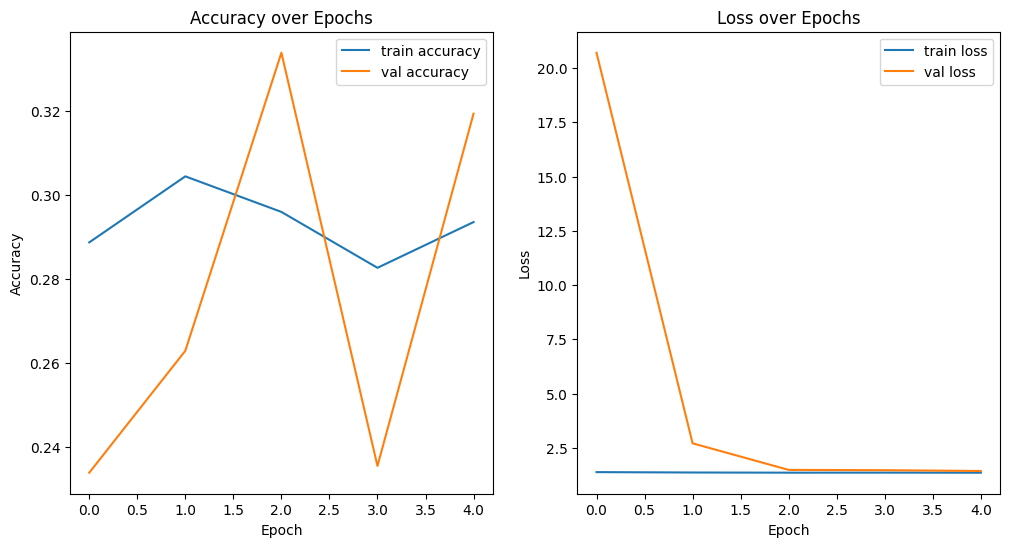

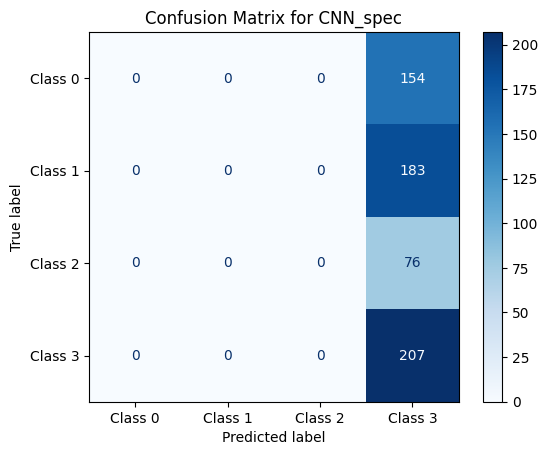

In [4]:
# Output the accuracies and losses for each training epoch for both training and validation datasets.
for split in ['train', 'val']:
    # Print the accuracies recorded during each epoch of the training and validation phases.
    print(split, 'accuracies by epoch:', accuracies[split])
    # Print the losses recorded during each epoch of the training and validation phases.
    print(split, 'losses by epoch:', losses[split])

# Save the trained model's weights to a file for later use, typically for deployment or further evaluation.
torch.save(model_ft.state_dict(), '../../models/CNN_spec_best_model.pt')

# Plot the training history, which typically includes plots of accuracy and loss over training epochs.
# This function is assumed to handle plotting and visualization tasks, enhancing understanding of training dynamics.
plot_training_history(accuracies, losses, 'CNN_spec')

# Generate and plot a confusion matrix to visualize the performance of the trained model in terms of
# its ability to correctly classify examples from the validation set.
# This is a crucial step for understanding model performance on different classes.
plot_confusion_matrix(labels, preds, 'CNN_spec')
